In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import math
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import tensorflow as tf
from torchvision.utils import save_image

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
torch.cuda.empty_cache() 

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 1

#"Cropper"
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
crop_size =256
re_size = 256
pad_size=(0,0,0,0) #for centering the image

# Number of channels in the training images. For color images this is 3
nc=3
ncg = 3
paired=True
if paired:
    ncd =nc+ncg
else:
    ncd=nc

# Size of z latent vector (i.e. size of generator input)
# nz = 100 #we wont be needing dis

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.00005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2= 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

width=28
height=28

# Root directory for dataset

#dataroot = (r"D:\work\facades_extracted\train\abuck")
#origin= (r"D:\work\facades_extracted\train\buck")
#testsample=(r"D:\work\facades_extracted\test\b")
dataroot = (r"D:\work\cityscape\B")
origin= (r"D:\work\cityscape\A")
testsample=(r"D:\work\facades_extracted\train\buck")

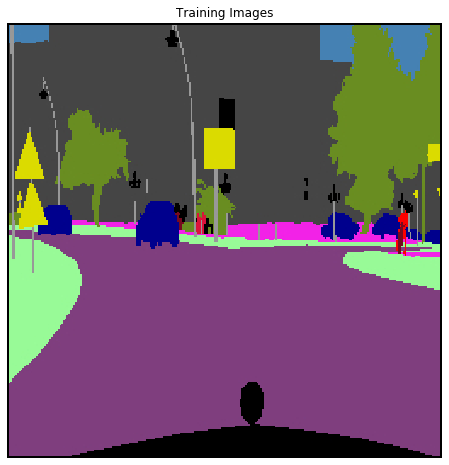

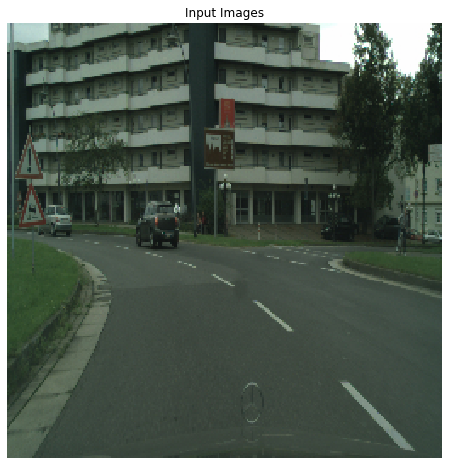

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(re_size),
                               transforms.Pad(pad_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataset for origins
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

dataset2 = dset.ImageFolder(root=origin,
                           transform=transforms.Compose([
                               #transforms.Grayscale(),
                               transforms.Resize(re_size),
                               transforms.Pad(pad_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
original = torch.utils.data.DataLoader(dataset2, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

# Create the dataset for testing
dataset3 = dset.ImageFolder(root=testsample,
                           transform=transforms.Compose([
                               transforms.Resize(re_size),
                               transforms.Pad(pad_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
testing = torch.utils.data.DataLoader(dataset3, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

real_batch = next(iter(original))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Input Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
#        def conv_lerelu_inst(inp,oup):
 #           return nn.Sequential(
  #              nn.Conv2d(inp,oup,3,stride=1,padding=1,bias=False),
   #             nn.InstanceNorm2d(oup),
    #            nn.LeakyReLU(0.2,inplace=True),
     #       )
#        def conv_lerelu(inp,oup):
 #           return nn.Sequential(
  #              nn.Conv2d(inp,oup,3,stride=1,padding=1,bias=False),
   #             nn.BatchNorm2d(oup),
    #            nn.LeakyReLU(0.2,inplace=True),
     #       )        
        # og is original dimension
        
    #resnet1
        self.resnet1p1=nn.Sequential(
            #input size (ngf*1) x og x og
            nn.Conv2d(ngf * 1,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.InstanceNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf * 1,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.InstanceNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*1) x og x og
        )
        self.resnet1p2=nn.Sequential(
            #input size (ngf*1) x og x og
            nn.Conv2d(ngf * 1,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.InstanceNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*1) x og x og
        )
        self.thinner2to1=nn.Sequential(
            #input size (ngf*2) x og x og
            nn.Conv2d(ngf * 2,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.InstanceNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*1) x og x og
        )
        
    #resnet2
        self.resnet2p1=nn.Sequential(
            #input size (ngf*2) x og x og
            nn.Conv2d(ngf * 2,ngf * 2,3,stride=1,padding=1,bias=False),
            nn.InstanceNorm2d(ngf * 2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf * 2,ngf * 2,3,stride=1,padding=1,bias=False),
            nn.InstanceNorm2d(ngf * 2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf * 2,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.InstanceNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*1) x og x og
        )
        self.resnet2p2=nn.Sequential(
            #input size (ngf*2) x og x og
            nn.Conv2d(ngf * 2,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.InstanceNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*1) x og x og
        )
        
    #resnet4
        self.resnet4p1=nn.Sequential(
            #input size (ngf*4) x og x og
            nn.Conv2d(ngf * 4,ngf * 4,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf * 4,ngf * 4,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf * 4,ngf * 2,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*2) x og x og
        )
        self.resnet4p2=nn.Sequential(
            #input size (ngf*4) x og x og
            nn.Conv2d(ngf * 4,ngf * 2,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*2) x og x og
        )
    
    #aspp
        self.encoder0_2t1=nn.Sequential(
            #input size (ngf*2) x og x og
            nn.Conv2d(ngf * 2,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #input size (ngf*1) x og x og
        )
        self.encoder2_2t1=nn.Sequential(
            #input size (ngf*2) x og x og
            nn.Conv2d(ngf*2,ngf*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf * 2,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf) x og/2 x og/2
        )
        self.encoder2_1t1=nn.Sequential(
            #input size (ngf) x og x og
            nn.Conv2d(ngf,ngf,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf * 1,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf) x og/2 x og/2
        )
        self.encoder4_2t1=nn.Sequential(
            #input size (ngf*2) x og x og
            nn.Conv2d(ngf*2,ngf*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*2) x og/2 x og/2
            nn.Conv2d(ngf*2,ngf*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*2) x og/4 x og/4
            nn.Conv2d(ngf * 2,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf) x og/4 x og/4
        )
        self.encoder8_2t1=nn.Sequential(
            #input size (ngf*2) x og x og
            nn.Conv2d(ngf*2,ngf*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*2) x og/2 x og/2
            nn.Conv2d(ngf*2,ngf*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*2) x og/4 x og/4
            nn.Conv2d(ngf*2,ngf*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf*2) x og/8 x og/8
            nn.Conv2d(ngf * 2,ngf * 1,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2,inplace=True),
            #state size (ngf) x og/8 x og/8
        )
        self.upsample2=nn.Sequential(
            #state size (ngf) x og/8 x og/8
            nn.Upsample(scale_factor=2,mode='bilinear')
            #state size (ngf) x og x og
        )
        self.upsample4=nn.Sequential(
            #state size (ngf) x og/8 x og/8
            nn.Upsample(scale_factor=4,mode='bilinear')
            #state size (ngf) x og x og
        )
        self.upsample8=nn.Sequential(
            #state size (ngf) x og/8 x og/8
            nn.Upsample(scale_factor=8,mode='bilinear')
            #state size (ngf) x og x og
        )
    #start and main and final
        self.start=nn.Sequential(
            #input size (ncg) x og x og
            nn.Conv2d( ncg, ngf * 2, 3, 1, 1, bias=False),
            #state size. (ngf*2) x og x og
        )
        self.final=nn.Sequential(
            #input size (ngf*4) x og x og
            nn.Conv2d( ngf * 4, nc, 3, 1, 1, bias=False),
            nn.Tanh(),
            # state size. (nc) x og x og
        )
        
    def forward(self, input):
        def resnet1(inp):
            #input size (ngf*1) x og x og
            p1=self.resnet1p1(inp)
            p2=self.resnet1p2(inp)
            catted=torch.cat((p1,p2),dim=1)
            output=self.thinner2to1(catted)
            #state size (ngf*1) x og x og
            return output
        
        def resnet2(inp):
            #input size (ngf*2) x og x og
            p1=self.resnet2p1(inp)
            p2=self.resnet2p2(inp)
            output=torch.cat((p1,p2),dim=1)
            #state size (ngf*2) x og x og
            return output
        
        def resnet4(inp):
            #input size (ngf*4) x og x og
            p1=self.resnet4p1(inp)
            p2=self.resnet4p2(inp)
            output=torch.cat((p1,p2),dim=1)
            #state size (ngf*4) x og x og
            return output
        
        def aspp(inp):
            #input size (ngf*2) x og x og
            s0=self.encoder0_2t1(inp)
            s0=resnet1(s0)
            
            s1=self.encoder2_2t1(inp)
            s1=resnet1(s1)
            s1=self.upsample2(s1)
            
            s2=self.encoder2_2t1(inp)
            s2=resnet1(s2)
            s2=self.encoder2_1t1(s2)
            s2=resnet1(s2)
            s2=self.upsample2(s2)
            s2=resnet1(s2)
            s2=self.upsample2(s2)
            
            s3=self.encoder2_2t1(inp)
            s3=resnet1(s3)
            s3=self.encoder2_1t1(s3)
            s3=resnet1(s3)
            s3=self.encoder2_1t1(s3)
            s3=resnet1(s3)
            s3=self.upsample2(s3)
            s3=resnet1(s3)
            s3=self.upsample2(s3)
            s3=resnet1(s3)
            s3=self.upsample2(s3)
            
            aspp1=torch.cat((s0,s1),dim=1)
            aspp2=torch.cat((s2,s3),dim=1)
            aspp=torch.cat((aspp1,aspp2),dim=1)
            output=resnet4(aspp)
            #state size (ngf*4) x og x og
            return output
        
        def resmain2(inp):
            s1=resnet2(inp)
            s2=resnet2(s1)
            output=resnet2(s2)
            return output
        
        def resmain4(inp):
            s1=resnet4(inp)
            s2=resnet4(s1)
            output=resnet4(s2)
            return output
        
        #start stage depth conversion
        start2=self.start(input)
        #main pre aspp calc
        #aspp
        aspp2to4=aspp(start2)
        #post aspp calc
        main4=resmain4(aspp2to4)
        #final stage depth conversion
        final=self.final(main4)
        return final

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (resnet1p1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (resnet1p2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (thinner2to1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): Leaky

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.start1=nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(ncd, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
        )
        self.start2=nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(ncd, ndf, 4, stride=2, padding=3, dilation=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32    
        )
        self.main = nn.Sequential(
            
            # state size. (ndf) x 32 x 32   
            nn.Conv2d(ndf*2, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf*2, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2
            nn.Conv2d(ndf * 8, 1, 2, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        start1=self.start1(input)
        start2=self.start2(input)
        aspp=torch.cat((start1,start2),dim=1)
        output=self.main(aspp)
        return output

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (start1): Sequential(
    (0): Conv2d(6, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (start2): Sequential(
    (0): Conv2d(6, 128, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
img_list2 = []
G_losses = []
D_losses = []
iters = 0
os.makedirs("images", exist_ok=True)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    #for index, (value1, value2) in enumerate(zip(data1, data2)):
    iteration = 0
    for i, (data, data2) in enumerate(zip(dataloader,original), 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
            netD.zero_grad()
        # Format batch
            real_cpu = torch.cat((data2[0].to(device),data[0].to(device)),dim=1)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device)
            
        # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
            #print("output", output.shape)
            errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        #noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
                # Format batch
            #print("data2", data2[0].shape)
            fake_cpu = data2[0].to(device)
            #print("fake_cpu",fake_cpu.shape)
            fake=netG(fake_cpu)
            fake = torch.cat((data2[0].to(device),fake),dim=1)
          
            label.fill_(fake_label)
        # Classify all fake batch with D
            #print("fake", fake.shape)
            output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
            #print("output", output.shape)
            #print("label", label.shape)
            #print("number of for loop")
            #iteration += 1
            #print(iteration)
            errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
        # Update D
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
        # Calculate G's loss based on this output
            errG = criterion(output, label)
        # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
        # Update G
            optimizerG.step()

        # Output training stats
            if i % 10 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % math.ceil(100) == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fake_cpu).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                img_list2.append(vutils.make_grid(fake_cpu, padding=2, normalize=True))
                save_image(fake.data, "images/%d.jpg" % iters, nrow=4, normalize=True)
                if (iters % math.ceil(500) == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                    save_image(fake_cpu.data,"images/%d input.jpg" % iters, nrow=4, normalize=True)
                    save_image(data[0].to(device),"images/%d solution.jpg" % iters, nrow=4, normalize=True)
  
            iters += 1

Starting Training Loop...


C:\Users\Artificial Intellige\Anaconda3\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[0/100][0/2975]	Loss_D: 1.4840	Loss_G: 7.0612	D(x): 0.4146	D(G(z)): 0.4532 / 0.0009
[0/100][10/2975]	Loss_D: 0.7768	Loss_G: 7.6154	D(x): 0.9107	D(G(z)): 0.4950 / 0.0005
[0/100][20/2975]	Loss_D: 0.3512	Loss_G: 4.1317	D(x): 0.7251	D(G(z)): 0.0293 / 0.0161
[0/100][30/2975]	Loss_D: 0.2355	Loss_G: 5.5222	D(x): 0.9021	D(G(z)): 0.1241 / 0.0040
[0/100][40/2975]	Loss_D: 0.3786	Loss_G: 8.3780	D(x): 0.9947	D(G(z)): 0.3115 / 0.0002
[0/100][50/2975]	Loss_D: 0.0191	Loss_G: 5.4871	D(x): 0.9877	D(G(z)): 0.0068 / 0.0041
[0/100][60/2975]	Loss_D: 0.0222	Loss_G: 5.3743	D(x): 0.9865	D(G(z)): 0.0086 / 0.0046
[0/100][70/2975]	Loss_D: 0.0820	Loss_G: 6.0465	D(x): 0.9957	D(G(z)): 0.0748 / 0.0024
[0/100][80/2975]	Loss_D: 0.0741	Loss_G: 6.0249	D(x): 0.9917	D(G(z)): 0.0637 / 0.0024
[0/100][90/2975]	Loss_D: 0.0387	Loss_G: 5.2898	D(x): 0.9728	D(G(z)): 0.0111 / 0.0050
[0/100][100/2975]	Loss_D: 0.0147	Loss_G: 5.4680	D(x): 0.9985	D(G(z)): 0.0132 / 0.0042
[0/100][110/2975]	Loss_D: 1.2232	Loss_G: 1.7681	D(x): 0.3019	D(G(

[0/100][950/2975]	Loss_D: 0.1113	Loss_G: 6.8046	D(x): 0.9994	D(G(z)): 0.1048 / 0.0011
[0/100][960/2975]	Loss_D: 0.0129	Loss_G: 5.2443	D(x): 0.9999	D(G(z)): 0.0127 / 0.0053
[0/100][970/2975]	Loss_D: 2.5551	Loss_G: 19.5342	D(x): 0.9999	D(G(z)): 0.9223 / 0.0000
[0/100][980/2975]	Loss_D: 0.0077	Loss_G: 9.9729	D(x): 0.9924	D(G(z)): 0.0001 / 0.0000
[0/100][990/2975]	Loss_D: 0.0382	Loss_G: 17.0374	D(x): 0.9626	D(G(z)): 0.0000 / 0.0000
[0/100][1000/2975]	Loss_D: 0.0004	Loss_G: 10.1444	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/100][1010/2975]	Loss_D: 0.1785	Loss_G: 11.6086	D(x): 0.8365	D(G(z)): 0.0000 / 0.0000
[0/100][1020/2975]	Loss_D: 0.0005	Loss_G: 7.9865	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[0/100][1030/2975]	Loss_D: 0.0022	Loss_G: 6.2983	D(x): 1.0000	D(G(z)): 0.0022 / 0.0018
[0/100][1040/2975]	Loss_D: 0.0026	Loss_G: 6.9156	D(x): 0.9984	D(G(z)): 0.0010 / 0.0010
[0/100][1050/2975]	Loss_D: 0.0018	Loss_G: 8.0838	D(x): 0.9986	D(G(z)): 0.0004 / 0.0003
[0/100][1060/2975]	Loss_D: 0.0003	Loss_G: 9.

[0/100][1880/2975]	Loss_D: 0.0400	Loss_G: 5.3317	D(x): 0.9946	D(G(z)): 0.0340 / 0.0048
[0/100][1890/2975]	Loss_D: 0.0726	Loss_G: 16.7015	D(x): 0.9300	D(G(z)): 0.0000 / 0.0000
[0/100][1900/2975]	Loss_D: 0.7921	Loss_G: 1.9833	D(x): 0.4529	D(G(z)): 0.0000 / 0.1376
[0/100][1910/2975]	Loss_D: 0.0002	Loss_G: 9.6801	D(x): 0.9999	D(G(z)): 0.0000 / 0.0001
[0/100][1920/2975]	Loss_D: 1.4316	Loss_G: 15.7152	D(x): 0.2389	D(G(z)): 0.0000 / 0.0000
[0/100][1930/2975]	Loss_D: 0.5144	Loss_G: 15.1873	D(x): 1.0000	D(G(z)): 0.4021 / 0.0000
[0/100][1940/2975]	Loss_D: 0.0007	Loss_G: 18.5022	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[0/100][1950/2975]	Loss_D: 0.0662	Loss_G: 7.3311	D(x): 1.0000	D(G(z)): 0.0641 / 0.0007
[0/100][1960/2975]	Loss_D: 0.0033	Loss_G: 6.0763	D(x): 0.9997	D(G(z)): 0.0030 / 0.0023
[0/100][1970/2975]	Loss_D: 0.0026	Loss_G: 6.9243	D(x): 0.9983	D(G(z)): 0.0008 / 0.0010
[0/100][1980/2975]	Loss_D: 0.3972	Loss_G: 12.8668	D(x): 0.9997	D(G(z)): 0.3276 / 0.0000
[0/100][1990/2975]	Loss_D: 0.0034	Loss

[0/100][2810/2975]	Loss_D: 0.0239	Loss_G: 8.4487	D(x): 0.9765	D(G(z)): 0.0002 / 0.0002
[0/100][2820/2975]	Loss_D: 0.1233	Loss_G: 9.6881	D(x): 0.8841	D(G(z)): 0.0000 / 0.0001
[0/100][2830/2975]	Loss_D: 0.8432	Loss_G: 15.2241	D(x): 0.4303	D(G(z)): 0.0000 / 0.0000
[0/100][2840/2975]	Loss_D: 0.0587	Loss_G: 4.2221	D(x): 0.9560	D(G(z)): 0.0137 / 0.0147
[0/100][2850/2975]	Loss_D: 0.4472	Loss_G: 3.9038	D(x): 0.7353	D(G(z)): 0.1304 / 0.0202
[0/100][2860/2975]	Loss_D: 0.0278	Loss_G: 9.0827	D(x): 0.9727	D(G(z)): 0.0001 / 0.0001
[0/100][2870/2975]	Loss_D: 0.8151	Loss_G: 16.3799	D(x): 0.9971	D(G(z)): 0.5561 / 0.0000
[0/100][2880/2975]	Loss_D: 0.0455	Loss_G: 8.0547	D(x): 0.9558	D(G(z)): 0.0002 / 0.0003
[0/100][2890/2975]	Loss_D: 0.1086	Loss_G: 5.2516	D(x): 0.9996	D(G(z)): 0.1025 / 0.0052
[0/100][2900/2975]	Loss_D: 0.0072	Loss_G: 15.7355	D(x): 0.9929	D(G(z)): 0.0000 / 0.0000
[0/100][2910/2975]	Loss_D: 0.0031	Loss_G: 7.7947	D(x): 0.9973	D(G(z)): 0.0004 / 0.0004
[0/100][2920/2975]	Loss_D: 0.0300	Loss_G

[1/100][780/2975]	Loss_D: 0.1184	Loss_G: 3.7352	D(x): 0.9679	D(G(z)): 0.0822 / 0.0239
[1/100][790/2975]	Loss_D: 2.2397	Loss_G: 1.4655	D(x): 0.1076	D(G(z)): 0.0104 / 0.2310
[1/100][800/2975]	Loss_D: 0.3079	Loss_G: 6.8471	D(x): 0.9987	D(G(z)): 0.2641 / 0.0011
[1/100][810/2975]	Loss_D: 0.2616	Loss_G: 4.1688	D(x): 0.9873	D(G(z)): 0.2202 / 0.0155
[1/100][820/2975]	Loss_D: 0.0407	Loss_G: 4.7320	D(x): 0.9729	D(G(z)): 0.0131 / 0.0088
[1/100][830/2975]	Loss_D: 0.1024	Loss_G: 3.8777	D(x): 0.9224	D(G(z)): 0.0214 / 0.0207
[1/100][840/2975]	Loss_D: 0.0158	Loss_G: 6.0134	D(x): 0.9930	D(G(z)): 0.0087 / 0.0024
[1/100][850/2975]	Loss_D: 0.1565	Loss_G: 5.4730	D(x): 0.9993	D(G(z)): 0.1443 / 0.0042
[1/100][860/2975]	Loss_D: 0.0343	Loss_G: 2.0627	D(x): 0.9995	D(G(z)): 0.0332 / 0.1271
[1/100][870/2975]	Loss_D: 0.1237	Loss_G: 6.3844	D(x): 0.8840	D(G(z)): 0.0004 / 0.0017
[1/100][880/2975]	Loss_D: 0.0377	Loss_G: 5.8611	D(x): 0.9647	D(G(z)): 0.0018 / 0.0028
[1/100][890/2975]	Loss_D: 0.4911	Loss_G: 7.6145	D(x): 

[1/100][1720/2975]	Loss_D: 2.4620	Loss_G: 0.9770	D(x): 0.0886	D(G(z)): 0.0378 / 0.3764
[1/100][1730/2975]	Loss_D: 0.3665	Loss_G: 2.1141	D(x): 0.7942	D(G(z)): 0.1273 / 0.1207
[1/100][1740/2975]	Loss_D: 0.3012	Loss_G: 3.9783	D(x): 0.7872	D(G(z)): 0.0600 / 0.0187
[1/100][1750/2975]	Loss_D: 0.3007	Loss_G: 1.6386	D(x): 0.8007	D(G(z)): 0.0755 / 0.1943
[1/100][1760/2975]	Loss_D: 1.6860	Loss_G: 3.6867	D(x): 0.9958	D(G(z)): 0.8140 / 0.0251
[1/100][1770/2975]	Loss_D: 1.4278	Loss_G: 4.8451	D(x): 0.9143	D(G(z)): 0.7377 / 0.0079
[1/100][1780/2975]	Loss_D: 0.5754	Loss_G: 2.5134	D(x): 0.9490	D(G(z)): 0.4073 / 0.0810
[1/100][1790/2975]	Loss_D: 0.5834	Loss_G: 2.4729	D(x): 0.9500	D(G(z)): 0.4126 / 0.0843
[1/100][1800/2975]	Loss_D: 0.3132	Loss_G: 2.5522	D(x): 0.8838	D(G(z)): 0.1727 / 0.0779
[1/100][1810/2975]	Loss_D: 0.0060	Loss_G: 4.1245	D(x): 1.0000	D(G(z)): 0.0059 / 0.0162
[1/100][1820/2975]	Loss_D: 1.6318	Loss_G: 3.8567	D(x): 0.9901	D(G(z)): 0.8025 / 0.0211
[1/100][1830/2975]	Loss_D: 1.4836	Loss_G: 2

[1/100][2660/2975]	Loss_D: 1.2878	Loss_G: 1.8827	D(x): 0.2770	D(G(z)): 0.0040 / 0.1522
[1/100][2670/2975]	Loss_D: 0.4294	Loss_G: 1.6761	D(x): 0.8275	D(G(z)): 0.2134 / 0.1871
[1/100][2680/2975]	Loss_D: 0.1273	Loss_G: 3.9811	D(x): 0.9813	D(G(z)): 0.1028 / 0.0187
[1/100][2690/2975]	Loss_D: 0.4086	Loss_G: 3.2485	D(x): 0.8221	D(G(z)): 0.1916 / 0.0388
[1/100][2700/2975]	Loss_D: 0.2577	Loss_G: 3.4606	D(x): 0.9505	D(G(z)): 0.1869 / 0.0314
[1/100][2710/2975]	Loss_D: 0.5048	Loss_G: 2.2988	D(x): 0.9672	D(G(z)): 0.3759 / 0.1004
[1/100][2720/2975]	Loss_D: 0.3912	Loss_G: 2.2189	D(x): 0.6882	D(G(z)): 0.0174 / 0.1087
[1/100][2730/2975]	Loss_D: 0.5383	Loss_G: 4.2063	D(x): 0.5906	D(G(z)): 0.0116 / 0.0149
[1/100][2740/2975]	Loss_D: 0.1407	Loss_G: 2.9999	D(x): 0.9944	D(G(z)): 0.1263 / 0.0498
[1/100][2750/2975]	Loss_D: 3.9783	Loss_G: 2.7619	D(x): 0.9993	D(G(z)): 0.9813 / 0.0632
[1/100][2760/2975]	Loss_D: 2.4636	Loss_G: 2.0758	D(x): 0.0911	D(G(z)): 0.0650 / 0.1255
[1/100][2770/2975]	Loss_D: 0.6843	Loss_G: 2

[2/100][630/2975]	Loss_D: 0.0552	Loss_G: 3.9963	D(x): 0.9800	D(G(z)): 0.0344 / 0.0184
[2/100][640/2975]	Loss_D: 0.2250	Loss_G: 4.1341	D(x): 0.9996	D(G(z)): 0.2012 / 0.0160
[2/100][650/2975]	Loss_D: 0.0064	Loss_G: 5.7125	D(x): 0.9974	D(G(z)): 0.0038 / 0.0033
[2/100][660/2975]	Loss_D: 0.0004	Loss_G: 8.5235	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[2/100][670/2975]	Loss_D: 0.1594	Loss_G: 4.3916	D(x): 0.9820	D(G(z)): 0.1318 / 0.0124
[2/100][680/2975]	Loss_D: 0.0253	Loss_G: 5.7278	D(x): 0.9958	D(G(z)): 0.0208 / 0.0033
[2/100][690/2975]	Loss_D: 0.0940	Loss_G: 3.0998	D(x): 0.9839	D(G(z)): 0.0748 / 0.0451
[2/100][700/2975]	Loss_D: 0.9856	Loss_G: 4.1097	D(x): 0.9988	D(G(z)): 0.6263 / 0.0164
[2/100][710/2975]	Loss_D: 0.0480	Loss_G: 3.7820	D(x): 0.9670	D(G(z)): 0.0144 / 0.0228
[2/100][720/2975]	Loss_D: 0.9354	Loss_G: 2.7222	D(x): 0.3957	D(G(z)): 0.0082 / 0.0657
[2/100][730/2975]	Loss_D: 1.6028	Loss_G: 3.4877	D(x): 0.2023	D(G(z)): 0.0048 / 0.0306
[2/100][740/2975]	Loss_D: 0.1660	Loss_G: 4.0063	D(x): 

[2/100][1570/2975]	Loss_D: 1.5397	Loss_G: 0.8302	D(x): 0.2176	D(G(z)): 0.0144 / 0.4359
[2/100][1580/2975]	Loss_D: 0.1073	Loss_G: 3.2013	D(x): 0.9718	D(G(z)): 0.0757 / 0.0407
[2/100][1590/2975]	Loss_D: 0.0924	Loss_G: 5.5501	D(x): 0.9951	D(G(z)): 0.0837 / 0.0039
[2/100][1600/2975]	Loss_D: 0.2073	Loss_G: 6.2350	D(x): 0.8136	D(G(z)): 0.0010 / 0.0020
[2/100][1610/2975]	Loss_D: 0.0015	Loss_G: 10.2054	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[2/100][1620/2975]	Loss_D: 0.1332	Loss_G: 2.8697	D(x): 0.9445	D(G(z)): 0.0733 / 0.0567
[2/100][1630/2975]	Loss_D: 0.2364	Loss_G: 3.0600	D(x): 0.9198	D(G(z)): 0.1417 / 0.0469
[2/100][1640/2975]	Loss_D: 0.0286	Loss_G: 3.9192	D(x): 0.9908	D(G(z)): 0.0191 / 0.0199
[2/100][1650/2975]	Loss_D: 1.2622	Loss_G: 2.7564	D(x): 0.7696	D(G(z)): 0.6322 / 0.0635
[2/100][1660/2975]	Loss_D: 0.7126	Loss_G: 1.6508	D(x): 0.5164	D(G(z)): 0.0504 / 0.1919
[2/100][1670/2975]	Loss_D: 0.0934	Loss_G: 7.2425	D(x): 0.9113	D(G(z)): 0.0005 / 0.0007
[2/100][1680/2975]	Loss_D: 0.3611	Loss_G: 

[2/100][2510/2975]	Loss_D: 0.4279	Loss_G: 1.8095	D(x): 0.7581	D(G(z)): 0.1401 / 0.1637
[2/100][2520/2975]	Loss_D: 0.2249	Loss_G: 2.8948	D(x): 0.8869	D(G(z)): 0.0996 / 0.0553
[2/100][2530/2975]	Loss_D: 1.8028	Loss_G: 1.2352	D(x): 0.1675	D(G(z)): 0.0160 / 0.2908
[2/100][2540/2975]	Loss_D: 0.3190	Loss_G: 5.1749	D(x): 0.9787	D(G(z)): 0.2573 / 0.0057
[2/100][2550/2975]	Loss_D: 0.1655	Loss_G: 2.6203	D(x): 0.9262	D(G(z)): 0.0850 / 0.0728
[2/100][2560/2975]	Loss_D: 0.3052	Loss_G: 4.3004	D(x): 0.7396	D(G(z)): 0.0035 / 0.0136
[2/100][2570/2975]	Loss_D: 0.5899	Loss_G: 3.5551	D(x): 0.5577	D(G(z)): 0.0059 / 0.0286
[2/100][2580/2975]	Loss_D: 1.6151	Loss_G: 1.3963	D(x): 0.2565	D(G(z)): 0.2246 / 0.2475
[2/100][2590/2975]	Loss_D: 0.3447	Loss_G: 5.4688	D(x): 0.9383	D(G(z)): 0.2450 / 0.0042
[2/100][2600/2975]	Loss_D: 0.9558	Loss_G: 2.0393	D(x): 0.4007	D(G(z)): 0.0405 / 0.1301
[2/100][2610/2975]	Loss_D: 0.0491	Loss_G: 2.4046	D(x): 0.9922	D(G(z)): 0.0404 / 0.0903
[2/100][2620/2975]	Loss_D: 0.2725	Loss_G: 3

[3/100][470/2975]	Loss_D: 0.0018	Loss_G: 6.9628	D(x): 0.9999	D(G(z)): 0.0018 / 0.0009
[3/100][480/2975]	Loss_D: 0.0112	Loss_G: 6.9436	D(x): 0.9898	D(G(z)): 0.0009 / 0.0010
[3/100][490/2975]	Loss_D: 0.0017	Loss_G: 6.1413	D(x): 1.0000	D(G(z)): 0.0017 / 0.0022
[3/100][500/2975]	Loss_D: 0.0184	Loss_G: 4.2786	D(x): 0.9999	D(G(z)): 0.0182 / 0.0139
[3/100][510/2975]	Loss_D: 1.2392	Loss_G: 1.0072	D(x): 0.2926	D(G(z)): 0.0103 / 0.3652
[3/100][520/2975]	Loss_D: 0.0000	Loss_G: 10.0435	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/100][530/2975]	Loss_D: 0.0250	Loss_G: 4.3475	D(x): 1.0000	D(G(z)): 0.0247 / 0.0129
[3/100][540/2975]	Loss_D: 0.0048	Loss_G: 5.4199	D(x): 1.0000	D(G(z)): 0.0048 / 0.0044
[3/100][550/2975]	Loss_D: 0.0010	Loss_G: 7.1350	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008
[3/100][560/2975]	Loss_D: 0.0053	Loss_G: 6.2082	D(x): 0.9998	D(G(z)): 0.0051 / 0.0020
[3/100][570/2975]	Loss_D: 0.0219	Loss_G: 4.8683	D(x): 1.0000	D(G(z)): 0.0216 / 0.0077
[3/100][580/2975]	Loss_D: 0.0041	Loss_G: 6.5235	D(x):

[3/100][1410/2975]	Loss_D: 0.0007	Loss_G: 7.8314	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004
[3/100][1420/2975]	Loss_D: 0.1884	Loss_G: 1.6774	D(x): 0.8811	D(G(z)): 0.0600 / 0.1869
[3/100][1430/2975]	Loss_D: 0.1936	Loss_G: 3.0191	D(x): 0.9363	D(G(z)): 0.1200 / 0.0488
[3/100][1440/2975]	Loss_D: 0.5218	Loss_G: 2.7298	D(x): 0.8277	D(G(z)): 0.2830 / 0.0652
[3/100][1450/2975]	Loss_D: 0.1843	Loss_G: 1.9595	D(x): 0.9886	D(G(z)): 0.1587 / 0.1409
[3/100][1460/2975]	Loss_D: 0.1105	Loss_G: 4.4363	D(x): 0.9939	D(G(z)): 0.0991 / 0.0118
[3/100][1470/2975]	Loss_D: 0.2422	Loss_G: 2.3133	D(x): 0.8637	D(G(z)): 0.0913 / 0.0989
[3/100][1480/2975]	Loss_D: 0.4257	Loss_G: 1.9996	D(x): 0.7235	D(G(z)): 0.0971 / 0.1354
[3/100][1490/2975]	Loss_D: 0.4534	Loss_G: 4.8949	D(x): 0.9942	D(G(z)): 0.3608 / 0.0075
[3/100][1500/2975]	Loss_D: 3.8019	Loss_G: 4.5987	D(x): 0.0223	D(G(z)): 0.0010 / 0.0101
[3/100][1510/2975]	Loss_D: 0.0134	Loss_G: 4.1643	D(x): 1.0000	D(G(z)): 0.0133 / 0.0155
[3/100][1520/2975]	Loss_D: 3.3413	Loss_G: 7

[3/100][2350/2975]	Loss_D: 0.3397	Loss_G: 2.7465	D(x): 0.7289	D(G(z)): 0.0232 / 0.0641
[3/100][2360/2975]	Loss_D: 0.3534	Loss_G: 3.3600	D(x): 0.7165	D(G(z)): 0.0198 / 0.0347
[3/100][2370/2975]	Loss_D: 0.0560	Loss_G: 3.9791	D(x): 0.9731	D(G(z)): 0.0283 / 0.0187
[3/100][2380/2975]	Loss_D: 0.2200	Loss_G: 1.9504	D(x): 0.8672	D(G(z)): 0.0746 / 0.1422
[3/100][2390/2975]	Loss_D: 0.3805	Loss_G: 2.4596	D(x): 0.7061	D(G(z)): 0.0321 / 0.0855
[3/100][2400/2975]	Loss_D: 0.1614	Loss_G: 2.2206	D(x): 0.9987	D(G(z)): 0.1480 / 0.1085
[3/100][2410/2975]	Loss_D: 0.3329	Loss_G: 1.2074	D(x): 0.7365	D(G(z)): 0.0267 / 0.2990
[3/100][2420/2975]	Loss_D: 0.2939	Loss_G: 1.9932	D(x): 0.9778	D(G(z)): 0.2377 / 0.1363
[3/100][2430/2975]	Loss_D: 0.2079	Loss_G: 1.9620	D(x): 0.9587	D(G(z)): 0.1527 / 0.1406
[3/100][2440/2975]	Loss_D: 0.9717	Loss_G: 0.4610	D(x): 0.4581	D(G(z)): 0.1739 / 0.6306
[3/100][2450/2975]	Loss_D: 1.5396	Loss_G: 1.5350	D(x): 0.2202	D(G(z)): 0.0259 / 0.2155
[3/100][2460/2975]	Loss_D: 0.0628	Loss_G: 2

[4/100][310/2975]	Loss_D: 0.5001	Loss_G: 2.4275	D(x): 0.6491	D(G(z)): 0.0656 / 0.0883
[4/100][320/2975]	Loss_D: 0.0022	Loss_G: 6.5586	D(x): 0.9993	D(G(z)): 0.0015 / 0.0014
[4/100][330/2975]	Loss_D: 0.0062	Loss_G: 5.1968	D(x): 1.0000	D(G(z)): 0.0061 / 0.0055
[4/100][340/2975]	Loss_D: 0.0046	Loss_G: 5.5508	D(x): 1.0000	D(G(z)): 0.0046 / 0.0039
[4/100][350/2975]	Loss_D: 0.0039	Loss_G: 5.6559	D(x): 0.9999	D(G(z)): 0.0038 / 0.0035
[4/100][360/2975]	Loss_D: 0.0158	Loss_G: 4.4203	D(x): 0.9998	D(G(z)): 0.0155 / 0.0120
[4/100][370/2975]	Loss_D: 0.1234	Loss_G: 3.4334	D(x): 0.9999	D(G(z)): 0.1160 / 0.0323
[4/100][380/2975]	Loss_D: 0.0006	Loss_G: 8.6233	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002
[4/100][390/2975]	Loss_D: 0.0004	Loss_G: 10.2299	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[4/100][400/2975]	Loss_D: 0.2148	Loss_G: 4.9777	D(x): 0.8084	D(G(z)): 0.0021 / 0.0069
[4/100][410/2975]	Loss_D: 0.0168	Loss_G: 4.5029	D(x): 0.9970	D(G(z)): 0.0136 / 0.0111
[4/100][420/2975]	Loss_D: 0.0004	Loss_G: 8.6834	D(x):

[4/100][1250/2975]	Loss_D: 0.0039	Loss_G: 5.6359	D(x): 0.9997	D(G(z)): 0.0037 / 0.0036
[4/100][1260/2975]	Loss_D: 0.0063	Loss_G: 5.1264	D(x): 1.0000	D(G(z)): 0.0062 / 0.0059
[4/100][1270/2975]	Loss_D: 0.0065	Loss_G: 5.1001	D(x): 0.9999	D(G(z)): 0.0064 / 0.0061
[4/100][1280/2975]	Loss_D: 0.0201	Loss_G: 4.1810	D(x): 0.9986	D(G(z)): 0.0186 / 0.0153
[4/100][1290/2975]	Loss_D: 0.0093	Loss_G: 4.7598	D(x): 0.9999	D(G(z)): 0.0092 / 0.0086
[4/100][1300/2975]	Loss_D: 0.0038	Loss_G: 5.7666	D(x): 0.9995	D(G(z)): 0.0033 / 0.0031
[4/100][1310/2975]	Loss_D: 0.0075	Loss_G: 5.0001	D(x): 0.9999	D(G(z)): 0.0074 / 0.0067
[4/100][1320/2975]	Loss_D: 0.0027	Loss_G: 5.9506	D(x): 0.9999	D(G(z)): 0.0027 / 0.0026
[4/100][1330/2975]	Loss_D: 0.0017	Loss_G: 7.1708	D(x): 0.9991	D(G(z)): 0.0008 / 0.0008
[4/100][1340/2975]	Loss_D: 0.0180	Loss_G: 4.2932	D(x): 1.0000	D(G(z)): 0.0178 / 0.0137
[4/100][1350/2975]	Loss_D: 0.0424	Loss_G: 4.8036	D(x): 0.9999	D(G(z)): 0.0414 / 0.0082
[4/100][1360/2975]	Loss_D: 0.0037	Loss_G: 6

[4/100][2190/2975]	Loss_D: 0.1493	Loss_G: 3.9415	D(x): 0.9997	D(G(z)): 0.1384 / 0.0194
[4/100][2200/2975]	Loss_D: 0.0691	Loss_G: 4.5778	D(x): 0.9451	D(G(z)): 0.0125 / 0.0103
[4/100][2210/2975]	Loss_D: 0.0029	Loss_G: 6.7598	D(x): 0.9983	D(G(z)): 0.0012 / 0.0012
[4/100][2220/2975]	Loss_D: 0.0018	Loss_G: 6.4152	D(x): 0.9999	D(G(z)): 0.0018 / 0.0016
[4/100][2230/2975]	Loss_D: 0.0085	Loss_G: 4.9535	D(x): 0.9998	D(G(z)): 0.0083 / 0.0071
[4/100][2240/2975]	Loss_D: 0.0041	Loss_G: 6.6076	D(x): 0.9993	D(G(z)): 0.0034 / 0.0014
[4/100][2250/2975]	Loss_D: 0.2138	Loss_G: 4.8135	D(x): 0.9891	D(G(z)): 0.1836 / 0.0081
[4/100][2260/2975]	Loss_D: 1.3945	Loss_G: 8.1085	D(x): 0.9994	D(G(z)): 0.7519 / 0.0003
[4/100][2270/2975]	Loss_D: 1.9824	Loss_G: 9.0854	D(x): 1.0000	D(G(z)): 0.8623 / 0.0001
[4/100][2280/2975]	Loss_D: 0.0906	Loss_G: 3.6056	D(x): 0.9999	D(G(z)): 0.0866 / 0.0272
[4/100][2290/2975]	Loss_D: 0.0001	Loss_G: 9.0426	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[4/100][2300/2975]	Loss_D: 0.0945	Loss_G: 4

[5/100][150/2975]	Loss_D: 0.3906	Loss_G: 4.1075	D(x): 0.6860	D(G(z)): 0.0136 / 0.0164
[5/100][160/2975]	Loss_D: 0.9487	Loss_G: 6.0016	D(x): 0.9991	D(G(z)): 0.6124 / 0.0025
[5/100][170/2975]	Loss_D: 0.0283	Loss_G: 3.8187	D(x): 0.9882	D(G(z)): 0.0163 / 0.0220
[5/100][180/2975]	Loss_D: 0.0524	Loss_G: 3.8036	D(x): 0.9725	D(G(z)): 0.0243 / 0.0223
[5/100][190/2975]	Loss_D: 0.0876	Loss_G: 3.0037	D(x): 0.9918	D(G(z)): 0.0763 / 0.0496
[5/100][200/2975]	Loss_D: 0.0046	Loss_G: 5.5007	D(x): 0.9995	D(G(z)): 0.0041 / 0.0041
[5/100][210/2975]	Loss_D: 0.0836	Loss_G: 3.1827	D(x): 0.9673	D(G(z)): 0.0491 / 0.0415
[5/100][220/2975]	Loss_D: 0.0148	Loss_G: 4.3195	D(x): 1.0000	D(G(z)): 0.0147 / 0.0133
[5/100][230/2975]	Loss_D: 0.0288	Loss_G: 3.7680	D(x): 0.9997	D(G(z)): 0.0282 / 0.0231
[5/100][240/2975]	Loss_D: 0.0063	Loss_G: 5.5633	D(x): 0.9989	D(G(z)): 0.0052 / 0.0038
[5/100][250/2975]	Loss_D: 0.1648	Loss_G: 3.2764	D(x): 0.9999	D(G(z)): 0.1518 / 0.0378
[5/100][260/2975]	Loss_D: 0.0148	Loss_G: 4.3641	D(x): 

[5/100][1100/2975]	Loss_D: 0.0041	Loss_G: 6.2615	D(x): 1.0000	D(G(z)): 0.0041 / 0.0019
[5/100][1110/2975]	Loss_D: 6.3167	Loss_G: 5.2858	D(x): 0.0018	D(G(z)): 0.0015 / 0.0051
[5/100][1120/2975]	Loss_D: 0.0095	Loss_G: 4.8852	D(x): 0.9999	D(G(z)): 0.0093 / 0.0076
[5/100][1130/2975]	Loss_D: 0.0122	Loss_G: 4.8355	D(x): 0.9968	D(G(z)): 0.0089 / 0.0079
[5/100][1140/2975]	Loss_D: 0.0637	Loss_G: 4.7286	D(x): 0.9899	D(G(z)): 0.0521 / 0.0088
[5/100][1150/2975]	Loss_D: 0.0076	Loss_G: 5.0391	D(x): 0.9996	D(G(z)): 0.0071 / 0.0065
[5/100][1160/2975]	Loss_D: 0.0078	Loss_G: 5.1161	D(x): 1.0000	D(G(z)): 0.0077 / 0.0060
[5/100][1170/2975]	Loss_D: 0.0012	Loss_G: 7.0494	D(x): 0.9997	D(G(z)): 0.0009 / 0.0009
[5/100][1180/2975]	Loss_D: 0.0060	Loss_G: 5.6223	D(x): 0.9957	D(G(z)): 0.0016 / 0.0036
[5/100][1190/2975]	Loss_D: 0.0002	Loss_G: 9.5848	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[5/100][1200/2975]	Loss_D: 0.0004	Loss_G: 7.9768	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[5/100][1210/2975]	Loss_D: 0.0004	Loss_G: 8

[5/100][2040/2975]	Loss_D: 0.1603	Loss_G: 3.8481	D(x): 0.8666	D(G(z)): 0.0170 / 0.0213
[5/100][2050/2975]	Loss_D: 0.0399	Loss_G: 3.6305	D(x): 0.9959	D(G(z)): 0.0351 / 0.0265
[5/100][2060/2975]	Loss_D: 0.0235	Loss_G: 6.4056	D(x): 0.9786	D(G(z)): 0.0019 / 0.0017
[5/100][2070/2975]	Loss_D: 0.2788	Loss_G: 2.1924	D(x): 0.8017	D(G(z)): 0.0561 / 0.1117
[5/100][2080/2975]	Loss_D: 0.1939	Loss_G: 3.5628	D(x): 0.9978	D(G(z)): 0.1745 / 0.0284
[5/100][2090/2975]	Loss_D: 0.0725	Loss_G: 2.0353	D(x): 0.9993	D(G(z)): 0.0693 / 0.1306
[5/100][2100/2975]	Loss_D: 0.0042	Loss_G: 7.7322	D(x): 0.9964	D(G(z)): 0.0005 / 0.0004
[5/100][2110/2975]	Loss_D: 0.0672	Loss_G: 3.2309	D(x): 0.9997	D(G(z)): 0.0647 / 0.0395
[5/100][2120/2975]	Loss_D: 0.0937	Loss_G: 4.5412	D(x): 0.9948	D(G(z)): 0.0848 / 0.0107
[5/100][2130/2975]	Loss_D: 0.0080	Loss_G: 5.0049	D(x): 0.9986	D(G(z)): 0.0065 / 0.0067
[5/100][2140/2975]	Loss_D: 0.0260	Loss_G: 4.4971	D(x): 0.9940	D(G(z)): 0.0198 / 0.0111
[5/100][2150/2975]	Loss_D: 0.0112	Loss_G: 5

[6/100][0/2975]	Loss_D: 0.0290	Loss_G: 4.0514	D(x): 0.9949	D(G(z)): 0.0236 / 0.0174
[6/100][10/2975]	Loss_D: 0.2194	Loss_G: 3.9100	D(x): 0.9608	D(G(z)): 0.1643 / 0.0200
[6/100][20/2975]	Loss_D: 0.8271	Loss_G: 4.3848	D(x): 0.9985	D(G(z)): 0.5620 / 0.0125
[6/100][30/2975]	Loss_D: 0.0782	Loss_G: 2.8131	D(x): 0.9526	D(G(z)): 0.0292 / 0.0600
[6/100][40/2975]	Loss_D: 0.0490	Loss_G: 3.3311	D(x): 0.9970	D(G(z)): 0.0449 / 0.0358
[6/100][50/2975]	Loss_D: 0.7696	Loss_G: 3.1619	D(x): 0.4709	D(G(z)): 0.0164 / 0.0423
[6/100][60/2975]	Loss_D: 0.2757	Loss_G: 2.4568	D(x): 0.9987	D(G(z)): 0.2399 / 0.0857
[6/100][70/2975]	Loss_D: 0.3019	Loss_G: 3.0199	D(x): 0.8227	D(G(z)): 0.1012 / 0.0488
[6/100][80/2975]	Loss_D: 0.0161	Loss_G: 4.1857	D(x): 0.9996	D(G(z)): 0.0156 / 0.0152
[6/100][90/2975]	Loss_D: 0.0283	Loss_G: 3.8888	D(x): 0.9998	D(G(z)): 0.0277 / 0.0205
[6/100][100/2975]	Loss_D: 0.0285	Loss_G: 4.9288	D(x): 0.9789	D(G(z)): 0.0072 / 0.0072
[6/100][110/2975]	Loss_D: 0.1043	Loss_G: 3.6980	D(x): 0.9975	D(G(

[6/100][950/2975]	Loss_D: 0.0022	Loss_G: 9.2094	D(x): 0.9979	D(G(z)): 0.0001 / 0.0001
[6/100][960/2975]	Loss_D: 0.0767	Loss_G: 8.9559	D(x): 0.9263	D(G(z)): 0.0001 / 0.0001
[6/100][970/2975]	Loss_D: 0.0015	Loss_G: 7.5123	D(x): 0.9991	D(G(z)): 0.0006 / 0.0005
[6/100][980/2975]	Loss_D: 0.0013	Loss_G: 7.7403	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004
[6/100][990/2975]	Loss_D: 0.8907	Loss_G: 5.1832	D(x): 0.4104	D(G(z)): 0.0001 / 0.0056
[6/100][1000/2975]	Loss_D: 0.0012	Loss_G: 6.5889	D(x): 0.9998	D(G(z)): 0.0011 / 0.0014
[6/100][1010/2975]	Loss_D: 0.0006	Loss_G: 7.7090	D(x): 0.9999	D(G(z)): 0.0005 / 0.0004
[6/100][1020/2975]	Loss_D: 0.1441	Loss_G: 4.5997	D(x): 0.9995	D(G(z)): 0.1338 / 0.0101
[6/100][1030/2975]	Loss_D: 0.0009	Loss_G: 8.8948	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[6/100][1040/2975]	Loss_D: 0.0015	Loss_G: 7.9067	D(x): 0.9989	D(G(z)): 0.0004 / 0.0004
[6/100][1050/2975]	Loss_D: 0.0034	Loss_G: 6.3082	D(x): 0.9989	D(G(z)): 0.0023 / 0.0018
[6/100][1060/2975]	Loss_D: 0.0006	Loss_G: 8.6519

[6/100][1890/2975]	Loss_D: 0.0093	Loss_G: 4.7763	D(x): 0.9999	D(G(z)): 0.0092 / 0.0084
[6/100][1900/2975]	Loss_D: 2.0901	Loss_G: 10.2716	D(x): 0.9998	D(G(z)): 0.8763 / 0.0000
[6/100][1910/2975]	Loss_D: 0.0934	Loss_G: 2.7979	D(x): 0.9835	D(G(z)): 0.0739 / 0.0609
[6/100][1920/2975]	Loss_D: 0.2446	Loss_G: 3.6868	D(x): 0.8000	D(G(z)): 0.0212 / 0.0251
[6/100][1930/2975]	Loss_D: 0.0160	Loss_G: 4.3091	D(x): 0.9999	D(G(z)): 0.0158 / 0.0134
[6/100][1940/2975]	Loss_D: 0.0649	Loss_G: 3.2566	D(x): 0.9996	D(G(z)): 0.0626 / 0.0385
[6/100][1950/2975]	Loss_D: 0.5314	Loss_G: 3.1310	D(x): 1.0000	D(G(z)): 0.4122 / 0.0437
[6/100][1960/2975]	Loss_D: 0.0810	Loss_G: 2.2247	D(x): 0.9995	D(G(z)): 0.0773 / 0.1081
[6/100][1970/2975]	Loss_D: 0.0480	Loss_G: 3.5731	D(x): 0.9999	D(G(z)): 0.0468 / 0.0281
[6/100][1980/2975]	Loss_D: 0.3063	Loss_G: 2.5899	D(x): 0.7792	D(G(z)): 0.0552 / 0.0750
[6/100][1990/2975]	Loss_D: 0.1585	Loss_G: 3.0563	D(x): 0.9999	D(G(z)): 0.1465 / 0.0471
[6/100][2000/2975]	Loss_D: 0.1208	Loss_G: 

[6/100][2830/2975]	Loss_D: 0.0091	Loss_G: 5.4586	D(x): 0.9993	D(G(z)): 0.0084 / 0.0043
[6/100][2840/2975]	Loss_D: 0.0379	Loss_G: 4.5779	D(x): 0.9828	D(G(z)): 0.0203 / 0.0103
[6/100][2850/2975]	Loss_D: 2.2618	Loss_G: 0.0557	D(x): 0.1148	D(G(z)): 0.0924 / 0.9458
[6/100][2860/2975]	Loss_D: 0.0017	Loss_G: 7.4895	D(x): 0.9998	D(G(z)): 0.0015 / 0.0006
[6/100][2870/2975]	Loss_D: 0.1807	Loss_G: 4.0356	D(x): 0.9990	D(G(z)): 0.1645 / 0.0177
[6/100][2880/2975]	Loss_D: 0.1351	Loss_G: 4.7972	D(x): 0.8801	D(G(z)): 0.0073 / 0.0083
[6/100][2890/2975]	Loss_D: 0.1112	Loss_G: 3.9169	D(x): 0.9996	D(G(z)): 0.1049 / 0.0199
[6/100][2900/2975]	Loss_D: 0.0130	Loss_G: 5.2256	D(x): 0.9926	D(G(z)): 0.0056 / 0.0054
[6/100][2910/2975]	Loss_D: 0.0150	Loss_G: 4.9646	D(x): 0.9961	D(G(z)): 0.0111 / 0.0070
[6/100][2920/2975]	Loss_D: 0.0164	Loss_G: 5.4595	D(x): 0.9898	D(G(z)): 0.0061 / 0.0043
[6/100][2930/2975]	Loss_D: 1.3404	Loss_G: 6.3531	D(x): 0.9827	D(G(z)): 0.7337 / 0.0017
[6/100][2940/2975]	Loss_D: 0.0936	Loss_G: 3

[7/100][800/2975]	Loss_D: 0.0230	Loss_G: 5.5148	D(x): 1.0000	D(G(z)): 0.0227 / 0.0040
[7/100][810/2975]	Loss_D: 1.6489	Loss_G: 3.2006	D(x): 0.1931	D(G(z)): 0.0042 / 0.0407
[7/100][820/2975]	Loss_D: 0.0036	Loss_G: 5.7988	D(x): 0.9996	D(G(z)): 0.0031 / 0.0030
[7/100][830/2975]	Loss_D: 0.0280	Loss_G: 3.8239	D(x): 1.0000	D(G(z)): 0.0276 / 0.0218
[7/100][840/2975]	Loss_D: 0.0735	Loss_G: 3.3271	D(x): 1.0000	D(G(z)): 0.0708 / 0.0359
[7/100][850/2975]	Loss_D: 0.0032	Loss_G: 5.9702	D(x): 1.0000	D(G(z)): 0.0032 / 0.0026
[7/100][860/2975]	Loss_D: 0.0015	Loss_G: 6.5697	D(x): 0.9999	D(G(z)): 0.0014 / 0.0014
[7/100][870/2975]	Loss_D: 0.0056	Loss_G: 5.2391	D(x): 1.0000	D(G(z)): 0.0056 / 0.0053
[7/100][880/2975]	Loss_D: 0.0013	Loss_G: 6.6965	D(x): 1.0000	D(G(z)): 0.0013 / 0.0012
[7/100][890/2975]	Loss_D: 0.0059	Loss_G: 5.2361	D(x): 1.0000	D(G(z)): 0.0058 / 0.0053
[7/100][900/2975]	Loss_D: 0.0107	Loss_G: 4.7794	D(x): 0.9999	D(G(z)): 0.0105 / 0.0084
[7/100][910/2975]	Loss_D: 0.0016	Loss_G: 7.8276	D(x): 

[7/100][1740/2975]	Loss_D: 0.2674	Loss_G: 3.6187	D(x): 0.9971	D(G(z)): 0.2325 / 0.0268
[7/100][1750/2975]	Loss_D: 0.0594	Loss_G: 3.8383	D(x): 0.9983	D(G(z)): 0.0561 / 0.0215
[7/100][1760/2975]	Loss_D: 0.0082	Loss_G: 6.7917	D(x): 0.9925	D(G(z)): 0.0007 / 0.0011
[7/100][1770/2975]	Loss_D: 0.5904	Loss_G: 6.5651	D(x): 0.9938	D(G(z)): 0.4424 / 0.0014
[7/100][1780/2975]	Loss_D: 2.2056	Loss_G: 2.3267	D(x): 0.1115	D(G(z)): 0.0118 / 0.0976
[7/100][1790/2975]	Loss_D: 0.0035	Loss_G: 5.7817	D(x): 0.9997	D(G(z)): 0.0032 / 0.0031
[7/100][1800/2975]	Loss_D: 0.0061	Loss_G: 5.3581	D(x): 0.9987	D(G(z)): 0.0048 / 0.0047
[7/100][1810/2975]	Loss_D: 0.0013	Loss_G: 7.0079	D(x): 1.0000	D(G(z)): 0.0013 / 0.0009
[7/100][1820/2975]	Loss_D: 0.0159	Loss_G: 4.2225	D(x): 0.9999	D(G(z)): 0.0157 / 0.0147
[7/100][1830/2975]	Loss_D: 0.0051	Loss_G: 6.9506	D(x): 0.9959	D(G(z)): 0.0010 / 0.0010
[7/100][1840/2975]	Loss_D: 0.0197	Loss_G: 4.2278	D(x): 0.9961	D(G(z)): 0.0157 / 0.0146
[7/100][1850/2975]	Loss_D: 0.0126	Loss_G: 4

[7/100][2680/2975]	Loss_D: 0.0125	Loss_G: 4.2786	D(x): 0.9994	D(G(z)): 0.0118 / 0.0139
[7/100][2690/2975]	Loss_D: 0.0099	Loss_G: 4.9523	D(x): 0.9994	D(G(z)): 0.0093 / 0.0071
[7/100][2700/2975]	Loss_D: 0.0109	Loss_G: 5.3789	D(x): 0.9943	D(G(z)): 0.0052 / 0.0046
[7/100][2710/2975]	Loss_D: 0.0595	Loss_G: 4.8686	D(x): 0.9734	D(G(z)): 0.0320 / 0.0077
[7/100][2720/2975]	Loss_D: 0.0382	Loss_G: 4.6405	D(x): 0.9924	D(G(z)): 0.0301 / 0.0097
[7/100][2730/2975]	Loss_D: 0.0856	Loss_G: 2.7723	D(x): 0.9996	D(G(z)): 0.0817 / 0.0625
[7/100][2740/2975]	Loss_D: 0.1340	Loss_G: 3.2114	D(x): 0.9468	D(G(z)): 0.0762 / 0.0403
[7/100][2750/2975]	Loss_D: 0.5326	Loss_G: 2.9067	D(x): 0.9948	D(G(z)): 0.4098 / 0.0547
[7/100][2760/2975]	Loss_D: 0.0275	Loss_G: 4.5437	D(x): 0.9887	D(G(z)): 0.0160 / 0.0106
[7/100][2770/2975]	Loss_D: 0.0079	Loss_G: 5.2395	D(x): 0.9998	D(G(z)): 0.0076 / 0.0053
[7/100][2780/2975]	Loss_D: 0.0060	Loss_G: 5.1663	D(x): 0.9999	D(G(z)): 0.0059 / 0.0057
[7/100][2790/2975]	Loss_D: 0.0014	Loss_G: 6

[8/100][650/2975]	Loss_D: 0.0022	Loss_G: 7.3534	D(x): 0.9984	D(G(z)): 0.0006 / 0.0006
[8/100][660/2975]	Loss_D: 0.0083	Loss_G: 4.9984	D(x): 1.0000	D(G(z)): 0.0083 / 0.0067
[8/100][670/2975]	Loss_D: 0.0047	Loss_G: 9.3182	D(x): 0.9956	D(G(z)): 0.0003 / 0.0001
[8/100][680/2975]	Loss_D: 0.0993	Loss_G: 3.6779	D(x): 0.9990	D(G(z)): 0.0936 / 0.0253
[8/100][690/2975]	Loss_D: 0.0320	Loss_G: 8.3969	D(x): 0.9688	D(G(z)): 0.0003 / 0.0002
[8/100][700/2975]	Loss_D: 0.1493	Loss_G: 3.1160	D(x): 0.9881	D(G(z)): 0.1284 / 0.0443
[8/100][710/2975]	Loss_D: 0.0361	Loss_G: 3.9580	D(x): 0.9897	D(G(z)): 0.0253 / 0.0191
[8/100][720/2975]	Loss_D: 0.0156	Loss_G: 5.2717	D(x): 0.9899	D(G(z)): 0.0054 / 0.0051
[8/100][730/2975]	Loss_D: 0.0251	Loss_G: 6.2624	D(x): 0.9777	D(G(z)): 0.0026 / 0.0019
[8/100][740/2975]	Loss_D: 0.0507	Loss_G: 1.7421	D(x): 0.9988	D(G(z)): 0.0482 / 0.1752
[8/100][750/2975]	Loss_D: 0.0142	Loss_G: 5.8741	D(x): 0.9879	D(G(z)): 0.0021 / 0.0028
[8/100][760/2975]	Loss_D: 0.0521	Loss_G: 2.2709	D(x): 

[8/100][1590/2975]	Loss_D: 0.3283	Loss_G: 6.9669	D(x): 0.9994	D(G(z)): 0.2795 / 0.0009
[8/100][1600/2975]	Loss_D: 0.0024	Loss_G: 8.4569	D(x): 0.9978	D(G(z)): 0.0002 / 0.0002
[8/100][1610/2975]	Loss_D: 0.0071	Loss_G: 5.0711	D(x): 1.0000	D(G(z)): 0.0070 / 0.0063
[8/100][1620/2975]	Loss_D: 0.0070	Loss_G: 5.8148	D(x): 0.9995	D(G(z)): 0.0064 / 0.0030
[8/100][1630/2975]	Loss_D: 0.0211	Loss_G: 7.1155	D(x): 0.9940	D(G(z)): 0.0150 / 0.0008
[8/100][1640/2975]	Loss_D: 0.0511	Loss_G: 5.7518	D(x): 0.9526	D(G(z)): 0.0025 / 0.0032
[8/100][1650/2975]	Loss_D: 0.1354	Loss_G: 6.2868	D(x): 0.8745	D(G(z)): 0.0013 / 0.0019
[8/100][1660/2975]	Loss_D: 0.0122	Loss_G: 9.8607	D(x): 0.9879	D(G(z)): 0.0001 / 0.0001
[8/100][1670/2975]	Loss_D: 0.1808	Loss_G: 8.6482	D(x): 0.9967	D(G(z)): 0.1627 / 0.0002
[8/100][1680/2975]	Loss_D: 0.0049	Loss_G: 8.2401	D(x): 0.9954	D(G(z)): 0.0003 / 0.0003
[8/100][1690/2975]	Loss_D: 0.0178	Loss_G: 7.0283	D(x): 0.9982	D(G(z)): 0.0159 / 0.0009
[8/100][1700/2975]	Loss_D: 0.0303	Loss_G: 7

[8/100][2530/2975]	Loss_D: 0.0592	Loss_G: 3.3579	D(x): 0.9989	D(G(z)): 0.0565 / 0.0348
[8/100][2540/2975]	Loss_D: 0.0057	Loss_G: 5.1790	D(x): 0.9994	D(G(z)): 0.0051 / 0.0056
[8/100][2550/2975]	Loss_D: 0.0236	Loss_G: 4.7101	D(x): 0.9880	D(G(z)): 0.0114 / 0.0090
[8/100][2560/2975]	Loss_D: 0.0694	Loss_G: 3.6198	D(x): 0.9992	D(G(z)): 0.0663 / 0.0268
[8/100][2570/2975]	Loss_D: 2.3928	Loss_G: 4.6942	D(x): 0.0914	D(G(z)): 0.0004 / 0.0091
[8/100][2580/2975]	Loss_D: 0.0026	Loss_G: 5.7495	D(x): 0.9991	D(G(z)): 0.0017 / 0.0032
[8/100][2590/2975]	Loss_D: 0.0750	Loss_G: 4.7777	D(x): 0.9469	D(G(z)): 0.0203 / 0.0084
[8/100][2600/2975]	Loss_D: 0.0197	Loss_G: 3.7754	D(x): 0.9923	D(G(z)): 0.0119 / 0.0229
[8/100][2610/2975]	Loss_D: 0.0632	Loss_G: 3.8406	D(x): 0.9616	D(G(z)): 0.0238 / 0.0215
[8/100][2620/2975]	Loss_D: 0.0209	Loss_G: 4.1469	D(x): 0.9932	D(G(z)): 0.0140 / 0.0158
[8/100][2630/2975]	Loss_D: 0.3513	Loss_G: 4.4392	D(x): 0.7294	D(G(z)): 0.0351 / 0.0118
[8/100][2640/2975]	Loss_D: 0.0391	Loss_G: 3

[9/100][490/2975]	Loss_D: 0.0011	Loss_G: 7.4987	D(x): 0.9995	D(G(z)): 0.0006 / 0.0006
[9/100][500/2975]	Loss_D: 0.0049	Loss_G: 4.4892	D(x): 1.0000	D(G(z)): 0.0048 / 0.0112
[9/100][510/2975]	Loss_D: 2.3900	Loss_G: 8.1319	D(x): 0.0916	D(G(z)): 0.0001 / 0.0003
[9/100][520/2975]	Loss_D: 0.0084	Loss_G: 4.8477	D(x): 1.0000	D(G(z)): 0.0084 / 0.0078
[9/100][530/2975]	Loss_D: 0.0577	Loss_G: 4.0377	D(x): 0.9999	D(G(z)): 0.0560 / 0.0176
[9/100][540/2975]	Loss_D: 0.0066	Loss_G: 5.1002	D(x): 1.0000	D(G(z)): 0.0066 / 0.0061
[9/100][550/2975]	Loss_D: 0.0027	Loss_G: 6.1387	D(x): 0.9997	D(G(z)): 0.0024 / 0.0022
[9/100][560/2975]	Loss_D: 0.0745	Loss_G: 3.6509	D(x): 0.9999	D(G(z)): 0.0717 / 0.0260
[9/100][570/2975]	Loss_D: 0.0052	Loss_G: 5.5024	D(x): 0.9999	D(G(z)): 0.0051 / 0.0041
[9/100][580/2975]	Loss_D: 0.0030	Loss_G: 5.9605	D(x): 0.9998	D(G(z)): 0.0028 / 0.0026
[9/100][590/2975]	Loss_D: 0.0006	Loss_G: 7.5710	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005
[9/100][600/2975]	Loss_D: 0.1278	Loss_G: 3.7702	D(x): 

[9/100][1430/2975]	Loss_D: 0.0091	Loss_G: 4.8561	D(x): 0.9995	D(G(z)): 0.0086 / 0.0078
[9/100][1440/2975]	Loss_D: 0.0527	Loss_G: 3.5748	D(x): 0.9977	D(G(z)): 0.0491 / 0.0280
[9/100][1450/2975]	Loss_D: 0.0118	Loss_G: 7.3011	D(x): 0.9891	D(G(z)): 0.0008 / 0.0007
[9/100][1460/2975]	Loss_D: 0.2186	Loss_G: 3.9854	D(x): 0.9995	D(G(z)): 0.1959 / 0.0186
[9/100][1470/2975]	Loss_D: 0.0400	Loss_G: 3.8933	D(x): 0.9921	D(G(z)): 0.0315 / 0.0204
[9/100][1480/2975]	Loss_D: 0.0135	Loss_G: 6.4722	D(x): 0.9876	D(G(z)): 0.0010 / 0.0015
[9/100][1490/2975]	Loss_D: 0.0143	Loss_G: 4.9918	D(x): 0.9952	D(G(z)): 0.0094 / 0.0068
[9/100][1500/2975]	Loss_D: 0.1279	Loss_G: 4.7527	D(x): 0.8868	D(G(z)): 0.0078 / 0.0086
[9/100][1510/2975]	Loss_D: 0.0012	Loss_G: 6.9356	D(x): 1.0000	D(G(z)): 0.0012 / 0.0010
[9/100][1520/2975]	Loss_D: 0.0029	Loss_G: 6.9812	D(x): 0.9997	D(G(z)): 0.0026 / 0.0009
[9/100][1530/2975]	Loss_D: 0.4216	Loss_G: 4.3875	D(x): 0.6571	D(G(z)): 0.0017 / 0.0124
[9/100][1540/2975]	Loss_D: 0.0113	Loss_G: 3

[9/100][2370/2975]	Loss_D: 2.2225	Loss_G: 1.6187	D(x): 0.1094	D(G(z)): 0.0094 / 0.1982
[9/100][2380/2975]	Loss_D: 0.0167	Loss_G: 5.0640	D(x): 0.9927	D(G(z)): 0.0093 / 0.0063
[9/100][2390/2975]	Loss_D: 0.0187	Loss_G: 5.7539	D(x): 0.9845	D(G(z)): 0.0031 / 0.0032
[9/100][2400/2975]	Loss_D: 0.0924	Loss_G: 3.1168	D(x): 0.9754	D(G(z)): 0.0652 / 0.0443
[9/100][2410/2975]	Loss_D: 0.0678	Loss_G: 3.9966	D(x): 0.9999	D(G(z)): 0.0654 / 0.0184
[9/100][2420/2975]	Loss_D: 0.0489	Loss_G: 4.4744	D(x): 0.9623	D(G(z)): 0.0104 / 0.0114
[9/100][2430/2975]	Loss_D: 0.5388	Loss_G: 6.2264	D(x): 0.9573	D(G(z)): 0.3905 / 0.0020
[9/100][2440/2975]	Loss_D: 0.0202	Loss_G: 8.2451	D(x): 0.9803	D(G(z)): 0.0003 / 0.0003
[9/100][2450/2975]	Loss_D: 0.0230	Loss_G: 4.2542	D(x): 0.9988	D(G(z)): 0.0216 / 0.0142
[9/100][2460/2975]	Loss_D: 0.0282	Loss_G: 3.5253	D(x): 0.9997	D(G(z)): 0.0276 / 0.0294
[9/100][2470/2975]	Loss_D: 0.3498	Loss_G: 3.0776	D(x): 0.9981	D(G(z)): 0.2938 / 0.0461
[9/100][2480/2975]	Loss_D: 0.0134	Loss_G: 4

[10/100][330/2975]	Loss_D: 0.0055	Loss_G: 5.3359	D(x): 0.9998	D(G(z)): 0.0053 / 0.0048
[10/100][340/2975]	Loss_D: 0.0007	Loss_G: 7.3524	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006
[10/100][350/2975]	Loss_D: 0.0028	Loss_G: 5.8981	D(x): 1.0000	D(G(z)): 0.0028 / 0.0027
[10/100][360/2975]	Loss_D: 0.0008	Loss_G: 7.2984	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007
[10/100][370/2975]	Loss_D: 0.0196	Loss_G: 4.2510	D(x): 0.9981	D(G(z)): 0.0176 / 0.0143
[10/100][380/2975]	Loss_D: 0.0003	Loss_G: 9.1134	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[10/100][390/2975]	Loss_D: 0.0002	Loss_G: 8.9135	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[10/100][400/2975]	Loss_D: 0.0097	Loss_G: 3.6892	D(x): 0.9976	D(G(z)): 0.0072 / 0.0250
[10/100][410/2975]	Loss_D: 0.1850	Loss_G: 4.6972	D(x): 0.9985	D(G(z)): 0.1676 / 0.0091
[10/100][420/2975]	Loss_D: 0.0008	Loss_G: 7.9480	D(x): 0.9996	D(G(z)): 0.0004 / 0.0004
[10/100][430/2975]	Loss_D: 0.0068	Loss_G: 5.1435	D(x): 0.9999	D(G(z)): 0.0067 / 0.0058
[10/100][440/2975]	Loss_D: 0.0042	Loss_G: 5

[10/100][1260/2975]	Loss_D: 0.0003	Loss_G: 8.0908	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[10/100][1270/2975]	Loss_D: 0.0004	Loss_G: 8.3394	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[10/100][1280/2975]	Loss_D: 0.0002	Loss_G: 9.6632	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[10/100][1290/2975]	Loss_D: 0.0014	Loss_G: 6.4642	D(x): 0.9999	D(G(z)): 0.0013 / 0.0016
[10/100][1300/2975]	Loss_D: 0.0001	Loss_G: 10.2093	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[10/100][1310/2975]	Loss_D: 0.0005	Loss_G: 7.6704	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005
[10/100][1320/2975]	Loss_D: 1.6049	Loss_G: 8.4048	D(x): 0.2009	D(G(z)): 0.0000 / 0.0002
[10/100][1330/2975]	Loss_D: 0.0017	Loss_G: 12.2403	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[10/100][1340/2975]	Loss_D: 0.0007	Loss_G: 8.4643	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[10/100][1350/2975]	Loss_D: 0.0429	Loss_G: 6.6029	D(x): 0.9592	D(G(z)): 0.0012 / 0.0014
[10/100][1360/2975]	Loss_D: 0.0043	Loss_G: 12.7890	D(x): 0.9957	D(G(z)): 0.0000 / 0.0000
[10/100][1370/2975]	Loss_D: 0

[10/100][2190/2975]	Loss_D: 0.1343	Loss_G: 4.0572	D(x): 0.8898	D(G(z)): 0.0174 / 0.0173
[10/100][2200/2975]	Loss_D: 0.0219	Loss_G: 5.4615	D(x): 0.9832	D(G(z)): 0.0049 / 0.0042
[10/100][2210/2975]	Loss_D: 0.1520	Loss_G: 4.1019	D(x): 0.8694	D(G(z)): 0.0119 / 0.0165
[10/100][2220/2975]	Loss_D: 0.0241	Loss_G: 4.9088	D(x): 0.9995	D(G(z)): 0.0233 / 0.0074
[10/100][2230/2975]	Loss_D: 0.2405	Loss_G: 2.5480	D(x): 0.9990	D(G(z)): 0.2129 / 0.0782
[10/100][2240/2975]	Loss_D: 0.0718	Loss_G: 3.4167	D(x): 0.9998	D(G(z)): 0.0691 / 0.0328
[10/100][2250/2975]	Loss_D: 0.0259	Loss_G: 4.6577	D(x): 0.9842	D(G(z)): 0.0099 / 0.0095
[10/100][2260/2975]	Loss_D: 0.0282	Loss_G: 2.5318	D(x): 0.9998	D(G(z)): 0.0275 / 0.0795
[10/100][2270/2975]	Loss_D: 0.0099	Loss_G: 5.2384	D(x): 0.9956	D(G(z)): 0.0055 / 0.0053
[10/100][2280/2975]	Loss_D: 0.1394	Loss_G: 3.4307	D(x): 0.9948	D(G(z)): 0.1256 / 0.0324
[10/100][2290/2975]	Loss_D: 0.0107	Loss_G: 8.5435	D(x): 0.9895	D(G(z)): 0.0002 / 0.0002
[10/100][2300/2975]	Loss_D: 4.76

[11/100][140/2975]	Loss_D: 0.0548	Loss_G: 6.0427	D(x): 0.9490	D(G(z)): 0.0024 / 0.0024
[11/100][150/2975]	Loss_D: 0.0377	Loss_G: 7.7936	D(x): 0.9633	D(G(z)): 0.0003 / 0.0004
[11/100][160/2975]	Loss_D: 0.0388	Loss_G: 5.9242	D(x): 0.9639	D(G(z)): 0.0020 / 0.0027
[11/100][170/2975]	Loss_D: 0.0324	Loss_G: 4.4880	D(x): 0.9770	D(G(z)): 0.0091 / 0.0112
[11/100][180/2975]	Loss_D: 0.0009	Loss_G: 7.6186	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005
[11/100][190/2975]	Loss_D: 0.0046	Loss_G: 5.4435	D(x): 1.0000	D(G(z)): 0.0046 / 0.0043
[11/100][200/2975]	Loss_D: 0.0374	Loss_G: 3.7781	D(x): 0.9963	D(G(z)): 0.0331 / 0.0229
[11/100][210/2975]	Loss_D: 0.2084	Loss_G: 3.4063	D(x): 0.9995	D(G(z)): 0.1877 / 0.0332
[11/100][220/2975]	Loss_D: 0.0022	Loss_G: 6.2254	D(x): 0.9998	D(G(z)): 0.0020 / 0.0020
[11/100][230/2975]	Loss_D: 0.0166	Loss_G: 4.3107	D(x): 0.9995	D(G(z)): 0.0160 / 0.0134
[11/100][240/2975]	Loss_D: 0.0294	Loss_G: 4.5109	D(x): 0.9999	D(G(z)): 0.0289 / 0.0110
[11/100][250/2975]	Loss_D: 0.0009	Loss_G: 1

[11/100][1080/2975]	Loss_D: 0.0016	Loss_G: 6.7218	D(x): 0.9997	D(G(z)): 0.0012 / 0.0012
[11/100][1090/2975]	Loss_D: 0.3180	Loss_G: 6.2982	D(x): 0.7277	D(G(z)): 0.0002 / 0.0018
[11/100][1100/2975]	Loss_D: 0.0186	Loss_G: 4.6733	D(x): 0.9909	D(G(z)): 0.0093 / 0.0093
[11/100][1110/2975]	Loss_D: 1.1983	Loss_G: 9.3712	D(x): 0.3017	D(G(z)): 0.0001 / 0.0001
[11/100][1120/2975]	Loss_D: 0.0376	Loss_G: 7.2209	D(x): 0.9639	D(G(z)): 0.0009 / 0.0007
[11/100][1130/2975]	Loss_D: 0.0471	Loss_G: 4.7116	D(x): 0.9982	D(G(z)): 0.0443 / 0.0090
[11/100][1140/2975]	Loss_D: 0.0968	Loss_G: 10.0355	D(x): 0.9078	D(G(z)): 0.0000 / 0.0000
[11/100][1150/2975]	Loss_D: 0.2511	Loss_G: 6.7334	D(x): 0.9927	D(G(z)): 0.2163 / 0.0012
[11/100][1160/2975]	Loss_D: 0.0007	Loss_G: 10.3284	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[11/100][1170/2975]	Loss_D: 0.0070	Loss_G: 7.3663	D(x): 0.9936	D(G(z)): 0.0006 / 0.0006
[11/100][1180/2975]	Loss_D: 0.0050	Loss_G: 6.5193	D(x): 0.9966	D(G(z)): 0.0016 / 0.0015
[11/100][1190/2975]	Loss_D: 0.

[11/100][2010/2975]	Loss_D: 0.5189	Loss_G: 5.7977	D(x): 0.5956	D(G(z)): 0.0008 / 0.0030
[11/100][2020/2975]	Loss_D: 1.0581	Loss_G: 6.8328	D(x): 0.9999	D(G(z)): 0.6529 / 0.0011
[11/100][2030/2975]	Loss_D: 0.2669	Loss_G: 4.0809	D(x): 0.9924	D(G(z)): 0.2284 / 0.0169
[11/100][2040/2975]	Loss_D: 0.0129	Loss_G: 6.5390	D(x): 0.9885	D(G(z)): 0.0013 / 0.0014
[11/100][2050/2975]	Loss_D: 0.0099	Loss_G: 7.1046	D(x): 0.9911	D(G(z)): 0.0010 / 0.0008
[11/100][2060/2975]	Loss_D: 0.0028	Loss_G: 6.9680	D(x): 0.9983	D(G(z)): 0.0011 / 0.0009
[11/100][2070/2975]	Loss_D: 0.0224	Loss_G: 4.5170	D(x): 0.9879	D(G(z)): 0.0102 / 0.0109
[11/100][2080/2975]	Loss_D: 0.1007	Loss_G: 4.9041	D(x): 0.9101	D(G(z)): 0.0064 / 0.0074
[11/100][2090/2975]	Loss_D: 1.6162	Loss_G: 1.3420	D(x): 0.1994	D(G(z)): 0.0039 / 0.2613
[11/100][2100/2975]	Loss_D: 0.1516	Loss_G: 1.8861	D(x): 0.9506	D(G(z)): 0.0960 / 0.1517
[11/100][2110/2975]	Loss_D: 0.0871	Loss_G: 2.8300	D(x): 0.9710	D(G(z)): 0.0561 / 0.0590
[11/100][2120/2975]	Loss_D: 0.51

[11/100][2940/2975]	Loss_D: 0.1051	Loss_G: 3.0670	D(x): 0.9998	D(G(z)): 0.0996 / 0.0466
[11/100][2950/2975]	Loss_D: 0.0336	Loss_G: 4.8706	D(x): 0.9783	D(G(z)): 0.0117 / 0.0077
[11/100][2960/2975]	Loss_D: 0.0342	Loss_G: 3.9702	D(x): 0.9917	D(G(z)): 0.0255 / 0.0189
[11/100][2970/2975]	Loss_D: 0.0525	Loss_G: 3.7139	D(x): 0.9757	D(G(z)): 0.0275 / 0.0244
[12/100][0/2975]	Loss_D: 0.0253	Loss_G: 5.3482	D(x): 0.9797	D(G(z)): 0.0047 / 0.0048
[12/100][10/2975]	Loss_D: 0.0542	Loss_G: 4.1658	D(x): 0.9993	D(G(z)): 0.0521 / 0.0155
[12/100][20/2975]	Loss_D: 0.0130	Loss_G: 6.5590	D(x): 0.9881	D(G(z)): 0.0011 / 0.0014
[12/100][30/2975]	Loss_D: 0.0222	Loss_G: 4.4981	D(x): 0.9880	D(G(z)): 0.0102 / 0.0111
[12/100][40/2975]	Loss_D: 2.2780	Loss_G: 4.5235	D(x): 0.1026	D(G(z)): 0.0007 / 0.0109
[12/100][50/2975]	Loss_D: 0.0044	Loss_G: 5.9124	D(x): 0.9983	D(G(z)): 0.0026 / 0.0027
[12/100][60/2975]	Loss_D: 0.1586	Loss_G: 1.7887	D(x): 0.8810	D(G(z)): 0.0313 / 0.1672
[12/100][70/2975]	Loss_D: 0.2798	Loss_G: 4.6603

[12/100][900/2975]	Loss_D: 0.0025	Loss_G: 6.0752	D(x): 0.9999	D(G(z)): 0.0024 / 0.0023
[12/100][910/2975]	Loss_D: 0.0400	Loss_G: 4.1121	D(x): 1.0000	D(G(z)): 0.0392 / 0.0164
[12/100][920/2975]	Loss_D: 0.0408	Loss_G: 4.3680	D(x): 0.9995	D(G(z)): 0.0395 / 0.0127
[12/100][930/2975]	Loss_D: 0.0054	Loss_G: 5.4982	D(x): 0.9991	D(G(z)): 0.0045 / 0.0041
[12/100][940/2975]	Loss_D: 0.0030	Loss_G: 9.5063	D(x): 0.9972	D(G(z)): 0.0002 / 0.0001
[12/100][950/2975]	Loss_D: 0.0011	Loss_G: 8.4139	D(x): 0.9992	D(G(z)): 0.0002 / 0.0002
[12/100][960/2975]	Loss_D: 0.0062	Loss_G: 8.5696	D(x): 0.9940	D(G(z)): 0.0002 / 0.0002
[12/100][970/2975]	Loss_D: 0.0077	Loss_G: 5.1073	D(x): 0.9993	D(G(z)): 0.0070 / 0.0061
[12/100][980/2975]	Loss_D: 0.0058	Loss_G: 5.9826	D(x): 0.9970	D(G(z)): 0.0028 / 0.0025
[12/100][990/2975]	Loss_D: 0.0101	Loss_G: 10.3582	D(x): 0.9900	D(G(z)): 0.0000 / 0.0000
[12/100][1000/2975]	Loss_D: 0.0350	Loss_G: 4.7192	D(x): 1.0000	D(G(z)): 0.0344 / 0.0089
[12/100][1010/2975]	Loss_D: 0.0008	Loss_G

[12/100][1830/2975]	Loss_D: 0.2538	Loss_G: 2.8861	D(x): 0.8080	D(G(z)): 0.0398 / 0.0558
[12/100][1840/2975]	Loss_D: 0.0224	Loss_G: 5.5545	D(x): 0.9816	D(G(z)): 0.0039 / 0.0039
[12/100][1850/2975]	Loss_D: 0.0672	Loss_G: 3.6822	D(x): 0.9973	D(G(z)): 0.0624 / 0.0252
[12/100][1860/2975]	Loss_D: 0.0126	Loss_G: 4.7082	D(x): 0.9991	D(G(z)): 0.0116 / 0.0090
[12/100][1870/2975]	Loss_D: 0.2311	Loss_G: 4.2877	D(x): 0.9932	D(G(z)): 0.2009 / 0.0137
[12/100][1880/2975]	Loss_D: 0.0182	Loss_G: 6.8517	D(x): 0.9827	D(G(z)): 0.0008 / 0.0011
[12/100][1890/2975]	Loss_D: 0.0407	Loss_G: 3.8522	D(x): 0.9999	D(G(z)): 0.0398 / 0.0212
[12/100][1900/2975]	Loss_D: 0.0072	Loss_G: 5.0799	D(x): 0.9997	D(G(z)): 0.0069 / 0.0062
[12/100][1910/2975]	Loss_D: 0.1279	Loss_G: 3.1666	D(x): 0.9221	D(G(z)): 0.0457 / 0.0421
[12/100][1920/2975]	Loss_D: 0.1350	Loss_G: 5.2968	D(x): 0.8769	D(G(z)): 0.0036 / 0.0050
[12/100][1930/2975]	Loss_D: 0.0980	Loss_G: 3.4643	D(x): 0.9638	D(G(z)): 0.0593 / 0.0313
[12/100][1940/2975]	Loss_D: 0.06

[12/100][2760/2975]	Loss_D: 0.0259	Loss_G: 4.0945	D(x): 0.9904	D(G(z)): 0.0161 / 0.0167
[12/100][2770/2975]	Loss_D: 0.0187	Loss_G: 6.0242	D(x): 0.9842	D(G(z)): 0.0028 / 0.0024
[12/100][2780/2975]	Loss_D: 0.0010	Loss_G: 7.6047	D(x): 0.9996	D(G(z)): 0.0006 / 0.0005
[12/100][2790/2975]	Loss_D: 0.1170	Loss_G: 4.1359	D(x): 0.9996	D(G(z)): 0.1100 / 0.0160
[12/100][2800/2975]	Loss_D: 0.4827	Loss_G: 4.1270	D(x): 0.6224	D(G(z)): 0.0085 / 0.0161
[12/100][2810/2975]	Loss_D: 0.0037	Loss_G: 6.0563	D(x): 0.9984	D(G(z)): 0.0021 / 0.0023
[12/100][2820/2975]	Loss_D: 0.0221	Loss_G: 6.1834	D(x): 0.9805	D(G(z)): 0.0024 / 0.0021
[12/100][2830/2975]	Loss_D: 0.3321	Loss_G: 4.1514	D(x): 0.9477	D(G(z)): 0.2430 / 0.0157
[12/100][2840/2975]	Loss_D: 0.2645	Loss_G: 3.7122	D(x): 0.9994	D(G(z)): 0.2320 / 0.0244
[12/100][2850/2975]	Loss_D: 0.0374	Loss_G: 3.0390	D(x): 0.9829	D(G(z)): 0.0200 / 0.0479
[12/100][2860/2975]	Loss_D: 0.0154	Loss_G: 4.3644	D(x): 0.9993	D(G(z)): 0.0146 / 0.0127
[12/100][2870/2975]	Loss_D: 0.05

[13/100][720/2975]	Loss_D: 0.0153	Loss_G: 5.0687	D(x): 0.9978	D(G(z)): 0.0130 / 0.0063
[13/100][730/2975]	Loss_D: 0.0038	Loss_G: 7.8866	D(x): 0.9966	D(G(z)): 0.0004 / 0.0004
[13/100][740/2975]	Loss_D: 4.1723	Loss_G: 7.5355	D(x): 0.0154	D(G(z)): 0.0002 / 0.0005
[13/100][750/2975]	Loss_D: 0.0068	Loss_G: 6.9745	D(x): 0.9947	D(G(z)): 0.0014 / 0.0009
[13/100][760/2975]	Loss_D: 0.0501	Loss_G: 6.7467	D(x): 0.9526	D(G(z)): 0.0016 / 0.0012
[13/100][770/2975]	Loss_D: 0.0248	Loss_G: 5.4787	D(x): 0.9793	D(G(z)): 0.0039 / 0.0042
[13/100][780/2975]	Loss_D: 0.0071	Loss_G: 4.7014	D(x): 0.9968	D(G(z)): 0.0039 / 0.0091
[13/100][790/2975]	Loss_D: 0.0025	Loss_G: 6.7656	D(x): 0.9992	D(G(z)): 0.0017 / 0.0012
[13/100][800/2975]	Loss_D: 0.0196	Loss_G: 3.8487	D(x): 1.0000	D(G(z)): 0.0194 / 0.0213
[13/100][810/2975]	Loss_D: 0.1500	Loss_G: 4.2931	D(x): 0.9965	D(G(z)): 0.1363 / 0.0137
[13/100][820/2975]	Loss_D: 0.0040	Loss_G: 5.5842	D(x): 1.0000	D(G(z)): 0.0039 / 0.0038
[13/100][830/2975]	Loss_D: 0.0051	Loss_G: 5

[13/100][1650/2975]	Loss_D: 0.0035	Loss_G: 8.5837	D(x): 0.9967	D(G(z)): 0.0002 / 0.0002
[13/100][1660/2975]	Loss_D: 0.2251	Loss_G: 6.0699	D(x): 0.8040	D(G(z)): 0.0069 / 0.0023
[13/100][1670/2975]	Loss_D: 0.0022	Loss_G: 8.1035	D(x): 0.9982	D(G(z)): 0.0004 / 0.0003
[13/100][1680/2975]	Loss_D: 1.6185	Loss_G: 8.2117	D(x): 0.9982	D(G(z)): 0.8014 / 0.0003
[13/100][1690/2975]	Loss_D: 0.0473	Loss_G: 3.7721	D(x): 0.9923	D(G(z)): 0.0388 / 0.0230
[13/100][1700/2975]	Loss_D: 0.0117	Loss_G: 4.5170	D(x): 0.9996	D(G(z)): 0.0112 / 0.0109
[13/100][1710/2975]	Loss_D: 0.0009	Loss_G: 7.9959	D(x): 0.9994	D(G(z)): 0.0004 / 0.0003
[13/100][1720/2975]	Loss_D: 0.0775	Loss_G: 3.6701	D(x): 0.9597	D(G(z)): 0.0358 / 0.0255
[13/100][1730/2975]	Loss_D: 0.0096	Loss_G: 5.9678	D(x): 0.9951	D(G(z)): 0.0047 / 0.0026
[13/100][1740/2975]	Loss_D: 0.3026	Loss_G: 4.0487	D(x): 0.9939	D(G(z)): 0.2566 / 0.0174
[13/100][1750/2975]	Loss_D: 0.2873	Loss_G: 4.2923	D(x): 0.7524	D(G(z)): 0.0028 / 0.0137
[13/100][1760/2975]	Loss_D: 0.02

[13/100][2580/2975]	Loss_D: 0.2897	Loss_G: 7.9329	D(x): 0.7486	D(G(z)): 0.0002 / 0.0004
[13/100][2590/2975]	Loss_D: 0.0630	Loss_G: 7.3732	D(x): 0.9392	D(G(z)): 0.0003 / 0.0006
[13/100][2600/2975]	Loss_D: 0.0150	Loss_G: 4.3906	D(x): 0.9984	D(G(z)): 0.0133 / 0.0124
[13/100][2610/2975]	Loss_D: 0.3437	Loss_G: 7.9119	D(x): 0.7092	D(G(z)): 0.0002 / 0.0004
[13/100][2620/2975]	Loss_D: 0.0029	Loss_G: 6.0891	D(x): 0.9996	D(G(z)): 0.0025 / 0.0023
[13/100][2630/2975]	Loss_D: 0.0044	Loss_G: 8.3580	D(x): 0.9958	D(G(z)): 0.0002 / 0.0002
[13/100][2640/2975]	Loss_D: 0.0134	Loss_G: 6.0760	D(x): 0.9890	D(G(z)): 0.0023 / 0.0023
[13/100][2650/2975]	Loss_D: 0.0069	Loss_G: 9.4633	D(x): 0.9932	D(G(z)): 0.0001 / 0.0001
[13/100][2660/2975]	Loss_D: 3.0598	Loss_G: 2.8573	D(x): 0.0470	D(G(z)): 0.0018 / 0.0574
[13/100][2670/2975]	Loss_D: 0.0262	Loss_G: 3.5750	D(x): 0.9963	D(G(z)): 0.0223 / 0.0280
[13/100][2680/2975]	Loss_D: 0.0042	Loss_G: 5.6771	D(x): 0.9996	D(G(z)): 0.0038 / 0.0034
[13/100][2690/2975]	Loss_D: 0.00

[14/100][530/2975]	Loss_D: 0.0020	Loss_G: 6.2667	D(x): 1.0000	D(G(z)): 0.0019 / 0.0019
[14/100][540/2975]	Loss_D: 0.0053	Loss_G: 5.3015	D(x): 1.0000	D(G(z)): 0.0053 / 0.0050
[14/100][550/2975]	Loss_D: 0.0002	Loss_G: 8.4943	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[14/100][560/2975]	Loss_D: 0.0005	Loss_G: 9.0520	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[14/100][570/2975]	Loss_D: 0.0052	Loss_G: 5.4104	D(x): 1.0000	D(G(z)): 0.0051 / 0.0045
[14/100][580/2975]	Loss_D: 0.0235	Loss_G: 4.3135	D(x): 1.0000	D(G(z)): 0.0232 / 0.0134
[14/100][590/2975]	Loss_D: 0.0038	Loss_G: 6.3857	D(x): 0.9978	D(G(z)): 0.0016 / 0.0017
[14/100][600/2975]	Loss_D: 2.0361	Loss_G: 3.9516	D(x): 0.1306	D(G(z)): 0.0002 / 0.0192
[14/100][610/2975]	Loss_D: 0.0113	Loss_G: 9.7730	D(x): 0.9888	D(G(z)): 0.0001 / 0.0001
[14/100][620/2975]	Loss_D: 4.6778	Loss_G: 7.5514	D(x): 0.0093	D(G(z)): 0.0000 / 0.0005
[14/100][630/2975]	Loss_D: 1.0882	Loss_G: 5.4804	D(x): 0.3369	D(G(z)): 0.0001 / 0.0042
[14/100][640/2975]	Loss_D: 1.2665	Loss_G: 6

[14/100][1460/2975]	Loss_D: 0.0005	Loss_G: 7.8961	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[14/100][1470/2975]	Loss_D: 0.0374	Loss_G: 4.2732	D(x): 0.9970	D(G(z)): 0.0338 / 0.0139
[14/100][1480/2975]	Loss_D: 0.0015	Loss_G: 8.8638	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001
[14/100][1490/2975]	Loss_D: 0.1512	Loss_G: 4.9874	D(x): 0.9998	D(G(z)): 0.1401 / 0.0068
[14/100][1500/2975]	Loss_D: 0.0243	Loss_G: 7.4547	D(x): 0.9766	D(G(z)): 0.0006 / 0.0006
[14/100][1510/2975]	Loss_D: 0.0001	Loss_G: 10.2209	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[14/100][1520/2975]	Loss_D: 0.0034	Loss_G: 5.8794	D(x): 0.9996	D(G(z)): 0.0030 / 0.0028
[14/100][1530/2975]	Loss_D: 0.0524	Loss_G: 8.3688	D(x): 0.9492	D(G(z)): 0.0003 / 0.0002
[14/100][1540/2975]	Loss_D: 0.0010	Loss_G: 7.1833	D(x): 0.9999	D(G(z)): 0.0009 / 0.0008
[14/100][1550/2975]	Loss_D: 0.0085	Loss_G: 5.4337	D(x): 0.9998	D(G(z)): 0.0082 / 0.0044
[14/100][1560/2975]	Loss_D: 0.8380	Loss_G: 6.5699	D(x): 0.9998	D(G(z)): 0.5674 / 0.0014
[14/100][1570/2975]	Loss_D: 0.0

[14/100][2390/2975]	Loss_D: 0.1866	Loss_G: 4.2545	D(x): 0.9996	D(G(z)): 0.1699 / 0.0142
[14/100][2400/2975]	Loss_D: 0.0095	Loss_G: 4.8500	D(x): 0.9996	D(G(z)): 0.0091 / 0.0078
[14/100][2410/2975]	Loss_D: 0.0036	Loss_G: 7.5733	D(x): 0.9999	D(G(z)): 0.0035 / 0.0005
[14/100][2420/2975]	Loss_D: 0.0195	Loss_G: 10.8331	D(x): 0.9807	D(G(z)): 0.0000 / 0.0000
[14/100][2430/2975]	Loss_D: 0.0613	Loss_G: 7.5591	D(x): 0.9416	D(G(z)): 0.0011 / 0.0005
[14/100][2440/2975]	Loss_D: 0.0765	Loss_G: 4.0413	D(x): 0.9977	D(G(z)): 0.0715 / 0.0176
[14/100][2450/2975]	Loss_D: 0.0063	Loss_G: 6.3483	D(x): 0.9955	D(G(z)): 0.0018 / 0.0017
[14/100][2460/2975]	Loss_D: 0.0069	Loss_G: 5.9300	D(x): 0.9961	D(G(z)): 0.0030 / 0.0027
[14/100][2470/2975]	Loss_D: 0.0225	Loss_G: 5.6982	D(x): 0.9874	D(G(z)): 0.0098 / 0.0034
[14/100][2480/2975]	Loss_D: 0.0093	Loss_G: 7.4065	D(x): 0.9914	D(G(z)): 0.0007 / 0.0006
[14/100][2490/2975]	Loss_D: 0.0420	Loss_G: 4.6579	D(x): 0.9689	D(G(z)): 0.0104 / 0.0095
[14/100][2500/2975]	Loss_D: 0.0

[15/100][340/2975]	Loss_D: 0.0034	Loss_G: 5.8822	D(x): 0.9995	D(G(z)): 0.0029 / 0.0028
[15/100][350/2975]	Loss_D: 0.0168	Loss_G: 4.3062	D(x): 0.9999	D(G(z)): 0.0166 / 0.0135
[15/100][360/2975]	Loss_D: 0.0005	Loss_G: 7.8127	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[15/100][370/2975]	Loss_D: 0.0155	Loss_G: 4.4231	D(x): 0.9982	D(G(z)): 0.0136 / 0.0120
[15/100][380/2975]	Loss_D: 0.0003	Loss_G: 9.8122	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[15/100][390/2975]	Loss_D: 0.0069	Loss_G: 9.0695	D(x): 0.9932	D(G(z)): 0.0001 / 0.0001
[15/100][400/2975]	Loss_D: 0.0023	Loss_G: 7.9327	D(x): 0.9981	D(G(z)): 0.0003 / 0.0004
[15/100][410/2975]	Loss_D: 0.0040	Loss_G: 5.6724	D(x): 0.9996	D(G(z)): 0.0035 / 0.0034
[15/100][420/2975]	Loss_D: 0.0030	Loss_G: 6.6552	D(x): 0.9983	D(G(z)): 0.0013 / 0.0013
[15/100][430/2975]	Loss_D: 0.0055	Loss_G: 6.0948	D(x): 0.9968	D(G(z)): 0.0023 / 0.0023
[15/100][440/2975]	Loss_D: 0.7547	Loss_G: 7.6441	D(x): 0.9958	D(G(z)): 0.5279 / 0.0005
[15/100][450/2975]	Loss_D: 0.0009	Loss_G: 7

[15/100][1270/2975]	Loss_D: 0.0010	Loss_G: 9.1813	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001
[15/100][1280/2975]	Loss_D: 0.0107	Loss_G: 9.4791	D(x): 0.9894	D(G(z)): 0.0001 / 0.0001
[15/100][1290/2975]	Loss_D: 0.0179	Loss_G: 4.0197	D(x): 0.9990	D(G(z)): 0.0167 / 0.0180
[15/100][1300/2975]	Loss_D: 0.0001	Loss_G: 9.3861	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[15/100][1310/2975]	Loss_D: 0.0005	Loss_G: 9.9148	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[15/100][1320/2975]	Loss_D: 0.0124	Loss_G: 7.0519	D(x): 0.9949	D(G(z)): 0.0072 / 0.0009
[15/100][1330/2975]	Loss_D: 0.0006	Loss_G: 10.1503	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[15/100][1340/2975]	Loss_D: 0.0005	Loss_G: 7.8192	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[15/100][1350/2975]	Loss_D: 0.0007	Loss_G: 11.2871	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[15/100][1360/2975]	Loss_D: 0.0531	Loss_G: 3.7726	D(x): 0.9996	D(G(z)): 0.0513 / 0.0230
[15/100][1370/2975]	Loss_D: 2.8327	Loss_G: 9.4803	D(x): 0.9975	D(G(z)): 0.9410 / 0.0001
[15/100][1380/2975]	Loss_D: 0.

[15/100][2190/2975]	Loss_D: 0.2611	Loss_G: 3.6837	D(x): 0.9997	D(G(z)): 0.2296 / 0.0251
[15/100][2200/2975]	Loss_D: 0.0490	Loss_G: 5.3154	D(x): 0.9539	D(G(z)): 0.0018 / 0.0049
[15/100][2210/2975]	Loss_D: 0.0022	Loss_G: 6.5201	D(x): 0.9996	D(G(z)): 0.0018 / 0.0015
[15/100][2220/2975]	Loss_D: 0.0009	Loss_G: 11.9476	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[15/100][2230/2975]	Loss_D: 0.0037	Loss_G: 5.6789	D(x): 0.9998	D(G(z)): 0.0035 / 0.0034
[15/100][2240/2975]	Loss_D: 0.0007	Loss_G: 8.6438	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[15/100][2250/2975]	Loss_D: 1.9214	Loss_G: 8.5955	D(x): 0.9999	D(G(z)): 0.8536 / 0.0002
[15/100][2260/2975]	Loss_D: 0.0019	Loss_G: 7.0638	D(x): 0.9990	D(G(z)): 0.0008 / 0.0009
[15/100][2270/2975]	Loss_D: 0.0006	Loss_G: 7.7326	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004
[15/100][2280/2975]	Loss_D: 0.0007	Loss_G: 8.5778	D(x): 0.9997	D(G(z)): 0.0004 / 0.0002
[15/100][2290/2975]	Loss_D: 0.0005	Loss_G: 7.9165	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[15/100][2300/2975]	Loss_D: 0.0

[16/100][140/2975]	Loss_D: 0.0286	Loss_G: 3.6406	D(x): 0.9996	D(G(z)): 0.0278 / 0.0262
[16/100][150/2975]	Loss_D: 0.0093	Loss_G: 5.1509	D(x): 0.9992	D(G(z)): 0.0085 / 0.0058
[16/100][160/2975]	Loss_D: 0.1694	Loss_G: 8.4462	D(x): 0.8444	D(G(z)): 0.0003 / 0.0002
[16/100][170/2975]	Loss_D: 0.0064	Loss_G: 5.2865	D(x): 0.9988	D(G(z)): 0.0051 / 0.0051
[16/100][180/2975]	Loss_D: 0.0091	Loss_G: 9.8539	D(x): 0.9910	D(G(z)): 0.0001 / 0.0001
[16/100][190/2975]	Loss_D: 0.0214	Loss_G: 4.1216	D(x): 0.9998	D(G(z)): 0.0209 / 0.0162
[16/100][200/2975]	Loss_D: 0.0373	Loss_G: 8.1624	D(x): 0.9637	D(G(z)): 0.0004 / 0.0003
[16/100][210/2975]	Loss_D: 0.0230	Loss_G: 7.1556	D(x): 0.9780	D(G(z)): 0.0008 / 0.0008
[16/100][220/2975]	Loss_D: 0.0084	Loss_G: 4.9249	D(x): 0.9998	D(G(z)): 0.0081 / 0.0073
[16/100][230/2975]	Loss_D: 0.1103	Loss_G: 3.5094	D(x): 0.9997	D(G(z)): 0.1042 / 0.0299
[16/100][240/2975]	Loss_D: 0.0121	Loss_G: 8.6586	D(x): 0.9882	D(G(z)): 0.0002 / 0.0002
[16/100][250/2975]	Loss_D: 0.0009	Loss_G: 7

[16/100][1080/2975]	Loss_D: 1.3378	Loss_G: 2.2444	D(x): 0.2625	D(G(z)): 0.0001 / 0.1060
[16/100][1090/2975]	Loss_D: 0.0660	Loss_G: 4.2498	D(x): 0.9993	D(G(z)): 0.0632 / 0.0143
[16/100][1100/2975]	Loss_D: 0.8797	Loss_G: 9.1668	D(x): 0.4149	D(G(z)): 0.0000 / 0.0001
[16/100][1110/2975]	Loss_D: 0.0138	Loss_G: 10.9406	D(x): 0.9863	D(G(z)): 0.0000 / 0.0000
[16/100][1120/2975]	Loss_D: 0.7963	Loss_G: 6.5589	D(x): 0.4510	D(G(z)): 0.0001 / 0.0014
[16/100][1130/2975]	Loss_D: 0.0013	Loss_G: 8.8432	D(x): 0.9989	D(G(z)): 0.0001 / 0.0001
[16/100][1140/2975]	Loss_D: 0.7828	Loss_G: 3.6030	D(x): 0.4575	D(G(z)): 0.0008 / 0.0272
[16/100][1150/2975]	Loss_D: 0.1264	Loss_G: 3.5284	D(x): 0.9989	D(G(z)): 0.1178 / 0.0294
[16/100][1160/2975]	Loss_D: 0.0420	Loss_G: 3.5680	D(x): 0.9981	D(G(z)): 0.0392 / 0.0282
[16/100][1170/2975]	Loss_D: 0.2530	Loss_G: 9.3505	D(x): 0.7765	D(G(z)): 0.0001 / 0.0001
[16/100][1180/2975]	Loss_D: 0.0007	Loss_G: 10.5104	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[16/100][1190/2975]	Loss_D: 0.

[16/100][2010/2975]	Loss_D: 0.0266	Loss_G: 7.8959	D(x): 0.9741	D(G(z)): 0.0004 / 0.0004
[16/100][2020/2975]	Loss_D: 0.2669	Loss_G: 3.3389	D(x): 0.9997	D(G(z)): 0.2340 / 0.0355
[16/100][2030/2975]	Loss_D: 0.9396	Loss_G: 4.0301	D(x): 0.3918	D(G(z)): 0.0025 / 0.0178
[16/100][2040/2975]	Loss_D: 0.0058	Loss_G: 6.4980	D(x): 0.9956	D(G(z)): 0.0014 / 0.0015
[16/100][2050/2975]	Loss_D: 0.0283	Loss_G: 8.5954	D(x): 0.9730	D(G(z)): 0.0009 / 0.0002
[16/100][2060/2975]	Loss_D: 0.0079	Loss_G: 6.5960	D(x): 0.9976	D(G(z)): 0.0055 / 0.0014
[16/100][2070/2975]	Loss_D: 0.0528	Loss_G: 5.3388	D(x): 0.9995	D(G(z)): 0.0510 / 0.0048
[16/100][2080/2975]	Loss_D: 0.1782	Loss_G: 3.1338	D(x): 0.9993	D(G(z)): 0.1626 / 0.0436
[16/100][2090/2975]	Loss_D: 0.0154	Loss_G: 4.4479	D(x): 0.9997	D(G(z)): 0.0151 / 0.0117
[16/100][2100/2975]	Loss_D: 0.0055	Loss_G: 5.4562	D(x): 0.9990	D(G(z)): 0.0044 / 0.0043
[16/100][2110/2975]	Loss_D: 0.0286	Loss_G: 4.0147	D(x): 0.9999	D(G(z)): 0.0281 / 0.0180
[16/100][2120/2975]	Loss_D: 0.10

[16/100][2940/2975]	Loss_D: 0.2891	Loss_G: 6.2648	D(x): 0.7493	D(G(z)): 0.0004 / 0.0019
[16/100][2950/2975]	Loss_D: 0.0265	Loss_G: 3.7386	D(x): 0.9998	D(G(z)): 0.0259 / 0.0238
[16/100][2960/2975]	Loss_D: 0.0006	Loss_G: 8.9085	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[16/100][2970/2975]	Loss_D: 0.0076	Loss_G: 5.4163	D(x): 0.9989	D(G(z)): 0.0065 / 0.0044
[17/100][0/2975]	Loss_D: 0.0186	Loss_G: 4.4445	D(x): 1.0000	D(G(z)): 0.0184 / 0.0117
[17/100][10/2975]	Loss_D: 0.0005	Loss_G: 8.0123	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[17/100][20/2975]	Loss_D: 0.0140	Loss_G: 4.5924	D(x): 0.9974	D(G(z)): 0.0113 / 0.0101
[17/100][30/2975]	Loss_D: 0.4644	Loss_G: 6.8224	D(x): 0.9996	D(G(z)): 0.3712 / 0.0011
[17/100][40/2975]	Loss_D: 3.1832	Loss_G: 6.2836	D(x): 0.0415	D(G(z)): 0.0004 / 0.0019
[17/100][50/2975]	Loss_D: 0.0092	Loss_G: 4.5668	D(x): 0.9970	D(G(z)): 0.0062 / 0.0104
[17/100][60/2975]	Loss_D: 0.1173	Loss_G: 3.8238	D(x): 0.9960	D(G(z)): 0.1071 / 0.0218
[17/100][70/2975]	Loss_D: 0.0036	Loss_G: 5.7568

[17/100][900/2975]	Loss_D: 0.0023	Loss_G: 6.2248	D(x): 0.9999	D(G(z)): 0.0021 / 0.0020
[17/100][910/2975]	Loss_D: 0.0144	Loss_G: 4.5752	D(x): 0.9998	D(G(z)): 0.0141 / 0.0103
[17/100][920/2975]	Loss_D: 0.0169	Loss_G: 4.4520	D(x): 0.9998	D(G(z)): 0.0166 / 0.0117
[17/100][930/2975]	Loss_D: 0.0043	Loss_G: 11.0698	D(x): 0.9957	D(G(z)): 0.0000 / 0.0000
[17/100][940/2975]	Loss_D: 0.0004	Loss_G: 8.3605	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[17/100][950/2975]	Loss_D: 0.0004	Loss_G: 8.3399	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[17/100][960/2975]	Loss_D: 0.0005	Loss_G: 9.5282	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[17/100][970/2975]	Loss_D: 0.0003	Loss_G: 8.4881	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[17/100][980/2975]	Loss_D: 0.0030	Loss_G: 6.9788	D(x): 0.9980	D(G(z)): 0.0009 / 0.0009
[17/100][990/2975]	Loss_D: 0.0163	Loss_G: 10.1375	D(x): 0.9839	D(G(z)): 0.0000 / 0.0000
[17/100][1000/2975]	Loss_D: 0.0004	Loss_G: 8.2200	D(x): 0.9998	D(G(z)): 0.0002 / 0.0003
[17/100][1010/2975]	Loss_D: 0.0003	Loss_

[17/100][1830/2975]	Loss_D: 0.1156	Loss_G: 3.7281	D(x): 0.9557	D(G(z)): 0.0679 / 0.0240
[17/100][1840/2975]	Loss_D: 0.0212	Loss_G: 7.1689	D(x): 0.9798	D(G(z)): 0.0007 / 0.0008
[17/100][1850/2975]	Loss_D: 0.0045	Loss_G: 6.3130	D(x): 0.9973	D(G(z)): 0.0019 / 0.0018
[17/100][1860/2975]	Loss_D: 0.0039	Loss_G: 10.1532	D(x): 0.9962	D(G(z)): 0.0000 / 0.0000
[17/100][1870/2975]	Loss_D: 0.0510	Loss_G: 7.4622	D(x): 0.9507	D(G(z)): 0.0004 / 0.0006
[17/100][1880/2975]	Loss_D: 0.2820	Loss_G: 6.4502	D(x): 0.9948	D(G(z)): 0.2418 / 0.0016
[17/100][1890/2975]	Loss_D: 0.0017	Loss_G: 11.8985	D(x): 0.9983	D(G(z)): 0.0000 / 0.0000
[17/100][1900/2975]	Loss_D: 0.0001	Loss_G: 10.9450	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[17/100][1910/2975]	Loss_D: 0.0138	Loss_G: 10.9794	D(x): 0.9863	D(G(z)): 0.0000 / 0.0000
[17/100][1920/2975]	Loss_D: 0.0316	Loss_G: 4.4356	D(x): 0.9814	D(G(z)): 0.0127 / 0.0118
[17/100][1930/2975]	Loss_D: 0.0207	Loss_G: 6.7576	D(x): 0.9811	D(G(z)): 0.0016 / 0.0012
[17/100][1940/2975]	Loss_D: 

[17/100][2750/2975]	Loss_D: 0.5837	Loss_G: 5.9317	D(x): 0.9977	D(G(z)): 0.4409 / 0.0027
[17/100][2760/2975]	Loss_D: 0.1545	Loss_G: 10.4317	D(x): 0.8569	D(G(z)): 0.0001 / 0.0000
[17/100][2770/2975]	Loss_D: 2.2049	Loss_G: 4.4844	D(x): 0.1103	D(G(z)): 0.0004 / 0.0113
[17/100][2780/2975]	Loss_D: 0.0007	Loss_G: 9.8186	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[17/100][2790/2975]	Loss_D: 0.0451	Loss_G: 3.4859	D(x): 0.9952	D(G(z)): 0.0395 / 0.0306
[17/100][2800/2975]	Loss_D: 3.0071	Loss_G: 7.1052	D(x): 0.9992	D(G(z)): 0.9505 / 0.0008
[17/100][2810/2975]	Loss_D: 0.0018	Loss_G: 6.7524	D(x): 0.9994	D(G(z)): 0.0012 / 0.0012
[17/100][2820/2975]	Loss_D: 0.0312	Loss_G: 4.0539	D(x): 0.9970	D(G(z)): 0.0278 / 0.0174
[17/100][2830/2975]	Loss_D: 0.0458	Loss_G: 4.0202	D(x): 0.9743	D(G(z)): 0.0196 / 0.0180
[17/100][2840/2975]	Loss_D: 0.0198	Loss_G: 4.1826	D(x): 0.9996	D(G(z)): 0.0192 / 0.0153
[17/100][2850/2975]	Loss_D: 0.0596	Loss_G: 7.9753	D(x): 0.9426	D(G(z)): 0.0005 / 0.0003
[17/100][2860/2975]	Loss_D: 0.0

[18/100][700/2975]	Loss_D: 0.0096	Loss_G: 5.0605	D(x): 0.9966	D(G(z)): 0.0061 / 0.0063
[18/100][710/2975]	Loss_D: 0.0483	Loss_G: 5.0108	D(x): 0.9945	D(G(z)): 0.0419 / 0.0067
[18/100][720/2975]	Loss_D: 0.6519	Loss_G: 9.1491	D(x): 0.9954	D(G(z)): 0.4766 / 0.0001
[18/100][730/2975]	Loss_D: 0.0022	Loss_G: 6.9776	D(x): 0.9989	D(G(z)): 0.0011 / 0.0009
[18/100][740/2975]	Loss_D: 0.0076	Loss_G: 4.7337	D(x): 0.9997	D(G(z)): 0.0073 / 0.0088
[18/100][750/2975]	Loss_D: 0.0905	Loss_G: 4.2770	D(x): 0.9326	D(G(z)): 0.0206 / 0.0139
[18/100][760/2975]	Loss_D: 0.0059	Loss_G: 5.3116	D(x): 0.9996	D(G(z)): 0.0055 / 0.0049
[18/100][770/2975]	Loss_D: 0.6635	Loss_G: 4.0395	D(x): 0.5172	D(G(z)): 0.0042 / 0.0176
[18/100][780/2975]	Loss_D: 0.0320	Loss_G: 3.6295	D(x): 0.9993	D(G(z)): 0.0308 / 0.0265
[18/100][790/2975]	Loss_D: 0.0106	Loss_G: 6.4809	D(x): 0.9904	D(G(z)): 0.0010 / 0.0015
[18/100][800/2975]	Loss_D: 0.0049	Loss_G: 5.7579	D(x): 1.0000	D(G(z)): 0.0048 / 0.0032
[18/100][810/2975]	Loss_D: 0.0257	Loss_G: 4

[18/100][1630/2975]	Loss_D: 0.0671	Loss_G: 2.6381	D(x): 0.9998	D(G(z)): 0.0647 / 0.0715
[18/100][1640/2975]	Loss_D: 0.0129	Loss_G: 4.5850	D(x): 0.9987	D(G(z)): 0.0115 / 0.0102
[18/100][1650/2975]	Loss_D: 0.0071	Loss_G: 5.1882	D(x): 0.9997	D(G(z)): 0.0068 / 0.0056
[18/100][1660/2975]	Loss_D: 0.0741	Loss_G: 4.9855	D(x): 0.9335	D(G(z)): 0.0052 / 0.0068
[18/100][1670/2975]	Loss_D: 0.0038	Loss_G: 5.5502	D(x): 0.9994	D(G(z)): 0.0032 / 0.0039
[18/100][1680/2975]	Loss_D: 0.1581	Loss_G: 2.9131	D(x): 0.9205	D(G(z)): 0.0724 / 0.0543
[18/100][1690/2975]	Loss_D: 0.0139	Loss_G: 4.9851	D(x): 0.9997	D(G(z)): 0.0135 / 0.0068
[18/100][1700/2975]	Loss_D: 0.0105	Loss_G: 4.6471	D(x): 0.9996	D(G(z)): 0.0101 / 0.0096
[18/100][1710/2975]	Loss_D: 0.0002	Loss_G: 8.6460	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[18/100][1720/2975]	Loss_D: 0.0080	Loss_G: 5.4957	D(x): 0.9951	D(G(z)): 0.0031 / 0.0041
[18/100][1730/2975]	Loss_D: 0.0052	Loss_G: 5.7782	D(x): 0.9994	D(G(z)): 0.0046 / 0.0031
[18/100][1740/2975]	Loss_D: 0.01

[18/100][2560/2975]	Loss_D: 0.0016	Loss_G: 7.0820	D(x): 0.9992	D(G(z)): 0.0008 / 0.0008
[18/100][2570/2975]	Loss_D: 0.0035	Loss_G: 6.5863	D(x): 0.9980	D(G(z)): 0.0015 / 0.0014
[18/100][2580/2975]	Loss_D: 0.0003	Loss_G: 9.2462	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[18/100][2590/2975]	Loss_D: 0.1770	Loss_G: 4.7605	D(x): 0.9995	D(G(z)): 0.1618 / 0.0086
[18/100][2600/2975]	Loss_D: 0.0023	Loss_G: 7.1136	D(x): 0.9984	D(G(z)): 0.0007 / 0.0008
[18/100][2610/2975]	Loss_D: 0.5792	Loss_G: 8.5419	D(x): 0.5604	D(G(z)): 0.0001 / 0.0002
[18/100][2620/2975]	Loss_D: 0.0275	Loss_G: 4.8922	D(x): 0.9803	D(G(z)): 0.0076 / 0.0075
[18/100][2630/2975]	Loss_D: 0.0158	Loss_G: 4.2816	D(x): 0.9993	D(G(z)): 0.0149 / 0.0138
[18/100][2640/2975]	Loss_D: 0.0099	Loss_G: 4.9072	D(x): 0.9989	D(G(z)): 0.0087 / 0.0074
[18/100][2650/2975]	Loss_D: 0.0022	Loss_G: 9.4362	D(x): 0.9979	D(G(z)): 0.0001 / 0.0001
[18/100][2660/2975]	Loss_D: 0.0288	Loss_G: 3.1807	D(x): 0.9984	D(G(z)): 0.0268 / 0.0416
[18/100][2670/2975]	Loss_D: 0.02

[19/100][510/2975]	Loss_D: 0.0015	Loss_G: 5.5518	D(x): 0.9999	D(G(z)): 0.0014 / 0.0039
[19/100][520/2975]	Loss_D: 0.0028	Loss_G: 7.2767	D(x): 0.9989	D(G(z)): 0.0018 / 0.0007
[19/100][530/2975]	Loss_D: 0.0011	Loss_G: 7.8718	D(x): 0.9993	D(G(z)): 0.0004 / 0.0004
[19/100][540/2975]	Loss_D: 0.0006	Loss_G: 8.8196	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[19/100][550/2975]	Loss_D: 0.0005	Loss_G: 10.8897	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[19/100][560/2975]	Loss_D: 0.0024	Loss_G: 7.6133	D(x): 0.9986	D(G(z)): 0.0010 / 0.0005
[19/100][570/2975]	Loss_D: 0.0588	Loss_G: 9.7391	D(x): 0.9429	D(G(z)): 0.0000 / 0.0001
[19/100][580/2975]	Loss_D: 0.0116	Loss_G: 4.6111	D(x): 0.9997	D(G(z)): 0.0112 / 0.0099
[19/100][590/2975]	Loss_D: 0.0029	Loss_G: 12.1299	D(x): 0.9971	D(G(z)): 0.0000 / 0.0000
[19/100][600/2975]	Loss_D: 0.0701	Loss_G: 9.3341	D(x): 0.9324	D(G(z)): 0.0001 / 0.0001
[19/100][610/2975]	Loss_D: 0.0000	Loss_G: 11.2086	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[19/100][620/2975]	Loss_D: 0.0223	Loss_G

[19/100][1440/2975]	Loss_D: 0.1627	Loss_G: 9.4774	D(x): 0.8525	D(G(z)): 0.0031 / 0.0001
[19/100][1450/2975]	Loss_D: 4.1932	Loss_G: 1.2485	D(x): 0.0151	D(G(z)): 0.0002 / 0.2869
[19/100][1460/2975]	Loss_D: 0.0682	Loss_G: 3.6021	D(x): 0.9989	D(G(z)): 0.0649 / 0.0273
[19/100][1470/2975]	Loss_D: 0.0989	Loss_G: 4.1991	D(x): 0.9132	D(G(z)): 0.0081 / 0.0150
[19/100][1480/2975]	Loss_D: 1.1262	Loss_G: 6.3458	D(x): 0.3243	D(G(z)): 0.0001 / 0.0018
[19/100][1490/2975]	Loss_D: 0.0236	Loss_G: 7.3922	D(x): 0.9773	D(G(z)): 0.0006 / 0.0006
[19/100][1500/2975]	Loss_D: 0.0288	Loss_G: 4.7682	D(x): 0.9804	D(G(z)): 0.0090 / 0.0085
[19/100][1510/2975]	Loss_D: 0.0004	Loss_G: 7.3406	D(x): 1.0000	D(G(z)): 0.0004 / 0.0006
[19/100][1520/2975]	Loss_D: 0.1337	Loss_G: 3.2369	D(x): 0.9997	D(G(z)): 0.1248 / 0.0393
[19/100][1530/2975]	Loss_D: 0.0150	Loss_G: 4.4043	D(x): 0.9988	D(G(z)): 0.0137 / 0.0122
[19/100][1540/2975]	Loss_D: 0.0148	Loss_G: 6.9427	D(x): 0.9872	D(G(z)): 0.0019 / 0.0010
[19/100][1550/2975]	Loss_D: 0.09

[19/100][2370/2975]	Loss_D: 0.0113	Loss_G: 5.8974	D(x): 0.9901	D(G(z)): 0.0014 / 0.0027
[19/100][2380/2975]	Loss_D: 3.3877	Loss_G: 0.1603	D(x): 0.0362	D(G(z)): 0.0664 / 0.8519
[19/100][2390/2975]	Loss_D: 0.0201	Loss_G: 4.6395	D(x): 0.9989	D(G(z)): 0.0188 / 0.0097
[19/100][2400/2975]	Loss_D: 0.1871	Loss_G: 2.7955	D(x): 0.9987	D(G(z)): 0.1696 / 0.0611
[19/100][2410/2975]	Loss_D: 0.0201	Loss_G: 5.9504	D(x): 0.9899	D(G(z)): 0.0099 / 0.0026
[19/100][2420/2975]	Loss_D: 0.0905	Loss_G: 3.6723	D(x): 0.9725	D(G(z)): 0.0607 / 0.0254
[19/100][2430/2975]	Loss_D: 0.0149	Loss_G: 5.4799	D(x): 0.9897	D(G(z)): 0.0045 / 0.0042
[19/100][2440/2975]	Loss_D: 0.1619	Loss_G: 3.4124	D(x): 0.8639	D(G(z)): 0.0154 / 0.0330
[19/100][2450/2975]	Loss_D: 0.3112	Loss_G: 4.0241	D(x): 0.9966	D(G(z)): 0.2649 / 0.0179
[19/100][2460/2975]	Loss_D: 0.0439	Loss_G: 3.9218	D(x): 0.9810	D(G(z)): 0.0244 / 0.0198
[19/100][2470/2975]	Loss_D: 0.0480	Loss_G: 5.2642	D(x): 0.9589	D(G(z)): 0.0060 / 0.0052
[19/100][2480/2975]	Loss_D: 1.22

[20/100][320/2975]	Loss_D: 0.0002	Loss_G: 8.4441	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[20/100][330/2975]	Loss_D: 0.0005	Loss_G: 7.8720	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[20/100][340/2975]	Loss_D: 0.0008	Loss_G: 8.0040	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003
[20/100][350/2975]	Loss_D: 0.0027	Loss_G: 5.9721	D(x): 0.9999	D(G(z)): 0.0026 / 0.0025
[20/100][360/2975]	Loss_D: 0.0002	Loss_G: 9.8882	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[20/100][370/2975]	Loss_D: 0.0014	Loss_G: 8.1306	D(x): 0.9989	D(G(z)): 0.0003 / 0.0003
[20/100][380/2975]	Loss_D: 0.0001	Loss_G: 9.1567	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[20/100][390/2975]	Loss_D: 0.0004	Loss_G: 8.1159	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[20/100][400/2975]	Loss_D: 0.0031	Loss_G: 6.0062	D(x): 0.9995	D(G(z)): 0.0025 / 0.0025
[20/100][410/2975]	Loss_D: 0.0042	Loss_G: 6.7857	D(x): 0.9969	D(G(z)): 0.0011 / 0.0011
[20/100][420/2975]	Loss_D: 0.0022	Loss_G: 6.5629	D(x): 0.9992	D(G(z)): 0.0014 / 0.0014
[20/100][430/2975]	Loss_D: 0.0253	Loss_G: 4

[20/100][1250/2975]	Loss_D: 0.0574	Loss_G: 4.4035	D(x): 0.9917	D(G(z)): 0.0478 / 0.0122
[20/100][1260/2975]	Loss_D: 0.0015	Loss_G: 6.6769	D(x): 0.9998	D(G(z)): 0.0013 / 0.0013
[20/100][1270/2975]	Loss_D: 0.0057	Loss_G: 5.3372	D(x): 0.9998	D(G(z)): 0.0055 / 0.0048
[20/100][1280/2975]	Loss_D: 0.0731	Loss_G: 4.1760	D(x): 0.9972	D(G(z)): 0.0679 / 0.0154
[20/100][1290/2975]	Loss_D: 0.0014	Loss_G: 6.7315	D(x): 0.9998	D(G(z)): 0.0012 / 0.0012
[20/100][1300/2975]	Loss_D: 0.0009	Loss_G: 8.5394	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002
[20/100][1310/2975]	Loss_D: 0.0479	Loss_G: 4.0218	D(x): 0.9998	D(G(z)): 0.0465 / 0.0179
[20/100][1320/2975]	Loss_D: 0.0116	Loss_G: 4.7587	D(x): 0.9991	D(G(z)): 0.0107 / 0.0086
[20/100][1330/2975]	Loss_D: 0.0015	Loss_G: 7.5705	D(x): 0.9990	D(G(z)): 0.0005 / 0.0005
[20/100][1340/2975]	Loss_D: 0.0004	Loss_G: 8.0422	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[20/100][1350/2975]	Loss_D: 0.0008	Loss_G: 7.3091	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007
[20/100][1360/2975]	Loss_D: 0.00

[20/100][2180/2975]	Loss_D: 1.3746	Loss_G: 6.1636	D(x): 0.9992	D(G(z)): 0.7469 / 0.0021
[20/100][2190/2975]	Loss_D: 0.0477	Loss_G: 5.9421	D(x): 0.9556	D(G(z)): 0.0023 / 0.0026
[20/100][2200/2975]	Loss_D: 0.0110	Loss_G: 6.1202	D(x): 0.9914	D(G(z)): 0.0024 / 0.0022
[20/100][2210/2975]	Loss_D: 0.0024	Loss_G: 6.8347	D(x): 0.9987	D(G(z)): 0.0011 / 0.0011
[20/100][2220/2975]	Loss_D: 0.2901	Loss_G: 4.2226	D(x): 0.9751	D(G(z)): 0.2327 / 0.0147
[20/100][2230/2975]	Loss_D: 4.6839	Loss_G: 5.3498	D(x): 0.0092	D(G(z)): 0.0006 / 0.0047
[20/100][2240/2975]	Loss_D: 0.1006	Loss_G: 3.0877	D(x): 0.9849	D(G(z)): 0.0818 / 0.0456
[20/100][2250/2975]	Loss_D: 0.0492	Loss_G: 4.5545	D(x): 0.9828	D(G(z)): 0.0314 / 0.0105
[20/100][2260/2975]	Loss_D: 0.1182	Loss_G: 3.6369	D(x): 0.9098	D(G(z)): 0.0234 / 0.0263
[20/100][2270/2975]	Loss_D: 0.1325	Loss_G: 5.7586	D(x): 0.8780	D(G(z)): 0.0024 / 0.0032
[20/100][2280/2975]	Loss_D: 0.2611	Loss_G: 4.5558	D(x): 0.9993	D(G(z)): 0.2292 / 0.0105
[20/100][2290/2975]	Loss_D: 0.14

[21/100][130/2975]	Loss_D: 0.1528	Loss_G: 4.1874	D(x): 0.9984	D(G(z)): 0.1403 / 0.0152
[21/100][140/2975]	Loss_D: 1.8664	Loss_G: 5.5901	D(x): 0.1549	D(G(z)): 0.0014 / 0.0037
[21/100][150/2975]	Loss_D: 0.0219	Loss_G: 4.4889	D(x): 0.9951	D(G(z)): 0.0168 / 0.0112
[21/100][160/2975]	Loss_D: 0.0178	Loss_G: 4.9228	D(x): 0.9916	D(G(z)): 0.0093 / 0.0073
[21/100][170/2975]	Loss_D: 0.0098	Loss_G: 4.1383	D(x): 0.9992	D(G(z)): 0.0089 / 0.0159
[21/100][180/2975]	Loss_D: 0.0005	Loss_G: 7.5692	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[21/100][190/2975]	Loss_D: 0.0003	Loss_G: 8.5726	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[21/100][200/2975]	Loss_D: 0.0004	Loss_G: 9.3234	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[21/100][210/2975]	Loss_D: 0.1683	Loss_G: 4.1283	D(x): 0.8559	D(G(z)): 0.0125 / 0.0161
[21/100][220/2975]	Loss_D: 0.0021	Loss_G: 6.2008	D(x): 1.0000	D(G(z)): 0.0021 / 0.0020
[21/100][230/2975]	Loss_D: 0.0178	Loss_G: 4.2466	D(x): 1.0000	D(G(z)): 0.0177 / 0.0143
[21/100][240/2975]	Loss_D: 0.1058	Loss_G: 3

[21/100][1070/2975]	Loss_D: 0.0017	Loss_G: 7.1325	D(x): 0.9991	D(G(z)): 0.0008 / 0.0008
[21/100][1080/2975]	Loss_D: 0.0010	Loss_G: 7.5529	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005
[21/100][1090/2975]	Loss_D: 0.0040	Loss_G: 9.1450	D(x): 0.9962	D(G(z)): 0.0001 / 0.0001
[21/100][1100/2975]	Loss_D: 0.0005	Loss_G: 8.5756	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002
[21/100][1110/2975]	Loss_D: 0.0391	Loss_G: 9.2052	D(x): 0.9617	D(G(z)): 0.0001 / 0.0001
[21/100][1120/2975]	Loss_D: 0.0128	Loss_G: 10.2494	D(x): 0.9873	D(G(z)): 0.0000 / 0.0000
[21/100][1130/2975]	Loss_D: 0.0121	Loss_G: 4.5343	D(x): 1.0000	D(G(z)): 0.0120 / 0.0107
[21/100][1140/2975]	Loss_D: 0.0032	Loss_G: 5.8024	D(x): 1.0000	D(G(z)): 0.0032 / 0.0030
[21/100][1150/2975]	Loss_D: 0.0001	Loss_G: 9.1617	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[21/100][1160/2975]	Loss_D: 0.0001	Loss_G: 8.8906	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[21/100][1170/2975]	Loss_D: 0.0002	Loss_G: 8.7203	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[21/100][1180/2975]	Loss_D: 0.0

[21/100][1990/2975]	Loss_D: 0.2122	Loss_G: 9.5913	D(x): 0.8088	D(G(z)): 0.0000 / 0.0001
[21/100][2000/2975]	Loss_D: 0.0007	Loss_G: 7.8717	D(x): 0.9996	D(G(z)): 0.0002 / 0.0004
[21/100][2010/2975]	Loss_D: 0.0037	Loss_G: 5.8637	D(x): 0.9993	D(G(z)): 0.0030 / 0.0028
[21/100][2020/2975]	Loss_D: 0.1567	Loss_G: 9.0462	D(x): 0.8550	D(G(z)): 0.0001 / 0.0001
[21/100][2030/2975]	Loss_D: 0.0775	Loss_G: 8.8422	D(x): 0.9255	D(G(z)): 0.0001 / 0.0001
[21/100][2040/2975]	Loss_D: 0.9056	Loss_G: 8.4048	D(x): 0.9989	D(G(z)): 0.5952 / 0.0002
[21/100][2050/2975]	Loss_D: 0.0054	Loss_G: 5.9211	D(x): 0.9978	D(G(z)): 0.0032 / 0.0027
[21/100][2060/2975]	Loss_D: 0.0020	Loss_G: 6.7495	D(x): 0.9990	D(G(z)): 0.0010 / 0.0012
[21/100][2070/2975]	Loss_D: 0.0096	Loss_G: 5.6197	D(x): 0.9944	D(G(z)): 0.0039 / 0.0036
[21/100][2080/2975]	Loss_D: 0.0241	Loss_G: 4.0316	D(x): 0.9895	D(G(z)): 0.0134 / 0.0177
[21/100][2090/2975]	Loss_D: 0.0064	Loss_G: 7.1860	D(x): 0.9944	D(G(z)): 0.0008 / 0.0008
[21/100][2100/2975]	Loss_D: 0.00

[21/100][2920/2975]	Loss_D: 0.1436	Loss_G: 3.3860	D(x): 0.9999	D(G(z)): 0.1336 / 0.0338
[21/100][2930/2975]	Loss_D: 0.0890	Loss_G: 3.2576	D(x): 0.9998	D(G(z)): 0.0850 / 0.0385
[21/100][2940/2975]	Loss_D: 2.5401	Loss_G: 4.3697	D(x): 0.0789	D(G(z)): 0.0006 / 0.0127
[21/100][2950/2975]	Loss_D: 0.0017	Loss_G: 7.2235	D(x): 0.9991	D(G(z)): 0.0008 / 0.0007
[21/100][2960/2975]	Loss_D: 0.0110	Loss_G: 4.9503	D(x): 0.9999	D(G(z)): 0.0108 / 0.0071
[21/100][2970/2975]	Loss_D: 2.0437	Loss_G: 3.7421	D(x): 0.1296	D(G(z)): 0.0006 / 0.0237
[22/100][0/2975]	Loss_D: 0.0003	Loss_G: 9.0400	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[22/100][10/2975]	Loss_D: 0.1103	Loss_G: 4.1239	D(x): 0.9055	D(G(z)): 0.0110 / 0.0162
[22/100][20/2975]	Loss_D: 0.0014	Loss_G: 7.8977	D(x): 0.9990	D(G(z)): 0.0004 / 0.0004
[22/100][30/2975]	Loss_D: 0.0069	Loss_G: 7.0261	D(x): 0.9940	D(G(z)): 0.0009 / 0.0009
[22/100][40/2975]	Loss_D: 0.0013	Loss_G: 6.7130	D(x): 1.0000	D(G(z)): 0.0012 / 0.0012
[22/100][50/2975]	Loss_D: 0.0011	Loss_G: 7.

[22/100][880/2975]	Loss_D: 0.0073	Loss_G: 10.7577	D(x): 0.9928	D(G(z)): 0.0000 / 0.0000
[22/100][890/2975]	Loss_D: 0.0007	Loss_G: 7.0959	D(x): 0.9999	D(G(z)): 0.0006 / 0.0008
[22/100][900/2975]	Loss_D: 0.0023	Loss_G: 6.1512	D(x): 0.9999	D(G(z)): 0.0022 / 0.0021
[22/100][910/2975]	Loss_D: 0.0011	Loss_G: 6.8067	D(x): 1.0000	D(G(z)): 0.0011 / 0.0011
[22/100][920/2975]	Loss_D: 0.0738	Loss_G: 3.3042	D(x): 0.9999	D(G(z)): 0.0711 / 0.0367
[22/100][930/2975]	Loss_D: 0.0034	Loss_G: 5.7380	D(x): 0.9999	D(G(z)): 0.0034 / 0.0032
[22/100][940/2975]	Loss_D: 0.0023	Loss_G: 6.2537	D(x): 0.9999	D(G(z)): 0.0022 / 0.0019
[22/100][950/2975]	Loss_D: 0.0056	Loss_G: 5.5006	D(x): 0.9994	D(G(z)): 0.0049 / 0.0041
[22/100][960/2975]	Loss_D: 0.0013	Loss_G: 7.2469	D(x): 0.9994	D(G(z)): 0.0007 / 0.0007
[22/100][970/2975]	Loss_D: 0.0009	Loss_G: 7.3115	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007
[22/100][980/2975]	Loss_D: 0.0090	Loss_G: 6.6387	D(x): 0.9926	D(G(z)): 0.0016 / 0.0013
[22/100][990/2975]	Loss_D: 0.0005	Loss_G: 

[22/100][1810/2975]	Loss_D: 0.0002	Loss_G: 9.7987	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[22/100][1820/2975]	Loss_D: 5.9630	Loss_G: 6.6116	D(x): 0.0026	D(G(z)): 0.0000 / 0.0013
[22/100][1830/2975]	Loss_D: 0.0117	Loss_G: 6.2377	D(x): 0.9966	D(G(z)): 0.0083 / 0.0020
[22/100][1840/2975]	Loss_D: 0.0049	Loss_G: 8.1152	D(x): 0.9991	D(G(z)): 0.0040 / 0.0003
[22/100][1850/2975]	Loss_D: 0.0175	Loss_G: 5.3250	D(x): 0.9850	D(G(z)): 0.0023 / 0.0049
[22/100][1860/2975]	Loss_D: 0.1053	Loss_G: 3.4890	D(x): 0.9880	D(G(z)): 0.0890 / 0.0305
[22/100][1870/2975]	Loss_D: 0.0306	Loss_G: 4.0064	D(x): 0.9998	D(G(z)): 0.0300 / 0.0182
[22/100][1880/2975]	Loss_D: 0.0198	Loss_G: 9.2941	D(x): 0.9805	D(G(z)): 0.0001 / 0.0001
[22/100][1890/2975]	Loss_D: 0.1830	Loss_G: 1.9311	D(x): 0.8742	D(G(z)): 0.0474 / 0.1450
[22/100][1900/2975]	Loss_D: 0.0420	Loss_G: 3.8096	D(x): 0.9769	D(G(z)): 0.0185 / 0.0222
[22/100][1910/2975]	Loss_D: 0.0450	Loss_G: 3.6432	D(x): 0.9963	D(G(z)): 0.0404 / 0.0262
[22/100][1920/2975]	Loss_D: 0.00

[22/100][2740/2975]	Loss_D: 0.0369	Loss_G: 5.4536	D(x): 0.9676	D(G(z)): 0.0039 / 0.0043
[22/100][2750/2975]	Loss_D: 0.0048	Loss_G: 4.8143	D(x): 0.9991	D(G(z)): 0.0039 / 0.0081
[22/100][2760/2975]	Loss_D: 0.0378	Loss_G: 3.9851	D(x): 0.9999	D(G(z)): 0.0370 / 0.0186
[22/100][2770/2975]	Loss_D: 0.0021	Loss_G: 7.4838	D(x): 0.9985	D(G(z)): 0.0006 / 0.0006
[22/100][2780/2975]	Loss_D: 0.0007	Loss_G: 7.4103	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006
[22/100][2790/2975]	Loss_D: 0.0174	Loss_G: 6.2000	D(x): 0.9847	D(G(z)): 0.0020 / 0.0020
[22/100][2800/2975]	Loss_D: 0.0128	Loss_G: 6.9193	D(x): 0.9885	D(G(z)): 0.0012 / 0.0010
[22/100][2810/2975]	Loss_D: 0.2675	Loss_G: 6.2227	D(x): 0.9993	D(G(z)): 0.2342 / 0.0020
[22/100][2820/2975]	Loss_D: 0.0153	Loss_G: 9.9514	D(x): 0.9849	D(G(z)): 0.0001 / 0.0000
[22/100][2830/2975]	Loss_D: 0.0014	Loss_G: 8.1797	D(x): 0.9989	D(G(z)): 0.0003 / 0.0003
[22/100][2840/2975]	Loss_D: 0.0034	Loss_G: 6.6752	D(x): 0.9984	D(G(z)): 0.0017 / 0.0013
[22/100][2850/2975]	Loss_D: 0.00

[23/100][690/2975]	Loss_D: 0.0088	Loss_G: 3.5659	D(x): 0.9993	D(G(z)): 0.0081 / 0.0283
[23/100][700/2975]	Loss_D: 0.9991	Loss_G: 5.0011	D(x): 0.9955	D(G(z)): 0.6301 / 0.0067
[23/100][710/2975]	Loss_D: 0.0177	Loss_G: 4.4459	D(x): 0.9975	D(G(z)): 0.0151 / 0.0117
[23/100][720/2975]	Loss_D: 0.0067	Loss_G: 7.9150	D(x): 0.9939	D(G(z)): 0.0006 / 0.0004
[23/100][730/2975]	Loss_D: 0.0157	Loss_G: 9.2606	D(x): 0.9846	D(G(z)): 0.0001 / 0.0001
[23/100][740/2975]	Loss_D: 0.0269	Loss_G: 8.5693	D(x): 0.9737	D(G(z)): 0.0002 / 0.0002
[23/100][750/2975]	Loss_D: 0.0653	Loss_G: 4.3232	D(x): 0.9503	D(G(z)): 0.0142 / 0.0133
[23/100][760/2975]	Loss_D: 0.1706	Loss_G: 4.1845	D(x): 0.9999	D(G(z)): 0.1567 / 0.0152
[23/100][770/2975]	Loss_D: 0.4132	Loss_G: 5.7268	D(x): 0.9983	D(G(z)): 0.3373 / 0.0033
[23/100][780/2975]	Loss_D: 0.0188	Loss_G: 4.6178	D(x): 0.9985	D(G(z)): 0.0171 / 0.0099
[23/100][790/2975]	Loss_D: 0.0002	Loss_G: 10.1913	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[23/100][800/2975]	Loss_D: 0.0001	Loss_G: 

[23/100][1620/2975]	Loss_D: 0.0015	Loss_G: 10.1695	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000
[23/100][1630/2975]	Loss_D: 0.0004	Loss_G: 9.8462	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[23/100][1640/2975]	Loss_D: 0.0007	Loss_G: 8.2841	D(x): 0.9995	D(G(z)): 0.0002 / 0.0003
[23/100][1650/2975]	Loss_D: 0.0014	Loss_G: 8.6933	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002
[23/100][1660/2975]	Loss_D: 0.0344	Loss_G: 5.2478	D(x): 0.9855	D(G(z)): 0.0196 / 0.0053
[23/100][1670/2975]	Loss_D: 0.0814	Loss_G: 4.7053	D(x): 0.9991	D(G(z)): 0.0773 / 0.0090
[23/100][1680/2975]	Loss_D: 0.4473	Loss_G: 6.1808	D(x): 0.9941	D(G(z)): 0.3568 / 0.0021
[23/100][1690/2975]	Loss_D: 0.0003	Loss_G: 9.3914	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[23/100][1700/2975]	Loss_D: 0.0278	Loss_G: 4.0394	D(x): 0.9998	D(G(z)): 0.0273 / 0.0176
[23/100][1710/2975]	Loss_D: 0.0007	Loss_G: 7.4567	D(x): 1.0000	D(G(z)): 0.0007 / 0.0006
[23/100][1720/2975]	Loss_D: 0.0014	Loss_G: 6.0163	D(x): 0.9993	D(G(z)): 0.0007 / 0.0024
[23/100][1730/2975]	Loss_D: 2.9

[23/100][2550/2975]	Loss_D: 0.0494	Loss_G: 6.9010	D(x): 0.9527	D(G(z)): 0.0009 / 0.0010
[23/100][2560/2975]	Loss_D: 0.0217	Loss_G: 3.3751	D(x): 0.9992	D(G(z)): 0.0207 / 0.0342
[23/100][2570/2975]	Loss_D: 0.0098	Loss_G: 4.8834	D(x): 0.9981	D(G(z)): 0.0078 / 0.0076
[23/100][2580/2975]	Loss_D: 0.0211	Loss_G: 4.0744	D(x): 0.9995	D(G(z)): 0.0204 / 0.0170
[23/100][2590/2975]	Loss_D: 0.0167	Loss_G: 7.3504	D(x): 0.9842	D(G(z)): 0.0007 / 0.0006
[23/100][2600/2975]	Loss_D: 0.0197	Loss_G: 4.4482	D(x): 0.9949	D(G(z)): 0.0145 / 0.0117
[23/100][2610/2975]	Loss_D: 0.0040	Loss_G: 5.6298	D(x): 0.9999	D(G(z)): 0.0039 / 0.0036
[23/100][2620/2975]	Loss_D: 0.0031	Loss_G: 7.6399	D(x): 0.9973	D(G(z)): 0.0004 / 0.0005
[23/100][2630/2975]	Loss_D: 0.0089	Loss_G: 5.1666	D(x): 0.9992	D(G(z)): 0.0081 / 0.0057
[23/100][2640/2975]	Loss_D: 1.1741	Loss_G: 4.8549	D(x): 0.3092	D(G(z)): 0.0002 / 0.0078
[23/100][2650/2975]	Loss_D: 0.1828	Loss_G: 3.4628	D(x): 0.9419	D(G(z)): 0.1156 / 0.0313
[23/100][2660/2975]	Loss_D: 0.00

[24/100][500/2975]	Loss_D: 0.0029	Loss_G: 5.9672	D(x): 0.9999	D(G(z)): 0.0028 / 0.0026
[24/100][510/2975]	Loss_D: 0.1016	Loss_G: 4.1336	D(x): 0.9995	D(G(z)): 0.0961 / 0.0160
[24/100][520/2975]	Loss_D: 0.0010	Loss_G: 7.3453	D(x): 0.9996	D(G(z)): 0.0006 / 0.0006
[24/100][530/2975]	Loss_D: 0.0004	Loss_G: 8.0485	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[24/100][540/2975]	Loss_D: 0.0005	Loss_G: 7.9009	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[24/100][550/2975]	Loss_D: 0.0001	Loss_G: 9.4413	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[24/100][560/2975]	Loss_D: 0.0009	Loss_G: 7.1523	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008
[24/100][570/2975]	Loss_D: 0.0003	Loss_G: 8.9248	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[24/100][580/2975]	Loss_D: 0.0002	Loss_G: 8.7564	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[24/100][590/2975]	Loss_D: 0.0022	Loss_G: 6.2571	D(x): 0.9999	D(G(z)): 0.0021 / 0.0019
[24/100][600/2975]	Loss_D: 0.0044	Loss_G: 5.4845	D(x): 0.9998	D(G(z)): 0.0041 / 0.0042
[24/100][610/2975]	Loss_D: 0.0095	Loss_G: 8

[24/100][1430/2975]	Loss_D: 0.1748	Loss_G: 3.6048	D(x): 0.9903	D(G(z)): 0.1521 / 0.0272
[24/100][1440/2975]	Loss_D: 0.1358	Loss_G: 4.6150	D(x): 0.9702	D(G(z)): 0.1002 / 0.0099
[24/100][1450/2975]	Loss_D: 0.0269	Loss_G: 3.9207	D(x): 0.9988	D(G(z)): 0.0253 / 0.0198
[24/100][1460/2975]	Loss_D: 0.0012	Loss_G: 7.0478	D(x): 0.9996	D(G(z)): 0.0008 / 0.0009
[24/100][1470/2975]	Loss_D: 0.0254	Loss_G: 4.1932	D(x): 0.9985	D(G(z)): 0.0236 / 0.0151
[24/100][1480/2975]	Loss_D: 0.0106	Loss_G: 2.6704	D(x): 0.9997	D(G(z)): 0.0102 / 0.0692
[24/100][1490/2975]	Loss_D: 0.0222	Loss_G: 5.8013	D(x): 0.9810	D(G(z)): 0.0029 / 0.0030
[24/100][1500/2975]	Loss_D: 0.0451	Loss_G: 3.7995	D(x): 0.9926	D(G(z)): 0.0369 / 0.0224
[24/100][1510/2975]	Loss_D: 0.0006	Loss_G: 7.6335	D(x): 1.0000	D(G(z)): 0.0006 / 0.0005
[24/100][1520/2975]	Loss_D: 0.0059	Loss_G: 5.2993	D(x): 0.9999	D(G(z)): 0.0057 / 0.0050
[24/100][1530/2975]	Loss_D: 0.0188	Loss_G: 8.5766	D(x): 0.9816	D(G(z)): 0.0002 / 0.0002
[24/100][1540/2975]	Loss_D: 0.00

[24/100][2360/2975]	Loss_D: 0.0239	Loss_G: 5.8095	D(x): 0.9792	D(G(z)): 0.0029 / 0.0030
[24/100][2370/2975]	Loss_D: 0.0008	Loss_G: 8.2272	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003
[24/100][2380/2975]	Loss_D: 0.0109	Loss_G: 4.8706	D(x): 0.9973	D(G(z)): 0.0082 / 0.0077
[24/100][2390/2975]	Loss_D: 0.0452	Loss_G: 3.8002	D(x): 0.9956	D(G(z)): 0.0399 / 0.0224
[24/100][2400/2975]	Loss_D: 0.0608	Loss_G: 3.0159	D(x): 0.9826	D(G(z)): 0.0424 / 0.0490
[24/100][2410/2975]	Loss_D: 0.0018	Loss_G: 7.6954	D(x): 0.9986	D(G(z)): 0.0005 / 0.0005
[24/100][2420/2975]	Loss_D: 0.0236	Loss_G: 5.0878	D(x): 0.9820	D(G(z)): 0.0055 / 0.0062
[24/100][2430/2975]	Loss_D: 0.0066	Loss_G: 8.3705	D(x): 0.9936	D(G(z)): 0.0002 / 0.0002
[24/100][2440/2975]	Loss_D: 0.0231	Loss_G: 4.9623	D(x): 0.9858	D(G(z)): 0.0087 / 0.0070
[24/100][2450/2975]	Loss_D: 0.1885	Loss_G: 3.3037	D(x): 0.9997	D(G(z)): 0.1716 / 0.0367
[24/100][2460/2975]	Loss_D: 0.0293	Loss_G: 8.6086	D(x): 0.9714	D(G(z)): 0.0003 / 0.0002
[24/100][2470/2975]	Loss_D: 0.32

[25/100][310/2975]	Loss_D: 0.0117	Loss_G: 4.9410	D(x): 0.9962	D(G(z)): 0.0079 / 0.0071
[25/100][320/2975]	Loss_D: 0.0265	Loss_G: 4.1852	D(x): 0.9999	D(G(z)): 0.0260 / 0.0152
[25/100][330/2975]	Loss_D: 0.0009	Loss_G: 7.2333	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007
[25/100][340/2975]	Loss_D: 0.0004	Loss_G: 9.2031	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[25/100][350/2975]	Loss_D: 0.0006	Loss_G: 7.5315	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005
[25/100][360/2975]	Loss_D: 0.0005	Loss_G: 7.9135	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[25/100][370/2975]	Loss_D: 0.0059	Loss_G: 5.1006	D(x): 0.9998	D(G(z)): 0.0057 / 0.0061
[25/100][380/2975]	Loss_D: 0.0005	Loss_G: 8.2457	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[25/100][390/2975]	Loss_D: 0.0003	Loss_G: 8.4905	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[25/100][400/2975]	Loss_D: 0.0056	Loss_G: 5.3299	D(x): 0.9998	D(G(z)): 0.0054 / 0.0048
[25/100][410/2975]	Loss_D: 0.0089	Loss_G: 4.8466	D(x): 0.9999	D(G(z)): 0.0087 / 0.0079
[25/100][420/2975]	Loss_D: 0.0022	Loss_G: 6

[25/100][1240/2975]	Loss_D: 0.0027	Loss_G: 6.0114	D(x): 0.9999	D(G(z)): 0.0026 / 0.0025
[25/100][1250/2975]	Loss_D: 0.0044	Loss_G: 5.5319	D(x): 0.9998	D(G(z)): 0.0042 / 0.0040
[25/100][1260/2975]	Loss_D: 0.0005	Loss_G: 7.7514	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[25/100][1270/2975]	Loss_D: 0.0024	Loss_G: 6.0625	D(x): 1.0000	D(G(z)): 0.0024 / 0.0023
[25/100][1280/2975]	Loss_D: 0.0196	Loss_G: 4.2211	D(x): 1.0000	D(G(z)): 0.0194 / 0.0147
[25/100][1290/2975]	Loss_D: 0.0187	Loss_G: 4.2934	D(x): 1.0000	D(G(z)): 0.0185 / 0.0137
[25/100][1300/2975]	Loss_D: 0.0001	Loss_G: 11.1380	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[25/100][1310/2975]	Loss_D: 0.2478	Loss_G: 6.0916	D(x): 1.0000	D(G(z)): 0.2195 / 0.0023
[25/100][1320/2975]	Loss_D: 0.0040	Loss_G: 5.7506	D(x): 0.9999	D(G(z)): 0.0039 / 0.0032
[25/100][1330/2975]	Loss_D: 0.0003	Loss_G: 8.8618	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[25/100][1340/2975]	Loss_D: 0.0002	Loss_G: 8.9636	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[25/100][1350/2975]	Loss_D: 0.0

[25/100][2160/2975]	Loss_D: 0.0368	Loss_G: 4.5328	D(x): 1.0000	D(G(z)): 0.0361 / 0.0108
[25/100][2170/2975]	Loss_D: 0.0057	Loss_G: 8.9978	D(x): 0.9945	D(G(z)): 0.0001 / 0.0001
[25/100][2180/2975]	Loss_D: 0.0192	Loss_G: 14.2496	D(x): 0.9810	D(G(z)): 0.0000 / 0.0000
[25/100][2190/2975]	Loss_D: 0.0018	Loss_G: 10.3205	D(x): 0.9983	D(G(z)): 0.0000 / 0.0000
[25/100][2200/2975]	Loss_D: 0.0058	Loss_G: 5.4672	D(x): 0.9992	D(G(z)): 0.0051 / 0.0042
[25/100][2210/2975]	Loss_D: 0.0015	Loss_G: 6.8522	D(x): 0.9995	D(G(z)): 0.0010 / 0.0011
[25/100][2220/2975]	Loss_D: 0.0064	Loss_G: 6.1120	D(x): 0.9960	D(G(z)): 0.0024 / 0.0022
[25/100][2230/2975]	Loss_D: 1.9075	Loss_G: 9.4971	D(x): 0.9999	D(G(z)): 0.8515 / 0.0001
[25/100][2240/2975]	Loss_D: 0.1843	Loss_G: 4.2258	D(x): 0.9996	D(G(z)): 0.1679 / 0.0146
[25/100][2250/2975]	Loss_D: 0.0009	Loss_G: 9.0573	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001
[25/100][2260/2975]	Loss_D: 0.1918	Loss_G: 3.2693	D(x): 0.8360	D(G(z)): 0.0127 / 0.0380
[25/100][2270/2975]	Loss_D: 0.

[26/100][110/2975]	Loss_D: 0.0788	Loss_G: 7.0999	D(x): 0.9249	D(G(z)): 0.0008 / 0.0008
[26/100][120/2975]	Loss_D: 0.0171	Loss_G: 8.7661	D(x): 0.9833	D(G(z)): 0.0003 / 0.0002
[26/100][130/2975]	Loss_D: 0.0624	Loss_G: 4.7318	D(x): 0.9451	D(G(z)): 0.0059 / 0.0088
[26/100][140/2975]	Loss_D: 0.0020	Loss_G: 9.5375	D(x): 0.9990	D(G(z)): 0.0009 / 0.0001
[26/100][150/2975]	Loss_D: 0.1208	Loss_G: 8.0036	D(x): 0.8864	D(G(z)): 0.0003 / 0.0003
[26/100][160/2975]	Loss_D: 0.0022	Loss_G: 7.3426	D(x): 0.9985	D(G(z)): 0.0007 / 0.0006
[26/100][170/2975]	Loss_D: 0.0061	Loss_G: 8.3934	D(x): 0.9941	D(G(z)): 0.0002 / 0.0002
[26/100][180/2975]	Loss_D: 0.0001	Loss_G: 10.5655	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[26/100][190/2975]	Loss_D: 0.0002	Loss_G: 8.5823	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[26/100][200/2975]	Loss_D: 0.0008	Loss_G: 10.2597	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[26/100][210/2975]	Loss_D: 0.2572	Loss_G: 4.8967	D(x): 0.9981	D(G(z)): 0.2253 / 0.0075
[26/100][220/2975]	Loss_D: 0.0002	Loss_G:

[26/100][1040/2975]	Loss_D: 0.0004	Loss_G: 11.5152	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[26/100][1050/2975]	Loss_D: 0.0012	Loss_G: 6.8220	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011
[26/100][1060/2975]	Loss_D: 0.0003	Loss_G: 8.9726	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[26/100][1070/2975]	Loss_D: 0.0002	Loss_G: 10.1181	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[26/100][1080/2975]	Loss_D: 0.0045	Loss_G: 5.5343	D(x): 0.9999	D(G(z)): 0.0043 / 0.0039
[26/100][1090/2975]	Loss_D: 0.0009	Loss_G: 11.0309	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[26/100][1100/2975]	Loss_D: 0.0091	Loss_G: 5.0426	D(x): 1.0000	D(G(z)): 0.0090 / 0.0065
[26/100][1110/2975]	Loss_D: 0.0815	Loss_G: 4.9743	D(x): 0.9983	D(G(z)): 0.0767 / 0.0069
[26/100][1120/2975]	Loss_D: 0.0010	Loss_G: 6.9557	D(x): 0.9999	D(G(z)): 0.0010 / 0.0010
[26/100][1130/2975]	Loss_D: 0.0009	Loss_G: 7.1811	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008
[26/100][1140/2975]	Loss_D: 0.0012	Loss_G: 8.3145	D(x): 0.9991	D(G(z)): 0.0002 / 0.0002
[26/100][1150/2975]	Loss_D: 0

[26/100][1970/2975]	Loss_D: 0.1743	Loss_G: 3.1917	D(x): 0.9998	D(G(z)): 0.1598 / 0.0411
[26/100][1980/2975]	Loss_D: 0.0642	Loss_G: 3.3635	D(x): 0.9999	D(G(z)): 0.0620 / 0.0346
[26/100][1990/2975]	Loss_D: 0.0183	Loss_G: 3.7886	D(x): 0.9993	D(G(z)): 0.0174 / 0.0226
[26/100][2000/2975]	Loss_D: 0.3174	Loss_G: 4.2065	D(x): 0.9999	D(G(z)): 0.2719 / 0.0149
[26/100][2010/2975]	Loss_D: 0.0154	Loss_G: 7.2012	D(x): 0.9854	D(G(z)): 0.0007 / 0.0007
[26/100][2020/2975]	Loss_D: 0.0366	Loss_G: 4.9305	D(x): 0.9996	D(G(z)): 0.0355 / 0.0072
[26/100][2030/2975]	Loss_D: 2.5544	Loss_G: 0.6261	D(x): 0.0783	D(G(z)): 0.0075 / 0.5347
[26/100][2040/2975]	Loss_D: 0.0171	Loss_G: 4.1666	D(x): 0.9999	D(G(z)): 0.0169 / 0.0155
[26/100][2050/2975]	Loss_D: 2.1446	Loss_G: 8.0405	D(x): 0.9999	D(G(z)): 0.8829 / 0.0003
[26/100][2060/2975]	Loss_D: 0.0397	Loss_G: 6.8676	D(x): 0.9623	D(G(z)): 0.0013 / 0.0010
[26/100][2070/2975]	Loss_D: 0.0068	Loss_G: 5.2409	D(x): 0.9998	D(G(z)): 0.0065 / 0.0053
[26/100][2080/2975]	Loss_D: 0.06

[26/100][2900/2975]	Loss_D: 0.1546	Loss_G: 4.5475	D(x): 0.9580	D(G(z)): 0.1057 / 0.0106
[26/100][2910/2975]	Loss_D: 0.0060	Loss_G: 6.7523	D(x): 0.9951	D(G(z)): 0.0012 / 0.0012
[26/100][2920/2975]	Loss_D: 0.0115	Loss_G: 4.4180	D(x): 0.9999	D(G(z)): 0.0113 / 0.0121
[26/100][2930/2975]	Loss_D: 0.0243	Loss_G: 6.3658	D(x): 0.9777	D(G(z)): 0.0017 / 0.0017
[26/100][2940/2975]	Loss_D: 0.0390	Loss_G: 3.6266	D(x): 0.9989	D(G(z)): 0.0372 / 0.0266
[26/100][2950/2975]	Loss_D: 0.0213	Loss_G: 4.2526	D(x): 0.9999	D(G(z)): 0.0210 / 0.0142
[26/100][2960/2975]	Loss_D: 0.3223	Loss_G: 5.3707	D(x): 0.9989	D(G(z)): 0.2747 / 0.0047
[26/100][2970/2975]	Loss_D: 0.0075	Loss_G: 5.7078	D(x): 0.9979	D(G(z)): 0.0054 / 0.0033
[27/100][0/2975]	Loss_D: 0.0013	Loss_G: 6.5038	D(x): 0.9999	D(G(z)): 0.0012 / 0.0015
[27/100][10/2975]	Loss_D: 0.9030	Loss_G: 4.6126	D(x): 0.4061	D(G(z)): 0.0019 / 0.0099
[27/100][20/2975]	Loss_D: 0.0183	Loss_G: 3.7587	D(x): 0.9996	D(G(z)): 0.0178 / 0.0233
[27/100][30/2975]	Loss_D: 0.9411	Loss_G

[27/100][860/2975]	Loss_D: 0.0002	Loss_G: 9.3384	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[27/100][870/2975]	Loss_D: 0.0030	Loss_G: 5.8464	D(x): 1.0000	D(G(z)): 0.0030 / 0.0029
[27/100][880/2975]	Loss_D: 0.0004	Loss_G: 8.0414	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[27/100][890/2975]	Loss_D: 0.0003	Loss_G: 9.9911	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[27/100][900/2975]	Loss_D: 0.0008	Loss_G: 8.0179	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003
[27/100][910/2975]	Loss_D: 0.0005	Loss_G: 10.0473	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[27/100][920/2975]	Loss_D: 0.0009	Loss_G: 7.7766	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004
[27/100][930/2975]	Loss_D: 0.0005	Loss_G: 7.9849	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003
[27/100][940/2975]	Loss_D: 0.0003	Loss_G: 8.8839	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[27/100][950/2975]	Loss_D: 0.0652	Loss_G: 11.8584	D(x): 0.9369	D(G(z)): 0.0000 / 0.0000
[27/100][960/2975]	Loss_D: 0.0005	Loss_G: 7.5541	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[27/100][970/2975]	Loss_D: 0.0034	Loss_G:

[27/100][1790/2975]	Loss_D: 0.3894	Loss_G: 4.7896	D(x): 0.9999	D(G(z)): 0.3224 / 0.0083
[27/100][1800/2975]	Loss_D: 0.0340	Loss_G: 8.3062	D(x): 0.9672	D(G(z)): 0.0007 / 0.0002
[27/100][1810/2975]	Loss_D: 0.0053	Loss_G: 5.2755	D(x): 0.9996	D(G(z)): 0.0048 / 0.0051
[27/100][1820/2975]	Loss_D: 0.1985	Loss_G: 3.0815	D(x): 0.9957	D(G(z)): 0.1765 / 0.0459
[27/100][1830/2975]	Loss_D: 0.1176	Loss_G: 3.2941	D(x): 0.9220	D(G(z)): 0.0357 / 0.0371
[27/100][1840/2975]	Loss_D: 0.0791	Loss_G: 4.2979	D(x): 0.9729	D(G(z)): 0.0504 / 0.0136
[27/100][1850/2975]	Loss_D: 0.0034	Loss_G: 6.2541	D(x): 0.9994	D(G(z)): 0.0028 / 0.0019
[27/100][1860/2975]	Loss_D: 1.0741	Loss_G: 5.2087	D(x): 0.9968	D(G(z)): 0.6573 / 0.0055
[27/100][1870/2975]	Loss_D: 0.6671	Loss_G: 6.7551	D(x): 0.9996	D(G(z)): 0.4866 / 0.0012
[27/100][1880/2975]	Loss_D: 0.0359	Loss_G: 4.1313	D(x): 0.9805	D(G(z)): 0.0161 / 0.0161
[27/100][1890/2975]	Loss_D: 0.0029	Loss_G: 6.5863	D(x): 0.9987	D(G(z)): 0.0016 / 0.0014
[27/100][1900/2975]	Loss_D: 0.80

[27/100][2720/2975]	Loss_D: 0.2536	Loss_G: 2.0757	D(x): 0.7948	D(G(z)): 0.0237 / 0.1255
[27/100][2730/2975]	Loss_D: 0.0049	Loss_G: 5.4344	D(x): 0.9998	D(G(z)): 0.0047 / 0.0044
[27/100][2740/2975]	Loss_D: 0.5350	Loss_G: 8.7612	D(x): 0.5858	D(G(z)): 0.0003 / 0.0002
[27/100][2750/2975]	Loss_D: 0.0027	Loss_G: 6.7041	D(x): 0.9984	D(G(z)): 0.0012 / 0.0012
[27/100][2760/2975]	Loss_D: 0.2940	Loss_G: 4.5937	D(x): 0.7504	D(G(z)): 0.0069 / 0.0101
[27/100][2770/2975]	Loss_D: 0.0002	Loss_G: 8.7224	D(x): 0.9999	D(G(z)): 0.0001 / 0.0002
[27/100][2780/2975]	Loss_D: 5.6154	Loss_G: 3.3558	D(x): 0.0036	D(G(z)): 0.0016 / 0.0349
[27/100][2790/2975]	Loss_D: 0.0165	Loss_G: 6.3196	D(x): 0.9856	D(G(z)): 0.0019 / 0.0018
[27/100][2800/2975]	Loss_D: 0.0001	Loss_G: 11.0769	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[27/100][2810/2975]	Loss_D: 0.0006	Loss_G: 7.6158	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005
[27/100][2820/2975]	Loss_D: 0.0010	Loss_G: 7.2654	D(x): 0.9997	D(G(z)): 0.0007 / 0.0007
[27/100][2830/2975]	Loss_D: 0.3

[28/100][670/2975]	Loss_D: 0.0150	Loss_G: 4.1670	D(x): 0.9988	D(G(z)): 0.0137 / 0.0155
[28/100][680/2975]	Loss_D: 0.0114	Loss_G: 7.2917	D(x): 0.9894	D(G(z)): 0.0007 / 0.0007
[28/100][690/2975]	Loss_D: 0.0875	Loss_G: 8.4534	D(x): 0.9164	D(G(z)): 0.0001 / 0.0002
[28/100][700/2975]	Loss_D: 0.2810	Loss_G: 1.9210	D(x): 0.7942	D(G(z)): 0.0493 / 0.1465
[28/100][710/2975]	Loss_D: 0.0406	Loss_G: 3.5872	D(x): 0.9963	D(G(z)): 0.0363 / 0.0277
[28/100][720/2975]	Loss_D: 0.0049	Loss_G: 7.9562	D(x): 0.9955	D(G(z)): 0.0004 / 0.0004
[28/100][730/2975]	Loss_D: 0.0013	Loss_G: 10.1366	D(x): 0.9988	D(G(z)): 0.0001 / 0.0000
[28/100][740/2975]	Loss_D: 3.8349	Loss_G: 5.2638	D(x): 0.0216	D(G(z)): 0.0003 / 0.0052
[28/100][750/2975]	Loss_D: 0.4580	Loss_G: 7.5464	D(x): 0.6327	D(G(z)): 0.0001 / 0.0005
[28/100][760/2975]	Loss_D: 0.0058	Loss_G: 5.3070	D(x): 0.9998	D(G(z)): 0.0056 / 0.0050
[28/100][770/2975]	Loss_D: 0.0006	Loss_G: 8.1165	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003
[28/100][780/2975]	Loss_D: 0.0047	Loss_G: 

[28/100][1600/2975]	Loss_D: 0.0142	Loss_G: 4.8760	D(x): 0.9988	D(G(z)): 0.0129 / 0.0076
[28/100][1610/2975]	Loss_D: 0.0230	Loss_G: 9.0083	D(x): 0.9773	D(G(z)): 0.0001 / 0.0001
[28/100][1620/2975]	Loss_D: 0.0001	Loss_G: 12.4593	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[28/100][1630/2975]	Loss_D: 0.0001	Loss_G: 9.7317	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[28/100][1640/2975]	Loss_D: 0.0002	Loss_G: 8.6643	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[28/100][1650/2975]	Loss_D: 0.0000	Loss_G: 15.9952	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[28/100][1660/2975]	Loss_D: 0.0009	Loss_G: 7.0096	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[28/100][1670/2975]	Loss_D: 0.2204	Loss_G: 8.0373	D(x): 0.9998	D(G(z)): 0.1977 / 0.0003
[28/100][1680/2975]	Loss_D: 0.0044	Loss_G: 5.5439	D(x): 1.0000	D(G(z)): 0.0044 / 0.0039
[28/100][1690/2975]	Loss_D: 0.0002	Loss_G: 9.7240	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[28/100][1700/2975]	Loss_D: 0.0003	Loss_G: 7.4696	D(x): 1.0000	D(G(z)): 0.0003 / 0.0006
[28/100][1710/2975]	Loss_D: 0.

[28/100][2520/2975]	Loss_D: 0.0003	Loss_G: 9.9714	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[28/100][2530/2975]	Loss_D: 0.0007	Loss_G: 7.3879	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006
[28/100][2540/2975]	Loss_D: 0.0016	Loss_G: 6.6948	D(x): 0.9997	D(G(z)): 0.0013 / 0.0012
[28/100][2550/2975]	Loss_D: 0.0011	Loss_G: 7.7931	D(x): 0.9992	D(G(z)): 0.0003 / 0.0004
[28/100][2560/2975]	Loss_D: 0.3803	Loss_G: 6.3418	D(x): 0.9999	D(G(z)): 0.3162 / 0.0018
[28/100][2570/2975]	Loss_D: 0.5483	Loss_G: 8.1612	D(x): 0.9995	D(G(z)): 0.4218 / 0.0003
[28/100][2580/2975]	Loss_D: 0.0132	Loss_G: 7.7055	D(x): 0.9874	D(G(z)): 0.0005 / 0.0005
[28/100][2590/2975]	Loss_D: 0.0409	Loss_G: 3.8618	D(x): 0.9999	D(G(z)): 0.0400 / 0.0210
[28/100][2600/2975]	Loss_D: 0.1158	Loss_G: 3.9679	D(x): 0.9981	D(G(z)): 0.1077 / 0.0189
[28/100][2610/2975]	Loss_D: 0.0930	Loss_G: 1.5684	D(x): 0.9985	D(G(z)): 0.0875 / 0.2084
[28/100][2620/2975]	Loss_D: 0.0301	Loss_G: 7.8903	D(x): 0.9706	D(G(z)): 0.0003 / 0.0004
[28/100][2630/2975]	Loss_D: 0.31

[29/100][470/2975]	Loss_D: 0.0001	Loss_G: 9.6468	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[29/100][480/2975]	Loss_D: 0.0047	Loss_G: 5.5270	D(x): 1.0000	D(G(z)): 0.0046 / 0.0040
[29/100][490/2975]	Loss_D: 0.0006	Loss_G: 8.8696	D(x): 0.9996	D(G(z)): 0.0002 / 0.0001
[29/100][500/2975]	Loss_D: 0.0004	Loss_G: 8.0407	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[29/100][510/2975]	Loss_D: 0.3125	Loss_G: 7.1028	D(x): 1.0000	D(G(z)): 0.2683 / 0.0008
[29/100][520/2975]	Loss_D: 0.0013	Loss_G: 7.5327	D(x): 0.9992	D(G(z)): 0.0005 / 0.0005
[29/100][530/2975]	Loss_D: 0.0005	Loss_G: 7.7769	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[29/100][540/2975]	Loss_D: 0.0004	Loss_G: 8.9795	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[29/100][550/2975]	Loss_D: 0.0002	Loss_G: 8.8622	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[29/100][560/2975]	Loss_D: 0.0059	Loss_G: 5.2320	D(x): 0.9999	D(G(z)): 0.0058 / 0.0053
[29/100][570/2975]	Loss_D: 0.0192	Loss_G: 4.3428	D(x): 0.9998	D(G(z)): 0.0188 / 0.0130
[29/100][580/2975]	Loss_D: 0.0041	Loss_G: 6

[29/100][1400/2975]	Loss_D: 0.0263	Loss_G: 6.4525	D(x): 0.9754	D(G(z)): 0.0013 / 0.0016
[29/100][1410/2975]	Loss_D: 0.0005	Loss_G: 10.8892	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[29/100][1420/2975]	Loss_D: 0.0441	Loss_G: 10.5031	D(x): 0.9568	D(G(z)): 0.0000 / 0.0000
[29/100][1430/2975]	Loss_D: 0.0835	Loss_G: 7.1066	D(x): 0.9204	D(G(z)): 0.0006 / 0.0008
[29/100][1440/2975]	Loss_D: 0.5498	Loss_G: 7.7662	D(x): 0.9938	D(G(z)): 0.4194 / 0.0004
[29/100][1450/2975]	Loss_D: 0.0033	Loss_G: 5.8890	D(x): 0.9993	D(G(z)): 0.0026 / 0.0028
[29/100][1460/2975]	Loss_D: 0.0242	Loss_G: 4.1990	D(x): 0.9999	D(G(z)): 0.0239 / 0.0150
[29/100][1470/2975]	Loss_D: 0.0321	Loss_G: 4.3273	D(x): 0.9999	D(G(z)): 0.0315 / 0.0132
[29/100][1480/2975]	Loss_D: 0.0025	Loss_G: 12.6504	D(x): 0.9975	D(G(z)): 0.0000 / 0.0000
[29/100][1490/2975]	Loss_D: 0.0011	Loss_G: 6.9630	D(x): 0.9998	D(G(z)): 0.0010 / 0.0009
[29/100][1500/2975]	Loss_D: 0.0029	Loss_G: 6.0909	D(x): 0.9997	D(G(z)): 0.0027 / 0.0023
[29/100][1510/2975]	Loss_D: 0

[29/100][2330/2975]	Loss_D: 0.0586	Loss_G: 3.9815	D(x): 0.9940	D(G(z)): 0.0512 / 0.0187
[29/100][2340/2975]	Loss_D: 0.0005	Loss_G: 9.3104	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[29/100][2350/2975]	Loss_D: 0.0644	Loss_G: 3.8436	D(x): 0.9997	D(G(z)): 0.0621 / 0.0214
[29/100][2360/2975]	Loss_D: 0.3643	Loss_G: 5.5691	D(x): 0.9991	D(G(z)): 0.3047 / 0.0038
[29/100][2370/2975]	Loss_D: 0.0011	Loss_G: 6.9613	D(x): 0.9997	D(G(z)): 0.0009 / 0.0009
[29/100][2380/2975]	Loss_D: 0.0642	Loss_G: 6.7046	D(x): 0.9387	D(G(z)): 0.0009 / 0.0012
[29/100][2390/2975]	Loss_D: 0.3053	Loss_G: 6.0144	D(x): 0.7377	D(G(z)): 0.0010 / 0.0024
[29/100][2400/2975]	Loss_D: 0.0244	Loss_G: 3.5792	D(x): 0.9959	D(G(z)): 0.0200 / 0.0279
[29/100][2410/2975]	Loss_D: 0.0843	Loss_G: 4.8515	D(x): 0.9217	D(G(z)): 0.0028 / 0.0078
[29/100][2420/2975]	Loss_D: 0.0064	Loss_G: 6.8191	D(x): 0.9947	D(G(z)): 0.0012 / 0.0011
[29/100][2430/2975]	Loss_D: 0.0533	Loss_G: 3.7879	D(x): 0.9705	D(G(z)): 0.0231 / 0.0226
[29/100][2440/2975]	Loss_D: 0.35

[30/100][280/2975]	Loss_D: 0.0003	Loss_G: 8.1602	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[30/100][290/2975]	Loss_D: 0.0004	Loss_G: 8.5035	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[30/100][300/2975]	Loss_D: 0.0005	Loss_G: 8.8050	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[30/100][310/2975]	Loss_D: 0.0212	Loss_G: 6.4529	D(x): 0.9805	D(G(z)): 0.0015 / 0.0016
[30/100][320/2975]	Loss_D: 0.0023	Loss_G: 6.6980	D(x): 0.9991	D(G(z)): 0.0014 / 0.0012
[30/100][330/2975]	Loss_D: 0.0262	Loss_G: 12.5159	D(x): 0.9741	D(G(z)): 0.0000 / 0.0000
[30/100][340/2975]	Loss_D: 0.0005	Loss_G: 11.0671	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[30/100][350/2975]	Loss_D: 0.0002	Loss_G: 8.7255	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[30/100][360/2975]	Loss_D: 0.0000	Loss_G: 10.9162	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[30/100][370/2975]	Loss_D: 0.0004	Loss_G: 9.4608	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[30/100][380/2975]	Loss_D: 0.0039	Loss_G: 9.4272	D(x): 0.9962	D(G(z)): 0.0001 / 0.0001
[30/100][390/2975]	Loss_D: 0.0008	Loss_G

[30/100][1210/2975]	Loss_D: 0.0011	Loss_G: 6.8811	D(x): 1.0000	D(G(z)): 0.0011 / 0.0010
[30/100][1220/2975]	Loss_D: 0.0007	Loss_G: 7.3729	D(x): 1.0000	D(G(z)): 0.0007 / 0.0006
[30/100][1230/2975]	Loss_D: 0.0065	Loss_G: 5.1582	D(x): 0.9999	D(G(z)): 0.0064 / 0.0058
[30/100][1240/2975]	Loss_D: 0.0142	Loss_G: 4.5208	D(x): 0.9999	D(G(z)): 0.0140 / 0.0109
[30/100][1250/2975]	Loss_D: 0.0055	Loss_G: 5.3291	D(x): 0.9999	D(G(z)): 0.0054 / 0.0048
[30/100][1260/2975]	Loss_D: 0.0056	Loss_G: 5.3038	D(x): 1.0000	D(G(z)): 0.0056 / 0.0050
[30/100][1270/2975]	Loss_D: 0.0083	Loss_G: 4.9586	D(x): 1.0000	D(G(z)): 0.0083 / 0.0070
[30/100][1280/2975]	Loss_D: 0.0083	Loss_G: 5.0124	D(x): 1.0000	D(G(z)): 0.0082 / 0.0067
[30/100][1290/2975]	Loss_D: 0.0039	Loss_G: 5.6247	D(x): 1.0000	D(G(z)): 0.0038 / 0.0036
[30/100][1300/2975]	Loss_D: 0.0019	Loss_G: 6.5913	D(x): 0.9999	D(G(z)): 0.0018 / 0.0014
[30/100][1310/2975]	Loss_D: 0.0191	Loss_G: 4.3032	D(x): 1.0000	D(G(z)): 0.0189 / 0.0135
[30/100][1320/2975]	Loss_D: 0.01

[30/100][2130/2975]	Loss_D: 0.0123	Loss_G: 8.0121	D(x): 0.9880	D(G(z)): 0.0002 / 0.0003
[30/100][2140/2975]	Loss_D: 0.0006	Loss_G: 9.7067	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[30/100][2150/2975]	Loss_D: 0.0005	Loss_G: 9.5850	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[30/100][2160/2975]	Loss_D: 0.0004	Loss_G: 7.7317	D(x): 0.9999	D(G(z)): 0.0003 / 0.0004
[30/100][2170/2975]	Loss_D: 0.0020	Loss_G: 6.3507	D(x): 0.9998	D(G(z)): 0.0018 / 0.0017
[30/100][2180/2975]	Loss_D: 0.0019	Loss_G: 7.9662	D(x): 0.9985	D(G(z)): 0.0004 / 0.0003
[30/100][2190/2975]	Loss_D: 0.0204	Loss_G: 4.2947	D(x): 0.9950	D(G(z)): 0.0153 / 0.0136
[30/100][2200/2975]	Loss_D: 0.0016	Loss_G: 7.9854	D(x): 0.9988	D(G(z)): 0.0004 / 0.0003
[30/100][2210/2975]	Loss_D: 0.0113	Loss_G: 4.9178	D(x): 0.9971	D(G(z)): 0.0083 / 0.0073
[30/100][2220/2975]	Loss_D: 0.0013	Loss_G: 7.6288	D(x): 0.9992	D(G(z)): 0.0005 / 0.0005
[30/100][2230/2975]	Loss_D: 0.0352	Loss_G: 9.8941	D(x): 0.9654	D(G(z)): 0.0001 / 0.0001
[30/100][2240/2975]	Loss_D: 0.75

[31/100][80/2975]	Loss_D: 3.8218	Loss_G: 8.8553	D(x): 0.9999	D(G(z)): 0.9781 / 0.0001
[31/100][90/2975]	Loss_D: 0.0009	Loss_G: 7.1134	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008
[31/100][100/2975]	Loss_D: 0.0204	Loss_G: 4.0935	D(x): 0.9993	D(G(z)): 0.0195 / 0.0167
[31/100][110/2975]	Loss_D: 0.0099	Loss_G: 5.9073	D(x): 0.9929	D(G(z)): 0.0027 / 0.0027
[31/100][120/2975]	Loss_D: 0.0640	Loss_G: 3.9993	D(x): 0.9999	D(G(z)): 0.0619 / 0.0183
[31/100][130/2975]	Loss_D: 0.0177	Loss_G: 12.2400	D(x): 0.9824	D(G(z)): 0.0000 / 0.0000
[31/100][140/2975]	Loss_D: 0.0291	Loss_G: 7.7787	D(x): 0.9716	D(G(z)): 0.0004 / 0.0004
[31/100][150/2975]	Loss_D: 0.0068	Loss_G: 4.9387	D(x): 0.9998	D(G(z)): 0.0066 / 0.0072
[31/100][160/2975]	Loss_D: 0.0469	Loss_G: 6.6631	D(x): 0.9646	D(G(z)): 0.0108 / 0.0013
[31/100][170/2975]	Loss_D: 0.0140	Loss_G: 4.6655	D(x): 0.9975	D(G(z)): 0.0114 / 0.0094
[31/100][180/2975]	Loss_D: 0.0000	Loss_G: 10.8557	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[31/100][190/2975]	Loss_D: 0.0007	Loss_G: 7

[31/100][1010/2975]	Loss_D: 0.0000	Loss_G: 12.0694	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[31/100][1020/2975]	Loss_D: 0.0005	Loss_G: 11.3301	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[31/100][1030/2975]	Loss_D: 0.0001	Loss_G: 9.9844	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[31/100][1040/2975]	Loss_D: 0.0007	Loss_G: 7.3072	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[31/100][1050/2975]	Loss_D: 0.0008	Loss_G: 7.2869	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[31/100][1060/2975]	Loss_D: 0.0001	Loss_G: 9.4130	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[31/100][1070/2975]	Loss_D: 0.0007	Loss_G: 10.2021	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[31/100][1080/2975]	Loss_D: 0.0026	Loss_G: 10.1801	D(x): 0.9974	D(G(z)): 0.0000 / 0.0000
[31/100][1090/2975]	Loss_D: 0.1942	Loss_G: 4.4110	D(x): 0.8236	D(G(z)): 0.0002 / 0.0121
[31/100][1100/2975]	Loss_D: 0.0003	Loss_G: 10.5830	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[31/100][1110/2975]	Loss_D: 0.1150	Loss_G: 12.1465	D(x): 0.8914	D(G(z)): 0.0000 / 0.0000
[31/100][1120/2975]	Loss_D

[31/100][1930/2975]	Loss_D: 0.0153	Loss_G: 4.7560	D(x): 0.9948	D(G(z)): 0.0100 / 0.0086
[31/100][1940/2975]	Loss_D: 0.0049	Loss_G: 5.6881	D(x): 0.9987	D(G(z)): 0.0036 / 0.0034
[31/100][1950/2975]	Loss_D: 0.0034	Loss_G: 4.8246	D(x): 0.9998	D(G(z)): 0.0031 / 0.0080
[31/100][1960/2975]	Loss_D: 0.0065	Loss_G: 5.9144	D(x): 0.9967	D(G(z)): 0.0032 / 0.0027
[31/100][1970/2975]	Loss_D: 0.0159	Loss_G: 4.4990	D(x): 0.9998	D(G(z)): 0.0156 / 0.0111
[31/100][1980/2975]	Loss_D: 0.0026	Loss_G: 6.2310	D(x): 0.9999	D(G(z)): 0.0025 / 0.0020
[31/100][1990/2975]	Loss_D: 0.0017	Loss_G: 9.9688	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[31/100][2000/2975]	Loss_D: 0.0010	Loss_G: 7.6436	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005
[31/100][2010/2975]	Loss_D: 0.0094	Loss_G: 7.4360	D(x): 0.9912	D(G(z)): 0.0006 / 0.0006
[31/100][2020/2975]	Loss_D: 0.0024	Loss_G: 11.0096	D(x): 0.9976	D(G(z)): 0.0000 / 0.0000
[31/100][2030/2975]	Loss_D: 0.0171	Loss_G: 11.0026	D(x): 0.9830	D(G(z)): 0.0000 / 0.0000
[31/100][2040/2975]	Loss_D: 0.

[31/100][2850/2975]	Loss_D: 0.0701	Loss_G: 4.0164	D(x): 0.9997	D(G(z)): 0.0674 / 0.0180
[31/100][2860/2975]	Loss_D: 0.3012	Loss_G: 8.5199	D(x): 0.7400	D(G(z)): 0.0001 / 0.0002
[31/100][2870/2975]	Loss_D: 0.0436	Loss_G: 4.5119	D(x): 0.9999	D(G(z)): 0.0426 / 0.0110
[31/100][2880/2975]	Loss_D: 0.0001	Loss_G: 9.4293	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[31/100][2890/2975]	Loss_D: 0.0003	Loss_G: 10.3120	D(x): 0.9999	D(G(z)): 0.0002 / 0.0000
[31/100][2900/2975]	Loss_D: 0.7626	Loss_G: 10.0192	D(x): 0.4665	D(G(z)): 0.0001 / 0.0000
[31/100][2910/2975]	Loss_D: 0.0196	Loss_G: 4.5725	D(x): 0.9992	D(G(z)): 0.0186 / 0.0103
[31/100][2920/2975]	Loss_D: 0.0006	Loss_G: 9.4109	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[31/100][2930/2975]	Loss_D: 1.1353	Loss_G: 9.8721	D(x): 1.0000	D(G(z)): 0.6787 / 0.0001
[31/100][2940/2975]	Loss_D: 0.1212	Loss_G: 3.3301	D(x): 0.9978	D(G(z)): 0.1122 / 0.0358
[31/100][2950/2975]	Loss_D: 0.4512	Loss_G: 4.0047	D(x): 0.6389	D(G(z)): 0.0031 / 0.0182
[31/100][2960/2975]	Loss_D: 0.

[32/100][800/2975]	Loss_D: 0.0002	Loss_G: 8.4866	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[32/100][810/2975]	Loss_D: 0.0009	Loss_G: 7.7207	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004
[32/100][820/2975]	Loss_D: 0.0190	Loss_G: 4.6357	D(x): 1.0000	D(G(z)): 0.0188 / 0.0097
[32/100][830/2975]	Loss_D: 0.0261	Loss_G: 4.2914	D(x): 1.0000	D(G(z)): 0.0258 / 0.0137
[32/100][840/2975]	Loss_D: 0.0000	Loss_G: 12.8633	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[32/100][850/2975]	Loss_D: 0.0002	Loss_G: 12.7281	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[32/100][860/2975]	Loss_D: 0.0000	Loss_G: 13.9710	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[32/100][870/2975]	Loss_D: 0.0002	Loss_G: 9.9860	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[32/100][880/2975]	Loss_D: 0.0483	Loss_G: 4.2330	D(x): 0.9998	D(G(z)): 0.0470 / 0.0145
[32/100][890/2975]	Loss_D: 0.0003	Loss_G: 8.3476	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[32/100][900/2975]	Loss_D: 0.0003	Loss_G: 9.6921	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[32/100][910/2975]	Loss_D: 0.0001	Loss_G

[32/100][1730/2975]	Loss_D: 0.0005	Loss_G: 10.7031	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[32/100][1740/2975]	Loss_D: 0.0003	Loss_G: 9.2949	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[32/100][1750/2975]	Loss_D: 0.0018	Loss_G: 7.1891	D(x): 0.9989	D(G(z)): 0.0008 / 0.0008
[32/100][1760/2975]	Loss_D: 0.0163	Loss_G: 7.7409	D(x): 0.9844	D(G(z)): 0.0006 / 0.0004
[32/100][1770/2975]	Loss_D: 0.0020	Loss_G: 10.8511	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000
[32/100][1780/2975]	Loss_D: 3.1347	Loss_G: 4.4778	D(x): 0.0435	D(G(z)): 0.0001 / 0.0114
[32/100][1790/2975]	Loss_D: 5.0605	Loss_G: 10.7038	D(x): 0.0063	D(G(z)): 0.0000 / 0.0000
[32/100][1800/2975]	Loss_D: 0.0012	Loss_G: 10.2219	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[32/100][1810/2975]	Loss_D: 0.0176	Loss_G: 3.7847	D(x): 1.0000	D(G(z)): 0.0174 / 0.0227
[32/100][1820/2975]	Loss_D: 0.0009	Loss_G: 6.4643	D(x): 0.9995	D(G(z)): 0.0005 / 0.0016
[32/100][1830/2975]	Loss_D: 0.0008	Loss_G: 6.4781	D(x): 0.9998	D(G(z)): 0.0006 / 0.0015
[32/100][1840/2975]	Loss_D: 

[32/100][2650/2975]	Loss_D: 0.0003	Loss_G: 8.3115	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[32/100][2660/2975]	Loss_D: 0.0123	Loss_G: 4.4597	D(x): 0.9904	D(G(z)): 0.0026 / 0.0116
[32/100][2670/2975]	Loss_D: 0.0180	Loss_G: 4.5153	D(x): 0.9999	D(G(z)): 0.0177 / 0.0109
[32/100][2680/2975]	Loss_D: 0.0001	Loss_G: 11.4816	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[32/100][2690/2975]	Loss_D: 0.0005	Loss_G: 12.0037	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[32/100][2700/2975]	Loss_D: 0.0036	Loss_G: 6.3423	D(x): 0.9981	D(G(z)): 0.0017 / 0.0018
[32/100][2710/2975]	Loss_D: 1.2098	Loss_G: 12.9483	D(x): 0.9998	D(G(z)): 0.7017 / 0.0000
[32/100][2720/2975]	Loss_D: 0.0013	Loss_G: 15.4202	D(x): 0.9987	D(G(z)): 0.0000 / 0.0000
[32/100][2730/2975]	Loss_D: 0.0001	Loss_G: 10.5145	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[32/100][2740/2975]	Loss_D: 0.1542	Loss_G: 6.1870	D(x): 0.9992	D(G(z)): 0.1421 / 0.0021
[32/100][2750/2975]	Loss_D: 0.0023	Loss_G: 5.9773	D(x): 0.9999	D(G(z)): 0.0022 / 0.0025
[32/100][2760/2975]	Loss_D:

[33/100][600/2975]	Loss_D: 2.5332	Loss_G: 9.4899	D(x): 1.0000	D(G(z)): 0.9206 / 0.0001
[33/100][610/2975]	Loss_D: 0.1917	Loss_G: 9.4163	D(x): 0.8256	D(G(z)): 0.0001 / 0.0001
[33/100][620/2975]	Loss_D: 0.0002	Loss_G: 8.5247	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[33/100][630/2975]	Loss_D: 0.0001	Loss_G: 8.9004	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[33/100][640/2975]	Loss_D: 0.0009	Loss_G: 7.0816	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008
[33/100][650/2975]	Loss_D: 0.0000	Loss_G: 10.4822	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[33/100][660/2975]	Loss_D: 0.0013	Loss_G: 6.7096	D(x): 1.0000	D(G(z)): 0.0012 / 0.0012
[33/100][670/2975]	Loss_D: 0.0472	Loss_G: 3.7816	D(x): 0.9769	D(G(z)): 0.0235 / 0.0228
[33/100][680/2975]	Loss_D: 0.0051	Loss_G: 5.5318	D(x): 0.9993	D(G(z)): 0.0044 / 0.0040
[33/100][690/2975]	Loss_D: 0.4523	Loss_G: 4.9890	D(x): 0.9988	D(G(z)): 0.3631 / 0.0068
[33/100][700/2975]	Loss_D: 0.0041	Loss_G: 5.6152	D(x): 0.9981	D(G(z)): 0.0022 / 0.0036
[33/100][710/2975]	Loss_D: 1.0336	Loss_G: 

[33/100][1530/2975]	Loss_D: 0.0069	Loss_G: 8.5914	D(x): 0.9934	D(G(z)): 0.0003 / 0.0002
[33/100][1540/2975]	Loss_D: 0.0006	Loss_G: 8.8694	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[33/100][1550/2975]	Loss_D: 0.0005	Loss_G: 13.4168	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[33/100][1560/2975]	Loss_D: 0.0009	Loss_G: 7.0344	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[33/100][1570/2975]	Loss_D: 0.0008	Loss_G: 7.1947	D(x): 0.9999	D(G(z)): 0.0007 / 0.0008
[33/100][1580/2975]	Loss_D: 0.0025	Loss_G: 6.0838	D(x): 1.0000	D(G(z)): 0.0025 / 0.0023
[33/100][1590/2975]	Loss_D: 0.0004	Loss_G: 8.3036	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[33/100][1600/2975]	Loss_D: 0.0004	Loss_G: 14.0150	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[33/100][1610/2975]	Loss_D: 0.1482	Loss_G: 6.3638	D(x): 0.8629	D(G(z)): 0.0007 / 0.0017
[33/100][1620/2975]	Loss_D: 0.0003	Loss_G: 12.2888	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[33/100][1630/2975]	Loss_D: 0.0004	Loss_G: 7.9527	D(x): 1.0000	D(G(z)): 0.0003 / 0.0004
[33/100][1640/2975]	Loss_D: 0

[33/100][2450/2975]	Loss_D: 0.0455	Loss_G: 5.9587	D(x): 0.9578	D(G(z)): 0.0024 / 0.0026
[33/100][2460/2975]	Loss_D: 0.0051	Loss_G: 6.4377	D(x): 0.9964	D(G(z)): 0.0015 / 0.0016
[33/100][2470/2975]	Loss_D: 0.0183	Loss_G: 8.6211	D(x): 0.9821	D(G(z)): 0.0002 / 0.0002
[33/100][2480/2975]	Loss_D: 0.0217	Loss_G: 5.3488	D(x): 0.9841	D(G(z)): 0.0057 / 0.0048
[33/100][2490/2975]	Loss_D: 0.0010	Loss_G: 7.1823	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008
[33/100][2500/2975]	Loss_D: 0.0416	Loss_G: 1.6501	D(x): 0.9993	D(G(z)): 0.0400 / 0.1920
[33/100][2510/2975]	Loss_D: 0.0028	Loss_G: 8.3368	D(x): 0.9974	D(G(z)): 0.0002 / 0.0002
[33/100][2520/2975]	Loss_D: 0.6952	Loss_G: 7.4216	D(x): 0.9996	D(G(z)): 0.5008 / 0.0006
[33/100][2530/2975]	Loss_D: 0.0126	Loss_G: 5.5678	D(x): 0.9924	D(G(z)): 0.0049 / 0.0038
[33/100][2540/2975]	Loss_D: 0.1556	Loss_G: 4.0516	D(x): 0.9821	D(G(z)): 0.1285 / 0.0174
[33/100][2550/2975]	Loss_D: 0.0005	Loss_G: 10.5968	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[33/100][2560/2975]	Loss_D: 0.5

[34/100][400/2975]	Loss_D: 0.0018	Loss_G: 6.8327	D(x): 0.9993	D(G(z)): 0.0011 / 0.0011
[34/100][410/2975]	Loss_D: 0.0003	Loss_G: 9.2877	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[34/100][420/2975]	Loss_D: 0.0018	Loss_G: 7.1257	D(x): 0.9990	D(G(z)): 0.0008 / 0.0008
[34/100][430/2975]	Loss_D: 0.0457	Loss_G: 5.3782	D(x): 0.9598	D(G(z)): 0.0047 / 0.0046
[34/100][440/2975]	Loss_D: 0.0875	Loss_G: 3.8721	D(x): 0.9990	D(G(z)): 0.0829 / 0.0208
[34/100][450/2975]	Loss_D: 0.0002	Loss_G: 8.8489	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[34/100][460/2975]	Loss_D: 0.0011	Loss_G: 6.9474	D(x): 0.9999	D(G(z)): 0.0010 / 0.0010
[34/100][470/2975]	Loss_D: 0.0027	Loss_G: 7.3235	D(x): 0.9979	D(G(z)): 0.0007 / 0.0007
[34/100][480/2975]	Loss_D: 0.0041	Loss_G: 5.7911	D(x): 0.9999	D(G(z)): 0.0040 / 0.0031
[34/100][490/2975]	Loss_D: 0.0867	Loss_G: 4.3331	D(x): 0.9998	D(G(z)): 0.0829 / 0.0131
[34/100][500/2975]	Loss_D: 0.0042	Loss_G: 4.9879	D(x): 0.9997	D(G(z)): 0.0039 / 0.0068
[34/100][510/2975]	Loss_D: 0.0014	Loss_G: 6

[34/100][1330/2975]	Loss_D: 0.0009	Loss_G: 7.4854	D(x): 0.9997	D(G(z)): 0.0006 / 0.0006
[34/100][1340/2975]	Loss_D: 0.0004	Loss_G: 8.0749	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[34/100][1350/2975]	Loss_D: 0.0007	Loss_G: 7.4104	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[34/100][1360/2975]	Loss_D: 0.0005	Loss_G: 7.6055	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[34/100][1370/2975]	Loss_D: 0.0003	Loss_G: 8.1149	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[34/100][1380/2975]	Loss_D: 0.0005	Loss_G: 7.7114	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004
[34/100][1390/2975]	Loss_D: 0.0582	Loss_G: 4.9458	D(x): 1.0000	D(G(z)): 0.0565 / 0.0071
[34/100][1400/2975]	Loss_D: 0.0002	Loss_G: 9.4261	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[34/100][1410/2975]	Loss_D: 0.0004	Loss_G: 8.2034	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[34/100][1420/2975]	Loss_D: 0.6005	Loss_G: 12.0791	D(x): 0.5485	D(G(z)): 0.0000 / 0.0000
[34/100][1430/2975]	Loss_D: 0.0354	Loss_G: 7.2496	D(x): 0.9659	D(G(z)): 0.0008 / 0.0007
[34/100][1440/2975]	Loss_D: 0.0

[34/100][2250/2975]	Loss_D: 0.6473	Loss_G: 7.7224	D(x): 0.9999	D(G(z)): 0.4765 / 0.0004
[34/100][2260/2975]	Loss_D: 0.0051	Loss_G: 5.3213	D(x): 0.9999	D(G(z)): 0.0050 / 0.0049
[34/100][2270/2975]	Loss_D: 0.0003	Loss_G: 8.8720	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[34/100][2280/2975]	Loss_D: 0.0012	Loss_G: 6.7391	D(x): 1.0000	D(G(z)): 0.0012 / 0.0012
[34/100][2290/2975]	Loss_D: 0.0005	Loss_G: 7.6555	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[34/100][2300/2975]	Loss_D: 0.0055	Loss_G: 5.4570	D(x): 0.9993	D(G(z)): 0.0048 / 0.0043
[34/100][2310/2975]	Loss_D: 0.0042	Loss_G: 5.5353	D(x): 1.0000	D(G(z)): 0.0042 / 0.0039
[34/100][2320/2975]	Loss_D: 0.0035	Loss_G: 9.5301	D(x): 0.9966	D(G(z)): 0.0001 / 0.0001
[34/100][2330/2975]	Loss_D: 0.0013	Loss_G: 8.5047	D(x): 0.9989	D(G(z)): 0.0002 / 0.0002
[34/100][2340/2975]	Loss_D: 0.0008	Loss_G: 9.1577	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[34/100][2350/2975]	Loss_D: 0.0003	Loss_G: 8.6730	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[34/100][2360/2975]	Loss_D: 0.00

[35/100][200/2975]	Loss_D: 0.0001	Loss_G: 9.4247	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[35/100][210/2975]	Loss_D: 0.0016	Loss_G: 8.0990	D(x): 0.9987	D(G(z)): 0.0003 / 0.0003
[35/100][220/2975]	Loss_D: 0.0001	Loss_G: 11.7720	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[35/100][230/2975]	Loss_D: 0.0003	Loss_G: 8.1031	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[35/100][240/2975]	Loss_D: 0.0002	Loss_G: 8.7515	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[35/100][250/2975]	Loss_D: 0.0001	Loss_G: 9.4728	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[35/100][260/2975]	Loss_D: 0.0015	Loss_G: 6.4996	D(x): 1.0000	D(G(z)): 0.0015 / 0.0015
[35/100][270/2975]	Loss_D: 0.0002	Loss_G: 8.4066	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[35/100][280/2975]	Loss_D: 0.0012	Loss_G: 6.6945	D(x): 1.0000	D(G(z)): 0.0012 / 0.0012
[35/100][290/2975]	Loss_D: 0.0029	Loss_G: 5.9344	D(x): 1.0000	D(G(z)): 0.0029 / 0.0026
[35/100][300/2975]	Loss_D: 0.0001	Loss_G: 10.5008	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[35/100][310/2975]	Loss_D: 0.0002	Loss_G:

[35/100][1130/2975]	Loss_D: 0.0012	Loss_G: 12.0896	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[35/100][1140/2975]	Loss_D: 0.3136	Loss_G: 5.0551	D(x): 0.7314	D(G(z)): 0.0008 / 0.0064
[35/100][1150/2975]	Loss_D: 0.0028	Loss_G: 10.9540	D(x): 0.9972	D(G(z)): 0.0000 / 0.0000
[35/100][1160/2975]	Loss_D: 0.0179	Loss_G: 11.9853	D(x): 0.9823	D(G(z)): 0.0000 / 0.0000
[35/100][1170/2975]	Loss_D: 0.0058	Loss_G: 9.4690	D(x): 0.9943	D(G(z)): 0.0001 / 0.0001
[35/100][1180/2975]	Loss_D: 0.0009	Loss_G: 7.8193	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004
[35/100][1190/2975]	Loss_D: 0.7156	Loss_G: 12.0880	D(x): 0.4889	D(G(z)): 0.0000 / 0.0000
[35/100][1200/2975]	Loss_D: 0.0002	Loss_G: 13.3481	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[35/100][1210/2975]	Loss_D: 0.0036	Loss_G: 9.6004	D(x): 0.9965	D(G(z)): 0.0001 / 0.0001
[35/100][1220/2975]	Loss_D: 2.8983	Loss_G: 12.0993	D(x): 0.9999	D(G(z)): 0.9449 / 0.0000
[35/100][1230/2975]	Loss_D: 0.0058	Loss_G: 8.7314	D(x): 0.9944	D(G(z)): 0.0002 / 0.0002
[35/100][1240/2975]	Loss_D

[35/100][2050/2975]	Loss_D: 0.0019	Loss_G: 6.4683	D(x): 1.0000	D(G(z)): 0.0019 / 0.0016
[35/100][2060/2975]	Loss_D: 0.1238	Loss_G: 3.9872	D(x): 0.9999	D(G(z)): 0.1164 / 0.0186
[35/100][2070/2975]	Loss_D: 0.2992	Loss_G: 2.7477	D(x): 0.7491	D(G(z)): 0.0103 / 0.0641
[35/100][2080/2975]	Loss_D: 1.5280	Loss_G: 8.9647	D(x): 0.9993	D(G(z)): 0.7829 / 0.0001
[35/100][2090/2975]	Loss_D: 0.0158	Loss_G: 4.5531	D(x): 0.9964	D(G(z)): 0.0121 / 0.0105
[35/100][2100/2975]	Loss_D: 0.0693	Loss_G: 3.7255	D(x): 0.9976	D(G(z)): 0.0647 / 0.0241
[35/100][2110/2975]	Loss_D: 0.1545	Loss_G: 4.9677	D(x): 0.8605	D(G(z)): 0.0042 / 0.0070
[35/100][2120/2975]	Loss_D: 0.0159	Loss_G: 4.8802	D(x): 1.0000	D(G(z)): 0.0157 / 0.0076
[35/100][2130/2975]	Loss_D: 0.8886	Loss_G: 7.5196	D(x): 0.9999	D(G(z)): 0.5887 / 0.0005
[35/100][2140/2975]	Loss_D: 0.0219	Loss_G: 4.1090	D(x): 0.9999	D(G(z)): 0.0215 / 0.0164
[35/100][2150/2975]	Loss_D: 0.0151	Loss_G: 4.6487	D(x): 0.9994	D(G(z)): 0.0144 / 0.0096
[35/100][2160/2975]	Loss_D: 4.21

[36/100][0/2975]	Loss_D: 0.0876	Loss_G: 3.8009	D(x): 0.9957	D(G(z)): 0.0799 / 0.0224
[36/100][10/2975]	Loss_D: 0.0076	Loss_G: 4.9225	D(x): 0.9994	D(G(z)): 0.0070 / 0.0073
[36/100][20/2975]	Loss_D: 0.0087	Loss_G: 3.3274	D(x): 0.9997	D(G(z)): 0.0083 / 0.0359
[36/100][30/2975]	Loss_D: 0.0058	Loss_G: 7.0825	D(x): 0.9950	D(G(z)): 0.0009 / 0.0008
[36/100][40/2975]	Loss_D: 0.0024	Loss_G: 6.5441	D(x): 0.9995	D(G(z)): 0.0019 / 0.0014
[36/100][50/2975]	Loss_D: 0.0364	Loss_G: 4.4858	D(x): 0.9895	D(G(z)): 0.0255 / 0.0113
[36/100][60/2975]	Loss_D: 0.0152	Loss_G: 4.3715	D(x): 0.9998	D(G(z)): 0.0149 / 0.0126
[36/100][70/2975]	Loss_D: 0.0123	Loss_G: 5.3184	D(x): 0.9957	D(G(z)): 0.0079 / 0.0049
[36/100][80/2975]	Loss_D: 0.0615	Loss_G: 3.8532	D(x): 0.9975	D(G(z)): 0.0573 / 0.0212
[36/100][90/2975]	Loss_D: 0.0137	Loss_G: 4.6865	D(x): 0.9998	D(G(z)): 0.0134 / 0.0092
[36/100][100/2975]	Loss_D: 0.0004	Loss_G: 8.1188	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[36/100][110/2975]	Loss_D: 0.0022	Loss_G: 6.2618	D(x):

[36/100][940/2975]	Loss_D: 0.0024	Loss_G: 7.2391	D(x): 0.9984	D(G(z)): 0.0007 / 0.0007
[36/100][950/2975]	Loss_D: 0.0051	Loss_G: 7.2572	D(x): 0.9959	D(G(z)): 0.0010 / 0.0007
[36/100][960/2975]	Loss_D: 0.0118	Loss_G: 10.5446	D(x): 0.9883	D(G(z)): 0.0000 / 0.0000
[36/100][970/2975]	Loss_D: 0.0052	Loss_G: 10.1082	D(x): 0.9949	D(G(z)): 0.0000 / 0.0000
[36/100][980/2975]	Loss_D: 0.0013	Loss_G: 8.0490	D(x): 0.9991	D(G(z)): 0.0003 / 0.0003
[36/100][990/2975]	Loss_D: 0.0002	Loss_G: 12.2874	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[36/100][1000/2975]	Loss_D: 0.0005	Loss_G: 9.8098	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[36/100][1010/2975]	Loss_D: 0.0005	Loss_G: 9.6094	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[36/100][1020/2975]	Loss_D: 0.0016	Loss_G: 9.8110	D(x): 0.9985	D(G(z)): 0.0001 / 0.0001
[36/100][1030/2975]	Loss_D: 0.0009	Loss_G: 11.6151	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[36/100][1040/2975]	Loss_D: 0.0004	Loss_G: 10.3892	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[36/100][1050/2975]	Loss_D: 0.000

[36/100][1860/2975]	Loss_D: 2.8121	Loss_G: 5.6751	D(x): 0.0601	D(G(z)): 0.0001 / 0.0034
[36/100][1870/2975]	Loss_D: 0.0294	Loss_G: 2.3893	D(x): 0.9999	D(G(z)): 0.0289 / 0.0917
[36/100][1880/2975]	Loss_D: 0.1999	Loss_G: 4.0100	D(x): 0.9992	D(G(z)): 0.1806 / 0.0181
[36/100][1890/2975]	Loss_D: 0.0089	Loss_G: 10.9679	D(x): 0.9912	D(G(z)): 0.0001 / 0.0000
[36/100][1900/2975]	Loss_D: 0.0248	Loss_G: 4.3062	D(x): 0.9932	D(G(z)): 0.0178 / 0.0135
[36/100][1910/2975]	Loss_D: 0.0615	Loss_G: 4.6433	D(x): 0.9502	D(G(z)): 0.0103 / 0.0096
[36/100][1920/2975]	Loss_D: 0.0049	Loss_G: 6.8186	D(x): 0.9960	D(G(z)): 0.0010 / 0.0011
[36/100][1930/2975]	Loss_D: 0.0060	Loss_G: 5.1575	D(x): 0.9994	D(G(z)): 0.0054 / 0.0058
[36/100][1940/2975]	Loss_D: 0.0130	Loss_G: 10.5017	D(x): 0.9871	D(G(z)): 0.0000 / 0.0000
[36/100][1950/2975]	Loss_D: 0.0002	Loss_G: 9.0829	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[36/100][1960/2975]	Loss_D: 0.0043	Loss_G: 5.5760	D(x): 0.9999	D(G(z)): 0.0042 / 0.0038
[36/100][1970/2975]	Loss_D: 0.

[36/100][2780/2975]	Loss_D: 0.0029	Loss_G: 5.8672	D(x): 1.0000	D(G(z)): 0.0029 / 0.0028
[36/100][2790/2975]	Loss_D: 0.0004	Loss_G: 8.0747	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[36/100][2800/2975]	Loss_D: 0.0051	Loss_G: 5.5148	D(x): 0.9996	D(G(z)): 0.0047 / 0.0040
[36/100][2810/2975]	Loss_D: 0.0049	Loss_G: 5.6872	D(x): 0.9986	D(G(z)): 0.0035 / 0.0034
[36/100][2820/2975]	Loss_D: 0.0135	Loss_G: 4.8604	D(x): 0.9954	D(G(z)): 0.0088 / 0.0077
[36/100][2830/2975]	Loss_D: 0.0005	Loss_G: 8.1576	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003
[36/100][2840/2975]	Loss_D: 0.0067	Loss_G: 7.8938	D(x): 0.9937	D(G(z)): 0.0004 / 0.0004
[36/100][2850/2975]	Loss_D: 0.0025	Loss_G: 6.0661	D(x): 1.0000	D(G(z)): 0.0024 / 0.0023
[36/100][2860/2975]	Loss_D: 0.0556	Loss_G: 2.9334	D(x): 0.9999	D(G(z)): 0.0540 / 0.0532
[36/100][2870/2975]	Loss_D: 0.0056	Loss_G: 14.0046	D(x): 0.9944	D(G(z)): 0.0000 / 0.0000
[36/100][2880/2975]	Loss_D: 0.0083	Loss_G: 4.7757	D(x): 1.0000	D(G(z)): 0.0082 / 0.0084
[36/100][2890/2975]	Loss_D: 0.0

[37/100][730/2975]	Loss_D: 0.0004	Loss_G: 8.4755	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[37/100][740/2975]	Loss_D: 0.0052	Loss_G: 5.0943	D(x): 0.9993	D(G(z)): 0.0044 / 0.0061
[37/100][750/2975]	Loss_D: 0.0047	Loss_G: 5.6762	D(x): 0.9984	D(G(z)): 0.0031 / 0.0034
[37/100][760/2975]	Loss_D: 0.0038	Loss_G: 6.7803	D(x): 0.9980	D(G(z)): 0.0018 / 0.0011
[37/100][770/2975]	Loss_D: 0.0056	Loss_G: 5.4367	D(x): 0.9996	D(G(z)): 0.0052 / 0.0044
[37/100][780/2975]	Loss_D: 0.0006	Loss_G: 8.2184	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003
[37/100][790/2975]	Loss_D: 0.2820	Loss_G: 5.2748	D(x): 1.0000	D(G(z)): 0.2457 / 0.0051
[37/100][800/2975]	Loss_D: 0.0033	Loss_G: 5.7871	D(x): 1.0000	D(G(z)): 0.0033 / 0.0031
[37/100][810/2975]	Loss_D: 0.0691	Loss_G: 3.6011	D(x): 0.9635	D(G(z)): 0.0314 / 0.0273
[37/100][820/2975]	Loss_D: 0.0014	Loss_G: 6.6244	D(x): 0.9999	D(G(z)): 0.0014 / 0.0013
[37/100][830/2975]	Loss_D: 0.0003	Loss_G: 8.4260	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[37/100][840/2975]	Loss_D: 0.0003	Loss_G: 8

[37/100][1660/2975]	Loss_D: 0.0354	Loss_G: 4.8731	D(x): 0.9721	D(G(z)): 0.0071 / 0.0076
[37/100][1670/2975]	Loss_D: 0.0176	Loss_G: 6.4774	D(x): 0.9841	D(G(z)): 0.0016 / 0.0015
[37/100][1680/2975]	Loss_D: 3.3098	Loss_G: 12.3638	D(x): 1.0000	D(G(z)): 0.9635 / 0.0000
[37/100][1690/2975]	Loss_D: 0.9616	Loss_G: 9.5483	D(x): 0.9993	D(G(z)): 0.6174 / 0.0001
[37/100][1700/2975]	Loss_D: 0.5790	Loss_G: 9.4276	D(x): 0.9997	D(G(z)): 0.4394 / 0.0001
[37/100][1710/2975]	Loss_D: 0.0008	Loss_G: 10.1815	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[37/100][1720/2975]	Loss_D: 0.0360	Loss_G: 6.6493	D(x): 0.9658	D(G(z)): 0.0012 / 0.0013
[37/100][1730/2975]	Loss_D: 0.0879	Loss_G: 9.7459	D(x): 0.9159	D(G(z)): 0.0000 / 0.0001
[37/100][1740/2975]	Loss_D: 0.0022	Loss_G: 7.2126	D(x): 0.9999	D(G(z)): 0.0022 / 0.0007
[37/100][1750/2975]	Loss_D: 0.7773	Loss_G: 10.0086	D(x): 1.0000	D(G(z)): 0.5403 / 0.0000
[37/100][1760/2975]	Loss_D: 0.0225	Loss_G: 4.7764	D(x): 0.9864	D(G(z)): 0.0088 / 0.0084
[37/100][1770/2975]	Loss_D: 0

[37/100][2590/2975]	Loss_D: 0.0231	Loss_G: 8.8589	D(x): 0.9774	D(G(z)): 0.0002 / 0.0001
[37/100][2600/2975]	Loss_D: 0.2007	Loss_G: 6.8818	D(x): 0.8187	D(G(z)): 0.0006 / 0.0010
[37/100][2610/2975]	Loss_D: 0.0050	Loss_G: 9.3104	D(x): 0.9952	D(G(z)): 0.0001 / 0.0001
[37/100][2620/2975]	Loss_D: 0.0160	Loss_G: 4.2382	D(x): 0.9996	D(G(z)): 0.0154 / 0.0144
[37/100][2630/2975]	Loss_D: 0.0059	Loss_G: 5.5828	D(x): 0.9999	D(G(z)): 0.0058 / 0.0038
[37/100][2640/2975]	Loss_D: 0.0760	Loss_G: 4.2626	D(x): 0.9389	D(G(z)): 0.0129 / 0.0141
[37/100][2650/2975]	Loss_D: 0.0380	Loss_G: 3.8544	D(x): 0.9895	D(G(z)): 0.0270 / 0.0212
[37/100][2660/2975]	Loss_D: 0.0135	Loss_G: 4.5196	D(x): 0.9999	D(G(z)): 0.0133 / 0.0109
[37/100][2670/2975]	Loss_D: 0.0848	Loss_G: 4.1217	D(x): 0.9269	D(G(z)): 0.0089 / 0.0162
[37/100][2680/2975]	Loss_D: 0.0327	Loss_G: 7.7673	D(x): 0.9680	D(G(z)): 0.0003 / 0.0004
[37/100][2690/2975]	Loss_D: 0.0723	Loss_G: 7.8459	D(x): 0.9306	D(G(z)): 0.0003 / 0.0004
[37/100][2700/2975]	Loss_D: 0.04

[38/100][540/2975]	Loss_D: 0.0002	Loss_G: 9.2484	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[38/100][550/2975]	Loss_D: 0.0003	Loss_G: 8.2215	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[38/100][560/2975]	Loss_D: 0.0031	Loss_G: 5.8323	D(x): 1.0000	D(G(z)): 0.0031 / 0.0029
[38/100][570/2975]	Loss_D: 0.0007	Loss_G: 7.3763	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006
[38/100][580/2975]	Loss_D: 0.0087	Loss_G: 5.2341	D(x): 0.9971	D(G(z)): 0.0057 / 0.0053
[38/100][590/2975]	Loss_D: 0.0001	Loss_G: 10.2632	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[38/100][600/2975]	Loss_D: 0.0037	Loss_G: 4.9286	D(x): 1.0000	D(G(z)): 0.0037 / 0.0072
[38/100][610/2975]	Loss_D: 0.0029	Loss_G: 6.1434	D(x): 0.9994	D(G(z)): 0.0022 / 0.0021
[38/100][620/2975]	Loss_D: 0.0003	Loss_G: 9.8834	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[38/100][630/2975]	Loss_D: 0.0001	Loss_G: 9.8626	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[38/100][640/2975]	Loss_D: 0.0003	Loss_G: 8.4934	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[38/100][650/2975]	Loss_D: 0.0001	Loss_G: 

[38/100][1470/2975]	Loss_D: 1.2793	Loss_G: 7.2263	D(x): 0.2782	D(G(z)): 0.0001 / 0.0007
[38/100][1480/2975]	Loss_D: 0.0192	Loss_G: 5.3744	D(x): 0.9854	D(G(z)): 0.0046 / 0.0046
[38/100][1490/2975]	Loss_D: 1.2136	Loss_G: 0.1963	D(x): 0.3029	D(G(z)): 0.0190 / 0.8218
[38/100][1500/2975]	Loss_D: 0.1118	Loss_G: 5.5806	D(x): 0.8957	D(G(z)): 0.0017 / 0.0038
[38/100][1510/2975]	Loss_D: 0.0022	Loss_G: 5.8988	D(x): 1.0000	D(G(z)): 0.0022 / 0.0027
[38/100][1520/2975]	Loss_D: 0.5545	Loss_G: 5.2182	D(x): 0.9996	D(G(z)): 0.4254 / 0.0054
[38/100][1530/2975]	Loss_D: 0.0310	Loss_G: 4.0373	D(x): 1.0000	D(G(z)): 0.0305 / 0.0176
[38/100][1540/2975]	Loss_D: 2.2462	Loss_G: 5.3793	D(x): 0.1058	D(G(z)): 0.0002 / 0.0046
[38/100][1550/2975]	Loss_D: 0.2969	Loss_G: 3.5411	D(x): 0.7510	D(G(z)): 0.0105 / 0.0290
[38/100][1560/2975]	Loss_D: 0.1915	Loss_G: 2.0322	D(x): 0.9000	D(G(z)): 0.0826 / 0.1311
[38/100][1570/2975]	Loss_D: 0.2079	Loss_G: 1.9072	D(x): 0.9998	D(G(z)): 0.1876 / 0.1485
[38/100][1580/2975]	Loss_D: 0.01

[38/100][2400/2975]	Loss_D: 0.0016	Loss_G: 6.5719	D(x): 0.9999	D(G(z)): 0.0014 / 0.0014
[38/100][2410/2975]	Loss_D: 0.0055	Loss_G: 5.2884	D(x): 1.0000	D(G(z)): 0.0055 / 0.0050
[38/100][2420/2975]	Loss_D: 2.8791	Loss_G: 0.5633	D(x): 0.0564	D(G(z)): 0.0032 / 0.5693
[38/100][2430/2975]	Loss_D: 0.0046	Loss_G: 5.4753	D(x): 0.9998	D(G(z)): 0.0044 / 0.0042
[38/100][2440/2975]	Loss_D: 0.0130	Loss_G: 4.8851	D(x): 0.9944	D(G(z)): 0.0074 / 0.0076
[38/100][2450/2975]	Loss_D: 1.4520	Loss_G: 0.1954	D(x): 0.2475	D(G(z)): 0.0543 / 0.8225
[38/100][2460/2975]	Loss_D: 0.0679	Loss_G: 10.6927	D(x): 0.9343	D(G(z)): 0.0000 / 0.0000
[38/100][2470/2975]	Loss_D: 0.0013	Loss_G: 6.5467	D(x): 1.0000	D(G(z)): 0.0013 / 0.0014
[38/100][2480/2975]	Loss_D: 0.0155	Loss_G: 8.4186	D(x): 0.9848	D(G(z)): 0.0002 / 0.0002
[38/100][2490/2975]	Loss_D: 0.0001	Loss_G: 10.1854	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[38/100][2500/2975]	Loss_D: 2.7520	Loss_G: 0.1697	D(x): 0.0643	D(G(z)): 0.0083 / 0.8439
[38/100][2510/2975]	Loss_D: 0.

[39/100][350/2975]	Loss_D: 0.0008	Loss_G: 7.1500	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008
[39/100][360/2975]	Loss_D: 0.0002	Loss_G: 8.8010	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[39/100][370/2975]	Loss_D: 0.0044	Loss_G: 5.4855	D(x): 0.9999	D(G(z)): 0.0043 / 0.0041
[39/100][380/2975]	Loss_D: 0.0002	Loss_G: 8.4399	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[39/100][390/2975]	Loss_D: 0.0004	Loss_G: 8.2983	D(x): 1.0000	D(G(z)): 0.0004 / 0.0002
[39/100][400/2975]	Loss_D: 0.0009	Loss_G: 7.0398	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[39/100][410/2975]	Loss_D: 0.0337	Loss_G: 3.8553	D(x): 0.9993	D(G(z)): 0.0325 / 0.0212
[39/100][420/2975]	Loss_D: 0.0002	Loss_G: 8.9582	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[39/100][430/2975]	Loss_D: 0.0008	Loss_G: 7.2598	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007
[39/100][440/2975]	Loss_D: 0.0094	Loss_G: 7.4869	D(x): 0.9912	D(G(z)): 0.0006 / 0.0006
[39/100][450/2975]	Loss_D: 0.0005	Loss_G: 7.7204	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004
[39/100][460/2975]	Loss_D: 0.0002	Loss_G: 8

[39/100][1280/2975]	Loss_D: 0.0066	Loss_G: 5.2829	D(x): 0.9997	D(G(z)): 0.0063 / 0.0051
[39/100][1290/2975]	Loss_D: 0.0003	Loss_G: 8.9312	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[39/100][1300/2975]	Loss_D: 0.0012	Loss_G: 7.0431	D(x): 0.9997	D(G(z)): 0.0010 / 0.0009
[39/100][1310/2975]	Loss_D: 0.0125	Loss_G: 4.5781	D(x): 0.9998	D(G(z)): 0.0123 / 0.0103
[39/100][1320/2975]	Loss_D: 0.0273	Loss_G: 4.0518	D(x): 0.9983	D(G(z)): 0.0253 / 0.0174
[39/100][1330/2975]	Loss_D: 0.0015	Loss_G: 6.9085	D(x): 0.9996	D(G(z)): 0.0012 / 0.0010
[39/100][1340/2975]	Loss_D: 0.0005	Loss_G: 7.9205	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[39/100][1350/2975]	Loss_D: 0.0012	Loss_G: 6.8660	D(x): 0.9998	D(G(z)): 0.0011 / 0.0010
[39/100][1360/2975]	Loss_D: 0.0093	Loss_G: 4.8490	D(x): 0.9999	D(G(z)): 0.0091 / 0.0078
[39/100][1370/2975]	Loss_D: 0.0003	Loss_G: 8.1089	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[39/100][1380/2975]	Loss_D: 0.0014	Loss_G: 6.7786	D(x): 0.9999	D(G(z)): 0.0012 / 0.0011
[39/100][1390/2975]	Loss_D: 0.00

[39/100][2210/2975]	Loss_D: 0.0010	Loss_G: 8.7745	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002
[39/100][2220/2975]	Loss_D: 0.0019	Loss_G: 6.6777	D(x): 0.9993	D(G(z)): 0.0012 / 0.0013
[39/100][2230/2975]	Loss_D: 0.6458	Loss_G: 6.7468	D(x): 0.9998	D(G(z)): 0.4756 / 0.0012
[39/100][2240/2975]	Loss_D: 0.0024	Loss_G: 6.4644	D(x): 0.9992	D(G(z)): 0.0016 / 0.0016
[39/100][2250/2975]	Loss_D: 0.2729	Loss_G: 8.0706	D(x): 0.7614	D(G(z)): 0.0003 / 0.0003
[39/100][2260/2975]	Loss_D: 0.0021	Loss_G: 7.9821	D(x): 0.9984	D(G(z)): 0.0005 / 0.0003
[39/100][2270/2975]	Loss_D: 0.0067	Loss_G: 5.3333	D(x): 0.9992	D(G(z)): 0.0059 / 0.0048
[39/100][2280/2975]	Loss_D: 0.0030	Loss_G: 6.3295	D(x): 0.9988	D(G(z)): 0.0019 / 0.0018
[39/100][2290/2975]	Loss_D: 0.0153	Loss_G: 8.4262	D(x): 0.9851	D(G(z)): 0.0003 / 0.0002
[39/100][2300/2975]	Loss_D: 0.0075	Loss_G: 8.1676	D(x): 0.9928	D(G(z)): 0.0003 / 0.0003
[39/100][2310/2975]	Loss_D: 0.0127	Loss_G: 5.4923	D(x): 0.9907	D(G(z)): 0.0034 / 0.0041
[39/100][2320/2975]	Loss_D: 0.00

[40/100][160/2975]	Loss_D: 0.0291	Loss_G: 3.9388	D(x): 0.9967	D(G(z)): 0.0255 / 0.0195
[40/100][170/2975]	Loss_D: 0.0412	Loss_G: 5.4780	D(x): 0.9620	D(G(z)): 0.0025 / 0.0042
[40/100][180/2975]	Loss_D: 0.0001	Loss_G: 10.0013	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[40/100][190/2975]	Loss_D: 0.0025	Loss_G: 7.2610	D(x): 1.0000	D(G(z)): 0.0025 / 0.0007
[40/100][200/2975]	Loss_D: 0.0001	Loss_G: 11.9319	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[40/100][210/2975]	Loss_D: 0.0081	Loss_G: 6.2766	D(x): 0.9938	D(G(z)): 0.0019 / 0.0019
[40/100][220/2975]	Loss_D: 0.0000	Loss_G: 10.6215	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[40/100][230/2975]	Loss_D: 0.0005	Loss_G: 7.6640	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[40/100][240/2975]	Loss_D: 0.0015	Loss_G: 6.5449	D(x): 1.0000	D(G(z)): 0.0015 / 0.0014
[40/100][250/2975]	Loss_D: 0.0001	Loss_G: 9.9866	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[40/100][260/2975]	Loss_D: 0.0053	Loss_G: 5.2729	D(x): 1.0000	D(G(z)): 0.0053 / 0.0051
[40/100][270/2975]	Loss_D: 0.0003	Loss_G

[40/100][1090/2975]	Loss_D: 0.0001	Loss_G: 11.3227	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[40/100][1100/2975]	Loss_D: 0.0027	Loss_G: 6.0551	D(x): 1.0000	D(G(z)): 0.0026 / 0.0023
[40/100][1110/2975]	Loss_D: 0.1098	Loss_G: 12.1679	D(x): 0.8960	D(G(z)): 0.0000 / 0.0000
[40/100][1120/2975]	Loss_D: 0.0001	Loss_G: 14.4218	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[40/100][1130/2975]	Loss_D: 0.0001	Loss_G: 11.1877	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[40/100][1140/2975]	Loss_D: 0.0008	Loss_G: 7.8527	D(x): 0.9996	D(G(z)): 0.0004 / 0.0004
[40/100][1150/2975]	Loss_D: 0.0005	Loss_G: 7.9641	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[40/100][1160/2975]	Loss_D: 0.0005	Loss_G: 11.0329	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[40/100][1170/2975]	Loss_D: 0.0042	Loss_G: 5.6155	D(x): 0.9999	D(G(z)): 0.0041 / 0.0036
[40/100][1180/2975]	Loss_D: 0.0001	Loss_G: 11.8275	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[40/100][1190/2975]	Loss_D: 0.0035	Loss_G: 5.7140	D(x): 1.0000	D(G(z)): 0.0035 / 0.0033
[40/100][1200/2975]	Loss_D

[40/100][2010/2975]	Loss_D: 0.0007	Loss_G: 9.4953	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[40/100][2020/2975]	Loss_D: 0.0022	Loss_G: 8.7862	D(x): 0.9979	D(G(z)): 0.0002 / 0.0002
[40/100][2030/2975]	Loss_D: 0.0042	Loss_G: 5.8948	D(x): 0.9998	D(G(z)): 0.0040 / 0.0028
[40/100][2040/2975]	Loss_D: 0.0154	Loss_G: 6.4877	D(x): 0.9854	D(G(z)): 0.0007 / 0.0015
[40/100][2050/2975]	Loss_D: 0.0003	Loss_G: 9.7135	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[40/100][2060/2975]	Loss_D: 0.0036	Loss_G: 9.5363	D(x): 0.9965	D(G(z)): 0.0001 / 0.0001
[40/100][2070/2975]	Loss_D: 0.0065	Loss_G: 7.8906	D(x): 0.9939	D(G(z)): 0.0004 / 0.0004
[40/100][2080/2975]	Loss_D: 0.0167	Loss_G: 8.1863	D(x): 0.9841	D(G(z)): 0.0006 / 0.0003
[40/100][2090/2975]	Loss_D: 1.8013	Loss_G: 10.6478	D(x): 0.9997	D(G(z)): 0.8349 / 0.0000
[40/100][2100/2975]	Loss_D: 0.0070	Loss_G: 5.2119	D(x): 0.9986	D(G(z)): 0.0056 / 0.0055
[40/100][2110/2975]	Loss_D: 0.0281	Loss_G: 4.0957	D(x): 0.9988	D(G(z)): 0.0265 / 0.0166
[40/100][2120/2975]	Loss_D: 0.0

[40/100][2940/2975]	Loss_D: 0.0113	Loss_G: 6.3621	D(x): 0.9904	D(G(z)): 0.0017 / 0.0017
[40/100][2950/2975]	Loss_D: 0.0007	Loss_G: 8.1720	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003
[40/100][2960/2975]	Loss_D: 0.0411	Loss_G: 3.6615	D(x): 0.9917	D(G(z)): 0.0322 / 0.0257
[40/100][2970/2975]	Loss_D: 0.1140	Loss_G: 5.4163	D(x): 0.8951	D(G(z)): 0.0032 / 0.0044
[41/100][0/2975]	Loss_D: 0.0048	Loss_G: 5.7300	D(x): 0.9985	D(G(z)): 0.0033 / 0.0032
[41/100][10/2975]	Loss_D: 0.0957	Loss_G: 3.9513	D(x): 0.9915	D(G(z)): 0.0835 / 0.0192
[41/100][20/2975]	Loss_D: 0.0081	Loss_G: 5.4016	D(x): 0.9953	D(G(z)): 0.0035 / 0.0045
[41/100][30/2975]	Loss_D: 0.6788	Loss_G: 6.4753	D(x): 0.5075	D(G(z)): 0.0004 / 0.0015
[41/100][40/2975]	Loss_D: 0.0228	Loss_G: 7.7053	D(x): 0.9780	D(G(z)): 0.0005 / 0.0005
[41/100][50/2975]	Loss_D: 0.0061	Loss_G: 5.7465	D(x): 0.9997	D(G(z)): 0.0058 / 0.0032
[41/100][60/2975]	Loss_D: 0.0171	Loss_G: 4.9403	D(x): 0.9988	D(G(z)): 0.0158 / 0.0072
[41/100][70/2975]	Loss_D: 0.3280	Loss_G: 5.2427

[41/100][900/2975]	Loss_D: 0.0002	Loss_G: 11.2303	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[41/100][910/2975]	Loss_D: 0.0001	Loss_G: 9.4363	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[41/100][920/2975]	Loss_D: 0.0001	Loss_G: 13.1834	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[41/100][930/2975]	Loss_D: 0.0005	Loss_G: 7.7444	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[41/100][940/2975]	Loss_D: 0.0034	Loss_G: 5.7860	D(x): 1.0000	D(G(z)): 0.0033 / 0.0031
[41/100][950/2975]	Loss_D: 0.0011	Loss_G: 7.0494	D(x): 0.9998	D(G(z)): 0.0009 / 0.0009
[41/100][960/2975]	Loss_D: 0.0010	Loss_G: 11.0383	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000
[41/100][970/2975]	Loss_D: 0.0001	Loss_G: 9.1550	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[41/100][980/2975]	Loss_D: 0.0003	Loss_G: 10.0154	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[41/100][990/2975]	Loss_D: 0.0027	Loss_G: 12.3430	D(x): 0.9973	D(G(z)): 0.0000 / 0.0000
[41/100][1000/2975]	Loss_D: 0.0003	Loss_G: 8.9573	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[41/100][1010/2975]	Loss_D: 0.0001	Lo

[41/100][1830/2975]	Loss_D: 0.0013	Loss_G: 11.1435	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[41/100][1840/2975]	Loss_D: 0.0012	Loss_G: 6.8104	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011
[41/100][1850/2975]	Loss_D: 1.1053	Loss_G: 9.0877	D(x): 0.9995	D(G(z)): 0.6687 / 0.0001
[41/100][1860/2975]	Loss_D: 0.3439	Loss_G: 5.1218	D(x): 0.7096	D(G(z)): 0.0009 / 0.0060
[41/100][1870/2975]	Loss_D: 0.0006	Loss_G: 7.9041	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004
[41/100][1880/2975]	Loss_D: 0.0113	Loss_G: 4.6829	D(x): 0.9996	D(G(z)): 0.0109 / 0.0093
[41/100][1890/2975]	Loss_D: 0.0071	Loss_G: 5.1952	D(x): 1.0000	D(G(z)): 0.0070 / 0.0055
[41/100][1900/2975]	Loss_D: 1.4672	Loss_G: 0.5102	D(x): 0.2306	D(G(z)): 0.0003 / 0.6004
[41/100][1910/2975]	Loss_D: 0.0796	Loss_G: 3.6889	D(x): 0.9993	D(G(z)): 0.0758 / 0.0250
[41/100][1920/2975]	Loss_D: 0.0334	Loss_G: 7.9114	D(x): 0.9675	D(G(z)): 0.0004 / 0.0004
[41/100][1930/2975]	Loss_D: 0.0751	Loss_G: 3.1709	D(x): 0.9844	D(G(z)): 0.0576 / 0.0420
[41/100][1940/2975]	Loss_D: 0.0

[41/100][2760/2975]	Loss_D: 0.3742	Loss_G: 8.2969	D(x): 0.6880	D(G(z)): 0.0002 / 0.0002
[41/100][2770/2975]	Loss_D: 0.0031	Loss_G: 5.8579	D(x): 0.9999	D(G(z)): 0.0030 / 0.0029
[41/100][2780/2975]	Loss_D: 0.0047	Loss_G: 9.4223	D(x): 0.9954	D(G(z)): 0.0001 / 0.0001
[41/100][2790/2975]	Loss_D: 0.0062	Loss_G: 4.7027	D(x): 0.9994	D(G(z)): 0.0056 / 0.0091
[41/100][2800/2975]	Loss_D: 0.0010	Loss_G: 8.5785	D(x): 0.9992	D(G(z)): 0.0002 / 0.0002
[41/100][2810/2975]	Loss_D: 0.0014	Loss_G: 6.6533	D(x): 0.9999	D(G(z)): 0.0013 / 0.0013
[41/100][2820/2975]	Loss_D: 0.0044	Loss_G: 7.9722	D(x): 0.9959	D(G(z)): 0.0003 / 0.0003
[41/100][2830/2975]	Loss_D: 0.0081	Loss_G: 4.9239	D(x): 0.9999	D(G(z)): 0.0080 / 0.0073
[41/100][2840/2975]	Loss_D: 0.0028	Loss_G: 6.3942	D(x): 0.9994	D(G(z)): 0.0022 / 0.0017
[41/100][2850/2975]	Loss_D: 0.0324	Loss_G: 3.2852	D(x): 0.9998	D(G(z)): 0.0317 / 0.0374
[41/100][2860/2975]	Loss_D: 1.4969	Loss_G: 7.2971	D(x): 0.9996	D(G(z)): 0.7761 / 0.0007
[41/100][2870/2975]	Loss_D: 0.01

[42/100][710/2975]	Loss_D: 0.0078	Loss_G: 5.6243	D(x): 0.9963	D(G(z)): 0.0041 / 0.0036
[42/100][720/2975]	Loss_D: 0.0003	Loss_G: 9.3270	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[42/100][730/2975]	Loss_D: 0.0003	Loss_G: 8.6425	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[42/100][740/2975]	Loss_D: 0.0169	Loss_G: 4.0492	D(x): 0.9996	D(G(z)): 0.0163 / 0.0174
[42/100][750/2975]	Loss_D: 0.0006	Loss_G: 9.0415	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[42/100][760/2975]	Loss_D: 0.5282	Loss_G: 5.1311	D(x): 0.9987	D(G(z)): 0.4096 / 0.0059
[42/100][770/2975]	Loss_D: 0.0322	Loss_G: 8.3556	D(x): 0.9685	D(G(z)): 0.0002 / 0.0002
[42/100][780/2975]	Loss_D: 0.0005	Loss_G: 7.8799	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[42/100][790/2975]	Loss_D: 0.0002	Loss_G: 10.6722	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[42/100][800/2975]	Loss_D: 0.0180	Loss_G: 2.0554	D(x): 1.0000	D(G(z)): 0.0179 / 0.1280
[42/100][810/2975]	Loss_D: 0.1842	Loss_G: 5.4330	D(x): 0.9996	D(G(z)): 0.1679 / 0.0044
[42/100][820/2975]	Loss_D: 0.0006	Loss_G: 

[42/100][1640/2975]	Loss_D: 0.0001	Loss_G: 9.3759	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[42/100][1650/2975]	Loss_D: 0.0001	Loss_G: 9.9947	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[42/100][1660/2975]	Loss_D: 0.0007	Loss_G: 7.3308	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[42/100][1670/2975]	Loss_D: 0.0001	Loss_G: 10.7804	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[42/100][1680/2975]	Loss_D: 0.0016	Loss_G: 6.5022	D(x): 1.0000	D(G(z)): 0.0016 / 0.0015
[42/100][1690/2975]	Loss_D: 0.0063	Loss_G: 5.2925	D(x): 1.0000	D(G(z)): 0.0063 / 0.0050
[42/100][1700/2975]	Loss_D: 0.0005	Loss_G: 7.7075	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004
[42/100][1710/2975]	Loss_D: 0.0759	Loss_G: 11.5272	D(x): 0.9269	D(G(z)): 0.0000 / 0.0000
[42/100][1720/2975]	Loss_D: 0.2353	Loss_G: 8.4202	D(x): 1.0000	D(G(z)): 0.2097 / 0.0002
[42/100][1730/2975]	Loss_D: 0.0000	Loss_G: 11.2686	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[42/100][1740/2975]	Loss_D: 0.0004	Loss_G: 7.9046	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[42/100][1750/2975]	Loss_D: 0

[42/100][2560/2975]	Loss_D: 0.0002	Loss_G: 8.9858	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[42/100][2570/2975]	Loss_D: 0.0040	Loss_G: 5.8539	D(x): 0.9995	D(G(z)): 0.0034 / 0.0029
[42/100][2580/2975]	Loss_D: 0.0050	Loss_G: 6.0118	D(x): 0.9983	D(G(z)): 0.0033 / 0.0024
[42/100][2590/2975]	Loss_D: 0.0003	Loss_G: 8.6805	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[42/100][2600/2975]	Loss_D: 1.3866	Loss_G: 10.9825	D(x): 0.2499	D(G(z)): 0.0000 / 0.0000
[42/100][2610/2975]	Loss_D: 0.0200	Loss_G: 12.0718	D(x): 0.9802	D(G(z)): 0.0000 / 0.0000
[42/100][2620/2975]	Loss_D: 0.0013	Loss_G: 7.3934	D(x): 0.9993	D(G(z)): 0.0006 / 0.0006
[42/100][2630/2975]	Loss_D: 0.0013	Loss_G: 7.3062	D(x): 0.9998	D(G(z)): 0.0011 / 0.0007
[42/100][2640/2975]	Loss_D: 0.0019	Loss_G: 6.3808	D(x): 1.0000	D(G(z)): 0.0018 / 0.0017
[42/100][2650/2975]	Loss_D: 0.0006	Loss_G: 8.4740	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002
[42/100][2660/2975]	Loss_D: 0.0009	Loss_G: 10.0668	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[42/100][2670/2975]	Loss_D: 0

[43/100][510/2975]	Loss_D: 0.0005	Loss_G: 8.2929	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003
[43/100][520/2975]	Loss_D: 0.0003	Loss_G: 8.4139	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[43/100][530/2975]	Loss_D: 0.0000	Loss_G: 11.7602	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[43/100][540/2975]	Loss_D: 0.0002	Loss_G: 12.3844	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[43/100][550/2975]	Loss_D: 0.0003	Loss_G: 12.0320	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[43/100][560/2975]	Loss_D: 0.0001	Loss_G: 10.9682	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[43/100][570/2975]	Loss_D: 0.0021	Loss_G: 8.2856	D(x): 0.9982	D(G(z)): 0.0002 / 0.0003
[43/100][580/2975]	Loss_D: 0.0015	Loss_G: 8.0660	D(x): 0.9988	D(G(z)): 0.0002 / 0.0003
[43/100][590/2975]	Loss_D: 0.0007	Loss_G: 7.0908	D(x): 0.9999	D(G(z)): 0.0006 / 0.0008
[43/100][600/2975]	Loss_D: 0.0043	Loss_G: 5.7067	D(x): 0.9997	D(G(z)): 0.0039 / 0.0033
[43/100][610/2975]	Loss_D: 0.0039	Loss_G: 5.7319	D(x): 0.9995	D(G(z)): 0.0035 / 0.0032
[43/100][620/2975]	Loss_D: 0.0039	Loss_

[43/100][1440/2975]	Loss_D: 0.0004	Loss_G: 11.6110	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[43/100][1450/2975]	Loss_D: 0.0511	Loss_G: 8.7402	D(x): 0.9503	D(G(z)): 0.0002 / 0.0002
[43/100][1460/2975]	Loss_D: 0.0155	Loss_G: 8.7241	D(x): 0.9848	D(G(z)): 0.0002 / 0.0002
[43/100][1470/2975]	Loss_D: 0.0635	Loss_G: 4.3995	D(x): 0.9998	D(G(z)): 0.0613 / 0.0123
[43/100][1480/2975]	Loss_D: 0.0342	Loss_G: 10.7309	D(x): 0.9664	D(G(z)): 0.0000 / 0.0000
[43/100][1490/2975]	Loss_D: 0.0122	Loss_G: 9.8758	D(x): 0.9879	D(G(z)): 0.0001 / 0.0001
[43/100][1500/2975]	Loss_D: 0.0164	Loss_G: 4.6521	D(x): 0.9994	D(G(z)): 0.0156 / 0.0095
[43/100][1510/2975]	Loss_D: 0.0006	Loss_G: 9.4138	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[43/100][1520/2975]	Loss_D: 0.0058	Loss_G: 5.9106	D(x): 0.9971	D(G(z)): 0.0030 / 0.0027
[43/100][1530/2975]	Loss_D: 0.0005	Loss_G: 8.8808	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[43/100][1540/2975]	Loss_D: 0.0003	Loss_G: 8.4503	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[43/100][1550/2975]	Loss_D: 0.

[43/100][2360/2975]	Loss_D: 0.0017	Loss_G: 9.3134	D(x): 0.9984	D(G(z)): 0.0001 / 0.0001
[43/100][2370/2975]	Loss_D: 0.0007	Loss_G: 12.1356	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[43/100][2380/2975]	Loss_D: 0.0008	Loss_G: 9.6119	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[43/100][2390/2975]	Loss_D: 0.0001	Loss_G: 11.0051	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[43/100][2400/2975]	Loss_D: 0.0013	Loss_G: 6.7730	D(x): 0.9999	D(G(z)): 0.0012 / 0.0011
[43/100][2410/2975]	Loss_D: 0.0001	Loss_G: 10.9528	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[43/100][2420/2975]	Loss_D: 0.0029	Loss_G: 7.7900	D(x): 0.9972	D(G(z)): 0.0001 / 0.0004
[43/100][2430/2975]	Loss_D: 0.0004	Loss_G: 11.8575	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[43/100][2440/2975]	Loss_D: 0.0014	Loss_G: 10.1910	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[43/100][2450/2975]	Loss_D: 0.0019	Loss_G: 5.7411	D(x): 1.0000	D(G(z)): 0.0018 / 0.0032
[43/100][2460/2975]	Loss_D: 0.3565	Loss_G: 8.8675	D(x): 0.9998	D(G(z)): 0.2998 / 0.0001
[43/100][2470/2975]	Loss_D:

[44/100][310/2975]	Loss_D: 0.0341	Loss_G: 4.8593	D(x): 0.9745	D(G(z)): 0.0082 / 0.0078
[44/100][320/2975]	Loss_D: 0.0014	Loss_G: 8.1893	D(x): 0.9989	D(G(z)): 0.0003 / 0.0003
[44/100][330/2975]	Loss_D: 0.0033	Loss_G: 9.4106	D(x): 0.9968	D(G(z)): 0.0001 / 0.0001
[44/100][340/2975]	Loss_D: 0.0063	Loss_G: 10.1986	D(x): 0.9937	D(G(z)): 0.0000 / 0.0000
[44/100][350/2975]	Loss_D: 0.0007	Loss_G: 10.8676	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[44/100][360/2975]	Loss_D: 0.0003	Loss_G: 10.1563	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[44/100][370/2975]	Loss_D: 0.0152	Loss_G: 11.7001	D(x): 0.9850	D(G(z)): 0.0000 / 0.0000
[44/100][380/2975]	Loss_D: 0.0007	Loss_G: 8.9800	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[44/100][390/2975]	Loss_D: 0.0004	Loss_G: 10.2986	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[44/100][400/2975]	Loss_D: 0.0011	Loss_G: 8.9439	D(x): 0.9990	D(G(z)): 0.0001 / 0.0001
[44/100][410/2975]	Loss_D: 0.0003	Loss_G: 10.2628	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[44/100][420/2975]	Loss_D: 0.3032	Los

[44/100][1240/2975]	Loss_D: 0.0014	Loss_G: 6.8438	D(x): 0.9997	D(G(z)): 0.0011 / 0.0011
[44/100][1250/2975]	Loss_D: 0.0022	Loss_G: 9.8448	D(x): 0.9979	D(G(z)): 0.0001 / 0.0001
[44/100][1260/2975]	Loss_D: 0.0008	Loss_G: 9.6220	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[44/100][1270/2975]	Loss_D: 0.0001	Loss_G: 9.6900	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[44/100][1280/2975]	Loss_D: 0.0040	Loss_G: 7.0900	D(x): 0.9992	D(G(z)): 0.0032 / 0.0008
[44/100][1290/2975]	Loss_D: 0.0100	Loss_G: 12.6554	D(x): 0.9900	D(G(z)): 0.0000 / 0.0000
[44/100][1300/2975]	Loss_D: 1.9443	Loss_G: 11.8418	D(x): 0.9979	D(G(z)): 0.8566 / 0.0000
[44/100][1310/2975]	Loss_D: 0.0024	Loss_G: 12.6057	D(x): 0.9976	D(G(z)): 0.0000 / 0.0000
[44/100][1320/2975]	Loss_D: 0.0134	Loss_G: 10.7646	D(x): 0.9867	D(G(z)): 0.0000 / 0.0000
[44/100][1330/2975]	Loss_D: 0.0221	Loss_G: 14.1972	D(x): 0.9782	D(G(z)): 0.0000 / 0.0000
[44/100][1340/2975]	Loss_D: 0.0536	Loss_G: 4.1528	D(x): 0.9994	D(G(z)): 0.0516 / 0.0157
[44/100][1350/2975]	Loss_D:

[44/100][2160/2975]	Loss_D: 0.0002	Loss_G: 9.3968	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[44/100][2170/2975]	Loss_D: 0.3352	Loss_G: 1.9351	D(x): 0.7306	D(G(z)): 0.0210 / 0.1444
[44/100][2180/2975]	Loss_D: 0.0275	Loss_G: 12.8868	D(x): 0.9729	D(G(z)): 0.0000 / 0.0000
[44/100][2190/2975]	Loss_D: 0.0004	Loss_G: 8.0886	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[44/100][2200/2975]	Loss_D: 0.0248	Loss_G: 8.7216	D(x): 0.9756	D(G(z)): 0.0002 / 0.0002
[44/100][2210/2975]	Loss_D: 0.0058	Loss_G: 11.7187	D(x): 0.9942	D(G(z)): 0.0000 / 0.0000
[44/100][2220/2975]	Loss_D: 0.0190	Loss_G: 11.7139	D(x): 0.9812	D(G(z)): 0.0000 / 0.0000
[44/100][2230/2975]	Loss_D: 0.0018	Loss_G: 6.5969	D(x): 0.9997	D(G(z)): 0.0015 / 0.0014
[44/100][2240/2975]	Loss_D: 0.0142	Loss_G: 6.6994	D(x): 0.9870	D(G(z)): 0.0012 / 0.0012
[44/100][2250/2975]	Loss_D: 1.0650	Loss_G: 4.0780	D(x): 0.3448	D(G(z)): 0.0001 / 0.0169
[44/100][2260/2975]	Loss_D: 0.0045	Loss_G: 5.4737	D(x): 0.9993	D(G(z)): 0.0038 / 0.0042
[44/100][2270/2975]	Loss_D: 0

[45/100][110/2975]	Loss_D: 0.0084	Loss_G: 9.4789	D(x): 0.9917	D(G(z)): 0.0001 / 0.0001
[45/100][120/2975]	Loss_D: 0.0003	Loss_G: 8.8318	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[45/100][130/2975]	Loss_D: 0.0001	Loss_G: 9.7998	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[45/100][140/2975]	Loss_D: 0.5285	Loss_G: 11.2076	D(x): 0.5895	D(G(z)): 0.0000 / 0.0000
[45/100][150/2975]	Loss_D: 0.0001	Loss_G: 10.1454	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[45/100][160/2975]	Loss_D: 0.0009	Loss_G: 8.4996	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002
[45/100][170/2975]	Loss_D: 0.0064	Loss_G: 4.2705	D(x): 0.9969	D(G(z)): 0.0033 / 0.0140
[45/100][180/2975]	Loss_D: 0.0093	Loss_G: 12.3876	D(x): 0.9907	D(G(z)): 0.0000 / 0.0000
[45/100][190/2975]	Loss_D: 0.0005	Loss_G: 10.2069	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[45/100][200/2975]	Loss_D: 0.0001	Loss_G: 12.0303	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[45/100][210/2975]	Loss_D: 0.0262	Loss_G: 11.2795	D(x): 0.9741	D(G(z)): 0.0000 / 0.0000
[45/100][220/2975]	Loss_D: 0.0011	Los

[45/100][1040/2975]	Loss_D: 0.0085	Loss_G: 5.0222	D(x): 0.9997	D(G(z)): 0.0082 / 0.0066
[45/100][1050/2975]	Loss_D: 0.0039	Loss_G: 10.5197	D(x): 0.9961	D(G(z)): 0.0000 / 0.0000
[45/100][1060/2975]	Loss_D: 0.0009	Loss_G: 7.1483	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008
[45/100][1070/2975]	Loss_D: 0.0005	Loss_G: 10.1386	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[45/100][1080/2975]	Loss_D: 0.0016	Loss_G: 11.6736	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[45/100][1090/2975]	Loss_D: 0.0010	Loss_G: 10.5708	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000
[45/100][1100/2975]	Loss_D: 0.0005	Loss_G: 8.0552	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[45/100][1110/2975]	Loss_D: 2.1242	Loss_G: 4.2073	D(x): 0.1195	D(G(z)): 0.0001 / 0.0149
[45/100][1120/2975]	Loss_D: 0.0007	Loss_G: 10.5193	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[45/100][1130/2975]	Loss_D: 0.0001	Loss_G: 11.1313	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[45/100][1140/2975]	Loss_D: 0.0028	Loss_G: 6.0970	D(x): 0.9995	D(G(z)): 0.0023 / 0.0022
[45/100][1150/2975]	Loss_D

[45/100][1960/2975]	Loss_D: 0.0050	Loss_G: 6.2500	D(x): 0.9970	D(G(z)): 0.0020 / 0.0019
[45/100][1970/2975]	Loss_D: 1.7427	Loss_G: 9.8760	D(x): 1.0000	D(G(z)): 0.8249 / 0.0001
[45/100][1980/2975]	Loss_D: 0.0022	Loss_G: 6.1000	D(x): 0.9999	D(G(z)): 0.0022 / 0.0022
[45/100][1990/2975]	Loss_D: 0.0009	Loss_G: 7.1726	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008
[45/100][2000/2975]	Loss_D: 0.0748	Loss_G: 3.8665	D(x): 0.9997	D(G(z)): 0.0719 / 0.0209
[45/100][2010/2975]	Loss_D: 0.0092	Loss_G: 11.2826	D(x): 0.9909	D(G(z)): 0.0000 / 0.0000
[45/100][2020/2975]	Loss_D: 0.0009	Loss_G: 7.2217	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007
[45/100][2030/2975]	Loss_D: 0.0011	Loss_G: 8.3236	D(x): 0.9991	D(G(z)): 0.0002 / 0.0002
[45/100][2040/2975]	Loss_D: 0.0014	Loss_G: 8.5951	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002
[45/100][2050/2975]	Loss_D: 0.0031	Loss_G: 5.8169	D(x): 1.0000	D(G(z)): 0.0031 / 0.0030
[45/100][2060/2975]	Loss_D: 0.0018	Loss_G: 6.6125	D(x): 0.9997	D(G(z)): 0.0015 / 0.0013
[45/100][2070/2975]	Loss_D: 0.0

[45/100][2890/2975]	Loss_D: 0.0006	Loss_G: 7.4642	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[45/100][2900/2975]	Loss_D: 0.0010	Loss_G: 8.8763	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001
[45/100][2910/2975]	Loss_D: 0.0003	Loss_G: 8.4342	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[45/100][2920/2975]	Loss_D: 0.0001	Loss_G: 9.7171	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[45/100][2930/2975]	Loss_D: 0.0000	Loss_G: 11.4992	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[45/100][2940/2975]	Loss_D: 0.0001	Loss_G: 10.7121	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[45/100][2950/2975]	Loss_D: 2.1931	Loss_G: 11.6928	D(x): 0.9988	D(G(z)): 0.8883 / 0.0000
[45/100][2960/2975]	Loss_D: 0.0007	Loss_G: 7.2779	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[45/100][2970/2975]	Loss_D: 0.0027	Loss_G: 5.9558	D(x): 1.0000	D(G(z)): 0.0027 / 0.0026
[46/100][0/2975]	Loss_D: 0.0005	Loss_G: 8.9108	D(x): 0.9996	D(G(z)): 0.0002 / 0.0001
[46/100][10/2975]	Loss_D: 0.0045	Loss_G: 5.4501	D(x): 0.9999	D(G(z)): 0.0044 / 0.0043
[46/100][20/2975]	Loss_D: 0.0036	L

[46/100][840/2975]	Loss_D: 0.0001	Loss_G: 9.5543	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[46/100][850/2975]	Loss_D: 0.0007	Loss_G: 7.4852	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006
[46/100][860/2975]	Loss_D: 0.0002	Loss_G: 8.9982	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[46/100][870/2975]	Loss_D: 0.0051	Loss_G: 5.3675	D(x): 1.0000	D(G(z)): 0.0051 / 0.0047
[46/100][880/2975]	Loss_D: 0.0003	Loss_G: 8.2572	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[46/100][890/2975]	Loss_D: 0.0054	Loss_G: 5.3029	D(x): 0.9999	D(G(z)): 0.0053 / 0.0050
[46/100][900/2975]	Loss_D: 0.0008	Loss_G: 7.7413	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004
[46/100][910/2975]	Loss_D: 0.0026	Loss_G: 6.0541	D(x): 0.9999	D(G(z)): 0.0024 / 0.0023
[46/100][920/2975]	Loss_D: 0.0003	Loss_G: 9.0559	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[46/100][930/2975]	Loss_D: 0.0011	Loss_G: 6.8926	D(x): 0.9999	D(G(z)): 0.0011 / 0.0010
[46/100][940/2975]	Loss_D: 0.0036	Loss_G: 5.7155	D(x): 0.9999	D(G(z)): 0.0035 / 0.0033
[46/100][950/2975]	Loss_D: 0.4098	Loss_G: 6

[46/100][1770/2975]	Loss_D: 0.0274	Loss_G: 3.9714	D(x): 0.9971	D(G(z)): 0.0242 / 0.0188
[46/100][1780/2975]	Loss_D: 0.0047	Loss_G: 6.9247	D(x): 0.9963	D(G(z)): 0.0010 / 0.0010
[46/100][1790/2975]	Loss_D: 0.0066	Loss_G: 4.9778	D(x): 1.0000	D(G(z)): 0.0065 / 0.0069
[46/100][1800/2975]	Loss_D: 0.1083	Loss_G: 4.5272	D(x): 0.9055	D(G(z)): 0.0090 / 0.0108
[46/100][1810/2975]	Loss_D: 0.0018	Loss_G: 6.3177	D(x): 1.0000	D(G(z)): 0.0018 / 0.0018
[46/100][1820/2975]	Loss_D: 0.0067	Loss_G: 8.3773	D(x): 0.9936	D(G(z)): 0.0002 / 0.0002
[46/100][1830/2975]	Loss_D: 0.4209	Loss_G: 2.9429	D(x): 0.7460	D(G(z)): 0.1200 / 0.0527
[46/100][1840/2975]	Loss_D: 0.0376	Loss_G: 7.2667	D(x): 0.9665	D(G(z)): 0.0035 / 0.0007
[46/100][1850/2975]	Loss_D: 0.0382	Loss_G: 3.5814	D(x): 0.9991	D(G(z)): 0.0366 / 0.0278
[46/100][1860/2975]	Loss_D: 0.0368	Loss_G: 6.2477	D(x): 0.9651	D(G(z)): 0.0012 / 0.0019
[46/100][1870/2975]	Loss_D: 0.0010	Loss_G: 7.5012	D(x): 0.9996	D(G(z)): 0.0006 / 0.0006
[46/100][1880/2975]	Loss_D: 0.01

[46/100][2700/2975]	Loss_D: 0.9316	Loss_G: 8.1804	D(x): 0.9995	D(G(z)): 0.6059 / 0.0003
[46/100][2710/2975]	Loss_D: 0.0895	Loss_G: 3.8710	D(x): 0.9996	D(G(z)): 0.0853 / 0.0208
[46/100][2720/2975]	Loss_D: 0.0220	Loss_G: 8.8502	D(x): 0.9783	D(G(z)): 0.0001 / 0.0001
[46/100][2730/2975]	Loss_D: 0.0024	Loss_G: 6.8624	D(x): 0.9988	D(G(z)): 0.0012 / 0.0010
[46/100][2740/2975]	Loss_D: 0.1275	Loss_G: 2.6776	D(x): 0.8995	D(G(z)): 0.0214 / 0.0687
[46/100][2750/2975]	Loss_D: 0.0020	Loss_G: 5.6897	D(x): 0.9998	D(G(z)): 0.0018 / 0.0034
[46/100][2760/2975]	Loss_D: 0.0011	Loss_G: 6.6655	D(x): 0.9999	D(G(z)): 0.0010 / 0.0013
[46/100][2770/2975]	Loss_D: 0.0002	Loss_G: 8.2889	D(x): 1.0000	D(G(z)): 0.0002 / 0.0003
[46/100][2780/2975]	Loss_D: 0.0002	Loss_G: 10.9451	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[46/100][2790/2975]	Loss_D: 0.0059	Loss_G: 5.2446	D(x): 0.9999	D(G(z)): 0.0058 / 0.0053
[46/100][2800/2975]	Loss_D: 0.0053	Loss_G: 9.1258	D(x): 0.9949	D(G(z)): 0.0001 / 0.0001
[46/100][2810/2975]	Loss_D: 0.0

[47/100][650/2975]	Loss_D: 0.0000	Loss_G: 12.8343	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[47/100][660/2975]	Loss_D: 0.0001	Loss_G: 11.4463	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[47/100][670/2975]	Loss_D: 0.1313	Loss_G: 7.4126	D(x): 0.8772	D(G(z)): 0.0002 / 0.0006
[47/100][680/2975]	Loss_D: 0.0164	Loss_G: 4.2694	D(x): 0.9999	D(G(z)): 0.0162 / 0.0140
[47/100][690/2975]	Loss_D: 0.0070	Loss_G: 8.5358	D(x): 0.9932	D(G(z)): 0.0002 / 0.0002
[47/100][700/2975]	Loss_D: 0.0034	Loss_G: 9.7892	D(x): 0.9966	D(G(z)): 0.0001 / 0.0001
[47/100][710/2975]	Loss_D: 0.0639	Loss_G: 6.1227	D(x): 0.9401	D(G(z)): 0.0021 / 0.0022
[47/100][720/2975]	Loss_D: 0.0071	Loss_G: 5.3888	D(x): 0.9994	D(G(z)): 0.0065 / 0.0046
[47/100][730/2975]	Loss_D: 0.0007	Loss_G: 7.6577	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005
[47/100][740/2975]	Loss_D: 0.2722	Loss_G: 3.2050	D(x): 0.9996	D(G(z)): 0.2380 / 0.0406
[47/100][750/2975]	Loss_D: 0.0011	Loss_G: 7.4647	D(x): 0.9998	D(G(z)): 0.0008 / 0.0006
[47/100][760/2975]	Loss_D: 0.0232	Loss_G:

[47/100][1580/2975]	Loss_D: 0.0006	Loss_G: 9.1721	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[47/100][1590/2975]	Loss_D: 0.2875	Loss_G: 7.0168	D(x): 0.7503	D(G(z)): 0.0002 / 0.0009
[47/100][1600/2975]	Loss_D: 0.0050	Loss_G: 4.8739	D(x): 0.9996	D(G(z)): 0.0046 / 0.0076
[47/100][1610/2975]	Loss_D: 0.0000	Loss_G: 11.1466	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[47/100][1620/2975]	Loss_D: 0.0124	Loss_G: 4.5753	D(x): 0.9998	D(G(z)): 0.0121 / 0.0103
[47/100][1630/2975]	Loss_D: 0.0085	Loss_G: 2.3389	D(x): 0.9999	D(G(z)): 0.0084 / 0.0964
[47/100][1640/2975]	Loss_D: 0.0011	Loss_G: 7.1703	D(x): 0.9994	D(G(z)): 0.0005 / 0.0008
[47/100][1650/2975]	Loss_D: 0.5662	Loss_G: 3.6530	D(x): 0.5752	D(G(z)): 0.0131 / 0.0259
[47/100][1660/2975]	Loss_D: 0.1399	Loss_G: 3.1723	D(x): 0.9809	D(G(z)): 0.1136 / 0.0419
[47/100][1670/2975]	Loss_D: 0.2182	Loss_G: 4.6581	D(x): 0.9996	D(G(z)): 0.1957 / 0.0095
[47/100][1680/2975]	Loss_D: 0.0042	Loss_G: 5.7694	D(x): 0.9990	D(G(z)): 0.0032 / 0.0031
[47/100][1690/2975]	Loss_D: 0.0

[47/100][2510/2975]	Loss_D: 0.0029	Loss_G: 6.4680	D(x): 0.9987	D(G(z)): 0.0016 / 0.0016
[47/100][2520/2975]	Loss_D: 0.0062	Loss_G: 4.2077	D(x): 0.9999	D(G(z)): 0.0060 / 0.0149
[47/100][2530/2975]	Loss_D: 0.0043	Loss_G: 5.9088	D(x): 0.9986	D(G(z)): 0.0028 / 0.0027
[47/100][2540/2975]	Loss_D: 0.0026	Loss_G: 6.0118	D(x): 0.9999	D(G(z)): 0.0026 / 0.0024
[47/100][2550/2975]	Loss_D: 0.0003	Loss_G: 8.6437	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[47/100][2560/2975]	Loss_D: 1.5011	Loss_G: 7.8010	D(x): 0.2229	D(G(z)): 0.0000 / 0.0004
[47/100][2570/2975]	Loss_D: 0.0121	Loss_G: 4.6096	D(x): 0.9993	D(G(z)): 0.0113 / 0.0100
[47/100][2580/2975]	Loss_D: 0.8871	Loss_G: 0.4138	D(x): 0.4131	D(G(z)): 0.0030 / 0.6611
[47/100][2590/2975]	Loss_D: 1.7473	Loss_G: 9.2735	D(x): 1.0000	D(G(z)): 0.8258 / 0.0001
[47/100][2600/2975]	Loss_D: 0.0880	Loss_G: 3.0265	D(x): 0.9997	D(G(z)): 0.0840 / 0.0485
[47/100][2610/2975]	Loss_D: 0.0088	Loss_G: 5.1845	D(x): 0.9998	D(G(z)): 0.0086 / 0.0056
[47/100][2620/2975]	Loss_D: 0.00

[48/100][460/2975]	Loss_D: 0.0017	Loss_G: 6.4402	D(x): 1.0000	D(G(z)): 0.0016 / 0.0016
[48/100][470/2975]	Loss_D: 0.0001	Loss_G: 8.9729	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[48/100][480/2975]	Loss_D: 0.0004	Loss_G: 8.0139	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[48/100][490/2975]	Loss_D: 0.0003	Loss_G: 8.3083	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[48/100][500/2975]	Loss_D: 0.0003	Loss_G: 8.2000	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[48/100][510/2975]	Loss_D: 0.0283	Loss_G: 4.2589	D(x): 0.9878	D(G(z)): 0.0159 / 0.0141
[48/100][520/2975]	Loss_D: 0.0073	Loss_G: 5.0468	D(x): 1.0000	D(G(z)): 0.0073 / 0.0064
[48/100][530/2975]	Loss_D: 0.0008	Loss_G: 7.1464	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008
[48/100][540/2975]	Loss_D: 0.0002	Loss_G: 10.5357	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[48/100][550/2975]	Loss_D: 0.0001	Loss_G: 10.3033	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[48/100][560/2975]	Loss_D: 0.0001	Loss_G: 9.4844	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[48/100][570/2975]	Loss_D: 0.0004	Loss_G:

[48/100][1390/2975]	Loss_D: 0.0001	Loss_G: 10.8653	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[48/100][1400/2975]	Loss_D: 0.0002	Loss_G: 11.0695	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[48/100][1410/2975]	Loss_D: 0.0009	Loss_G: 7.2787	D(x): 0.9998	D(G(z)): 0.0008 / 0.0007
[48/100][1420/2975]	Loss_D: 0.0245	Loss_G: 2.3320	D(x): 0.9921	D(G(z)): 0.0164 / 0.0971
[48/100][1430/2975]	Loss_D: 0.0607	Loss_G: 4.3459	D(x): 0.9708	D(G(z)): 0.0306 / 0.0130
[48/100][1440/2975]	Loss_D: 0.0006	Loss_G: 6.1954	D(x): 1.0000	D(G(z)): 0.0006 / 0.0020
[48/100][1450/2975]	Loss_D: 0.0042	Loss_G: 2.5486	D(x): 0.9998	D(G(z)): 0.0040 / 0.0782
[48/100][1460/2975]	Loss_D: 0.0043	Loss_G: 11.9636	D(x): 0.9957	D(G(z)): 0.0000 / 0.0000
[48/100][1470/2975]	Loss_D: 0.0990	Loss_G: 5.3105	D(x): 0.9997	D(G(z)): 0.0940 / 0.0049
[48/100][1480/2975]	Loss_D: 0.2145	Loss_G: 10.6372	D(x): 0.8070	D(G(z)): 0.0000 / 0.0000
[48/100][1490/2975]	Loss_D: 0.0102	Loss_G: 7.4922	D(x): 0.9904	D(G(z)): 0.0005 / 0.0006
[48/100][1500/2975]	Loss_D: 

[48/100][2310/2975]	Loss_D: 0.0003	Loss_G: 7.8939	D(x): 1.0000	D(G(z)): 0.0003 / 0.0004
[48/100][2320/2975]	Loss_D: 0.0420	Loss_G: 4.1744	D(x): 1.0000	D(G(z)): 0.0411 / 0.0154
[48/100][2330/2975]	Loss_D: 0.0003	Loss_G: 8.1803	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[48/100][2340/2975]	Loss_D: 0.0001	Loss_G: 9.7095	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[48/100][2350/2975]	Loss_D: 0.0033	Loss_G: 10.0632	D(x): 0.9967	D(G(z)): 0.0000 / 0.0000
[48/100][2360/2975]	Loss_D: 0.0005	Loss_G: 9.2255	D(x): 0.9997	D(G(z)): 0.0002 / 0.0001
[48/100][2370/2975]	Loss_D: 0.3868	Loss_G: 9.8669	D(x): 0.6792	D(G(z)): 0.0000 / 0.0001
[48/100][2380/2975]	Loss_D: 0.0006	Loss_G: 8.2165	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003
[48/100][2390/2975]	Loss_D: 2.4431	Loss_G: 3.3361	D(x): 0.0869	D(G(z)): 0.0000 / 0.0356
[48/100][2400/2975]	Loss_D: 0.0012	Loss_G: 6.9212	D(x): 0.9998	D(G(z)): 0.0010 / 0.0010
[48/100][2410/2975]	Loss_D: 0.0273	Loss_G: 5.0780	D(x): 1.0000	D(G(z)): 0.0269 / 0.0062
[48/100][2420/2975]	Loss_D: 0.0

[49/100][260/2975]	Loss_D: 0.0017	Loss_G: 6.3946	D(x): 1.0000	D(G(z)): 0.0017 / 0.0017
[49/100][270/2975]	Loss_D: 0.0001	Loss_G: 9.4262	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[49/100][280/2975]	Loss_D: 0.0001	Loss_G: 9.5786	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[49/100][290/2975]	Loss_D: 0.0000	Loss_G: 10.3389	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[49/100][300/2975]	Loss_D: 0.0001	Loss_G: 10.4993	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[49/100][310/2975]	Loss_D: 0.8603	Loss_G: 5.3210	D(x): 0.4232	D(G(z)): 0.0004 / 0.0049
[49/100][320/2975]	Loss_D: 0.0001	Loss_G: 9.4805	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[49/100][330/2975]	Loss_D: 0.0018	Loss_G: 6.3610	D(x): 1.0000	D(G(z)): 0.0018 / 0.0017
[49/100][340/2975]	Loss_D: 0.0006	Loss_G: 7.4928	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[49/100][350/2975]	Loss_D: 0.0001	Loss_G: 9.0155	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[49/100][360/2975]	Loss_D: 0.0012	Loss_G: 6.7657	D(x): 1.0000	D(G(z)): 0.0012 / 0.0012
[49/100][370/2975]	Loss_D: 0.0008	Loss_G:

[49/100][1190/2975]	Loss_D: 0.0001	Loss_G: 12.8047	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[49/100][1200/2975]	Loss_D: 0.0000	Loss_G: 12.2865	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[49/100][1210/2975]	Loss_D: 0.0010	Loss_G: 11.5733	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[49/100][1220/2975]	Loss_D: 0.0001	Loss_G: 9.2158	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[49/100][1230/2975]	Loss_D: 0.0074	Loss_G: 11.2394	D(x): 0.9927	D(G(z)): 0.0000 / 0.0000
[49/100][1240/2975]	Loss_D: 0.0007	Loss_G: 8.3475	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[49/100][1250/2975]	Loss_D: 0.0064	Loss_G: 12.8423	D(x): 0.9936	D(G(z)): 0.0000 / 0.0000
[49/100][1260/2975]	Loss_D: 0.0002	Loss_G: 10.0836	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[49/100][1270/2975]	Loss_D: 0.0003	Loss_G: 11.5237	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[49/100][1280/2975]	Loss_D: 0.0006	Loss_G: 8.9933	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[49/100][1290/2975]	Loss_D: 0.0007	Loss_G: 10.0014	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[49/100][1300/2975]	Loss

[49/100][2110/2975]	Loss_D: 1.7087	Loss_G: 3.8082	D(x): 0.1817	D(G(z)): 0.0031 / 0.0222
[49/100][2120/2975]	Loss_D: 0.0459	Loss_G: 2.8973	D(x): 0.9982	D(G(z)): 0.0431 / 0.0552
[49/100][2130/2975]	Loss_D: 0.0034	Loss_G: 6.1499	D(x): 0.9988	D(G(z)): 0.0022 / 0.0021
[49/100][2140/2975]	Loss_D: 0.0010	Loss_G: 7.7623	D(x): 0.9994	D(G(z)): 0.0004 / 0.0004
[49/100][2150/2975]	Loss_D: 0.0336	Loss_G: 3.7128	D(x): 0.9999	D(G(z)): 0.0329 / 0.0244
[49/100][2160/2975]	Loss_D: 0.0857	Loss_G: 3.1478	D(x): 0.9985	D(G(z)): 0.0808 / 0.0429
[49/100][2170/2975]	Loss_D: 0.0092	Loss_G: 4.5898	D(x): 0.9990	D(G(z)): 0.0081 / 0.0102
[49/100][2180/2975]	Loss_D: 0.2719	Loss_G: 6.6990	D(x): 0.7627	D(G(z)): 0.0010 / 0.0012
[49/100][2190/2975]	Loss_D: 0.0020	Loss_G: 6.6644	D(x): 0.9993	D(G(z)): 0.0013 / 0.0013
[49/100][2200/2975]	Loss_D: 0.0071	Loss_G: 7.6186	D(x): 0.9938	D(G(z)): 0.0009 / 0.0005
[49/100][2210/2975]	Loss_D: 0.0188	Loss_G: 4.0661	D(x): 0.9998	D(G(z)): 0.0184 / 0.0171
[49/100][2220/2975]	Loss_D: 1.81

[50/100][60/2975]	Loss_D: 0.0129	Loss_G: 5.2677	D(x): 0.9923	D(G(z)): 0.0052 / 0.0052
[50/100][70/2975]	Loss_D: 0.0015	Loss_G: 6.8868	D(x): 0.9995	D(G(z)): 0.0010 / 0.0010
[50/100][80/2975]	Loss_D: 0.0057	Loss_G: 7.0182	D(x): 0.9956	D(G(z)): 0.0013 / 0.0009
[50/100][90/2975]	Loss_D: 0.0117	Loss_G: 4.6584	D(x): 0.9999	D(G(z)): 0.0116 / 0.0095
[50/100][100/2975]	Loss_D: 0.0032	Loss_G: 7.4922	D(x): 0.9972	D(G(z)): 0.0005 / 0.0006
[50/100][110/2975]	Loss_D: 0.0025	Loss_G: 7.1970	D(x): 0.9983	D(G(z)): 0.0008 / 0.0007
[50/100][120/2975]	Loss_D: 0.0098	Loss_G: 4.5605	D(x): 0.9992	D(G(z)): 0.0090 / 0.0105
[50/100][130/2975]	Loss_D: 0.9971	Loss_G: 6.3558	D(x): 0.3691	D(G(z)): 0.0004 / 0.0017
[50/100][140/2975]	Loss_D: 0.0017	Loss_G: 5.7766	D(x): 1.0000	D(G(z)): 0.0017 / 0.0031
[50/100][150/2975]	Loss_D: 0.0025	Loss_G: 9.3394	D(x): 0.9976	D(G(z)): 0.0001 / 0.0001
[50/100][160/2975]	Loss_D: 0.0355	Loss_G: 7.4986	D(x): 0.9656	D(G(z)): 0.0005 / 0.0006
[50/100][170/2975]	Loss_D: 0.1441	Loss_G: 3.881

[50/100][990/2975]	Loss_D: 0.0001	Loss_G: 14.5245	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[50/100][1000/2975]	Loss_D: 0.0003	Loss_G: 9.3233	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[50/100][1010/2975]	Loss_D: 0.0004	Loss_G: 7.9851	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[50/100][1020/2975]	Loss_D: 0.0736	Loss_G: 10.4622	D(x): 0.9291	D(G(z)): 0.0000 / 0.0000
[50/100][1030/2975]	Loss_D: 0.0001	Loss_G: 11.1093	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[50/100][1040/2975]	Loss_D: 0.0001	Loss_G: 9.1896	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[50/100][1050/2975]	Loss_D: 0.0007	Loss_G: 8.3237	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[50/100][1060/2975]	Loss_D: 0.0001	Loss_G: 11.1555	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[50/100][1070/2975]	Loss_D: 0.0003	Loss_G: 10.6218	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[50/100][1080/2975]	Loss_D: 0.0089	Loss_G: 5.0906	D(x): 0.9999	D(G(z)): 0.0087 / 0.0062
[50/100][1090/2975]	Loss_D: 0.0001	Loss_G: 10.4096	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[50/100][1100/2975]	Loss_D:

[50/100][1910/2975]	Loss_D: 0.0383	Loss_G: 2.9271	D(x): 0.9992	D(G(z)): 0.0369 / 0.0536
[50/100][1920/2975]	Loss_D: 0.0004	Loss_G: 9.0174	D(x): 0.9998	D(G(z)): 0.0002 / 0.0001
[50/100][1930/2975]	Loss_D: 0.0041	Loss_G: 8.4124	D(x): 0.9968	D(G(z)): 0.0009 / 0.0002
[50/100][1940/2975]	Loss_D: 0.0055	Loss_G: 7.2106	D(x): 0.9953	D(G(z)): 0.0008 / 0.0007
[50/100][1950/2975]	Loss_D: 7.4531	Loss_G: 2.3358	D(x): 0.9966	D(G(z)): 0.9994 / 0.0967
[50/100][1960/2975]	Loss_D: 0.0569	Loss_G: 7.1728	D(x): 0.9455	D(G(z)): 0.0008 / 0.0008
[50/100][1970/2975]	Loss_D: 0.0879	Loss_G: 8.6507	D(x): 0.9160	D(G(z)): 0.0002 / 0.0002
[50/100][1980/2975]	Loss_D: 0.0038	Loss_G: 5.7233	D(x): 0.9996	D(G(z)): 0.0034 / 0.0033
[50/100][1990/2975]	Loss_D: 0.5343	Loss_G: 9.7902	D(x): 0.9941	D(G(z)): 0.4105 / 0.0001
[50/100][2000/2975]	Loss_D: 0.0065	Loss_G: 5.8502	D(x): 0.9965	D(G(z)): 0.0030 / 0.0029
[50/100][2010/2975]	Loss_D: 0.0345	Loss_G: 8.2573	D(x): 0.9662	D(G(z)): 0.0002 / 0.0003
[50/100][2020/2975]	Loss_D: 0.00

[50/100][2840/2975]	Loss_D: 0.0060	Loss_G: 10.3795	D(x): 0.9941	D(G(z)): 0.0000 / 0.0000
[50/100][2850/2975]	Loss_D: 0.0102	Loss_G: 4.8908	D(x): 0.9982	D(G(z)): 0.0084 / 0.0075
[50/100][2860/2975]	Loss_D: 0.0077	Loss_G: 5.4483	D(x): 0.9968	D(G(z)): 0.0045 / 0.0043
[50/100][2870/2975]	Loss_D: 0.1908	Loss_G: 5.1303	D(x): 0.9980	D(G(z)): 0.1721 / 0.0059
[50/100][2880/2975]	Loss_D: 0.0008	Loss_G: 8.6543	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002
[50/100][2890/2975]	Loss_D: 0.0001	Loss_G: 9.9215	D(x): 0.9999	D(G(z)): 0.0001 / 0.0000
[50/100][2900/2975]	Loss_D: 0.1466	Loss_G: 4.4529	D(x): 0.9884	D(G(z)): 0.1263 / 0.0116
[50/100][2910/2975]	Loss_D: 0.0002	Loss_G: 9.4579	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[50/100][2920/2975]	Loss_D: 0.0009	Loss_G: 7.4304	D(x): 0.9998	D(G(z)): 0.0007 / 0.0006
[50/100][2930/2975]	Loss_D: 0.0006	Loss_G: 9.6681	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[50/100][2940/2975]	Loss_D: 0.0009	Loss_G: 7.3282	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007
[50/100][2950/2975]	Loss_D: 0.0

[51/100][790/2975]	Loss_D: 0.0008	Loss_G: 9.8017	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[51/100][800/2975]	Loss_D: 0.0009	Loss_G: 5.5220	D(x): 1.0000	D(G(z)): 0.0009 / 0.0040
[51/100][810/2975]	Loss_D: 0.3627	Loss_G: 8.6972	D(x): 0.6958	D(G(z)): 0.0000 / 0.0002
[51/100][820/2975]	Loss_D: 0.0001	Loss_G: 11.4720	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[51/100][830/2975]	Loss_D: 0.0000	Loss_G: 11.3831	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[51/100][840/2975]	Loss_D: 0.0001	Loss_G: 10.1199	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[51/100][850/2975]	Loss_D: 0.0055	Loss_G: 5.3988	D(x): 1.0000	D(G(z)): 0.0054 / 0.0045
[51/100][860/2975]	Loss_D: 0.0002	Loss_G: 8.7604	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[51/100][870/2975]	Loss_D: 0.0001	Loss_G: 9.2033	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[51/100][880/2975]	Loss_D: 0.0002	Loss_G: 12.1009	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[51/100][890/2975]	Loss_D: 0.0001	Loss_G: 12.8847	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[51/100][900/2975]	Loss_D: 0.0000	Loss

[51/100][1720/2975]	Loss_D: 0.0005	Loss_G: 7.6757	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[51/100][1730/2975]	Loss_D: 0.0003	Loss_G: 8.6233	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[51/100][1740/2975]	Loss_D: 0.8972	Loss_G: 8.5370	D(x): 0.4077	D(G(z)): 0.0000 / 0.0002
[51/100][1750/2975]	Loss_D: 0.0042	Loss_G: 6.1022	D(x): 0.9981	D(G(z)): 0.0023 / 0.0022
[51/100][1760/2975]	Loss_D: 0.0078	Loss_G: 11.2598	D(x): 0.9922	D(G(z)): 0.0000 / 0.0000
[51/100][1770/2975]	Loss_D: 0.0009	Loss_G: 7.0525	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[51/100][1780/2975]	Loss_D: 0.0025	Loss_G: 6.0098	D(x): 1.0000	D(G(z)): 0.0025 / 0.0025
[51/100][1790/2975]	Loss_D: 0.0005	Loss_G: 8.3885	D(x): 0.9998	D(G(z)): 0.0004 / 0.0002
[51/100][1800/2975]	Loss_D: 0.0023	Loss_G: 6.1555	D(x): 0.9999	D(G(z)): 0.0022 / 0.0021
[51/100][1810/2975]	Loss_D: 0.0002	Loss_G: 8.6286	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[51/100][1820/2975]	Loss_D: 0.0003	Loss_G: 8.2357	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[51/100][1830/2975]	Loss_D: 0.0

[51/100][2640/2975]	Loss_D: 0.0002	Loss_G: 9.4211	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[51/100][2650/2975]	Loss_D: 0.0123	Loss_G: 4.6045	D(x): 0.9998	D(G(z)): 0.0121 / 0.0100
[51/100][2660/2975]	Loss_D: 0.0008	Loss_G: 7.9446	D(x): 0.9999	D(G(z)): 0.0007 / 0.0004
[51/100][2670/2975]	Loss_D: 0.0009	Loss_G: 7.0441	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[51/100][2680/2975]	Loss_D: 0.0213	Loss_G: 4.2383	D(x): 1.0000	D(G(z)): 0.0210 / 0.0144
[51/100][2690/2975]	Loss_D: 0.0173	Loss_G: 4.4331	D(x): 0.9975	D(G(z)): 0.0147 / 0.0119
[51/100][2700/2975]	Loss_D: 0.0004	Loss_G: 9.1937	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[51/100][2710/2975]	Loss_D: 0.0006	Loss_G: 10.0254	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[51/100][2720/2975]	Loss_D: 0.0474	Loss_G: 7.9271	D(x): 0.9540	D(G(z)): 0.0003 / 0.0004
[51/100][2730/2975]	Loss_D: 0.0220	Loss_G: 4.1512	D(x): 0.9999	D(G(z)): 0.0217 / 0.0157
[51/100][2740/2975]	Loss_D: 0.3127	Loss_G: 4.3895	D(x): 0.7366	D(G(z)): 0.0070 / 0.0124
[51/100][2750/2975]	Loss_D: 0.0

[52/100][590/2975]	Loss_D: 0.0000	Loss_G: 11.8158	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[52/100][600/2975]	Loss_D: 0.0003	Loss_G: 8.3472	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[52/100][610/2975]	Loss_D: 0.0059	Loss_G: 7.8784	D(x): 0.9945	D(G(z)): 0.0004 / 0.0004
[52/100][620/2975]	Loss_D: 0.0001	Loss_G: 13.3025	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[52/100][630/2975]	Loss_D: 0.0001	Loss_G: 10.9809	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[52/100][640/2975]	Loss_D: 0.0002	Loss_G: 8.7633	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[52/100][650/2975]	Loss_D: 0.0001	Loss_G: 12.4495	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[52/100][660/2975]	Loss_D: 0.0002	Loss_G: 10.1624	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[52/100][670/2975]	Loss_D: 0.0004	Loss_G: 10.5044	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[52/100][680/2975]	Loss_D: 0.0005	Loss_G: 7.6306	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[52/100][690/2975]	Loss_D: 0.6880	Loss_G: 10.0562	D(x): 0.9999	D(G(z)): 0.4974 / 0.0000
[52/100][700/2975]	Loss_D: 0.0011	Lo

[52/100][1520/2975]	Loss_D: 0.0394	Loss_G: 4.1076	D(x): 0.9980	D(G(z)): 0.0367 / 0.0164
[52/100][1530/2975]	Loss_D: 0.0129	Loss_G: 7.8516	D(x): 0.9876	D(G(z)): 0.0004 / 0.0004
[52/100][1540/2975]	Loss_D: 0.0055	Loss_G: 5.3113	D(x): 0.9998	D(G(z)): 0.0053 / 0.0049
[52/100][1550/2975]	Loss_D: 0.0032	Loss_G: 6.0288	D(x): 0.9993	D(G(z)): 0.0025 / 0.0024
[52/100][1560/2975]	Loss_D: 1.1510	Loss_G: 4.2983	D(x): 0.3164	D(G(z)): 0.0004 / 0.0136
[52/100][1570/2975]	Loss_D: 0.0016	Loss_G: 6.2517	D(x): 1.0000	D(G(z)): 0.0015 / 0.0019
[52/100][1580/2975]	Loss_D: 0.0016	Loss_G: 8.2955	D(x): 0.9986	D(G(z)): 0.0002 / 0.0002
[52/100][1590/2975]	Loss_D: 0.0408	Loss_G: 7.5301	D(x): 0.9604	D(G(z)): 0.0005 / 0.0005
[52/100][1600/2975]	Loss_D: 0.0012	Loss_G: 6.9386	D(x): 0.9997	D(G(z)): 0.0010 / 0.0010
[52/100][1610/2975]	Loss_D: 0.0000	Loss_G: 11.5854	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


KeyboardInterrupt: 

C:\Users\Artificial Intellige\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


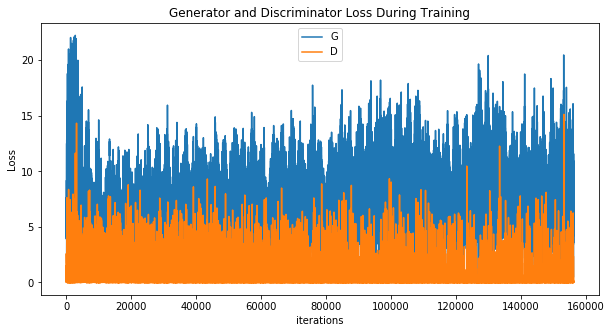

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(original))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(img_list2[-1], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())